In [1]:
# ...
import sys;sys.path.append('../..')
from abslithist.words import *

In [2]:
dfnorms = format_norms_as_long(get_allnorms())
dfnorms['period']=dfnorms['source'].apply(lambda x: x.split('.')[-1])
dfnorms

word         z              source source_type  decision  order  \
629823         mā -4.083841     SingleWords.C16        Imag  Abstract      0   
559803   justifier -3.738178      MultiWords.C16        Imag  Abstract      0   
3887931  justifier -3.657426   MultiWords.median        Imag  Abstract      0   
4030947        mā -3.590872  SingleWords.median        Imag  Abstract      0   
1159801  executeth -3.580084      MultiWords.C17        Imag  Abstract      0   
...            ...       ...                 ...         ...       ...    ...   
628891     maidens  4.598060     SingleWords.C16        Imag  Concrete      0   
1690873     coquet  4.631652      MultiWords.C18        Imag  Concrete      0   
1148937   childbed  4.649619      MultiWords.C17        Imag  Concrete      0   
1209003   childbed  5.014402     SingleWords.C17        Imag  Concrete      0   
562900     maidens  5.553281      MultiWords.C16        Imag  Concrete      0   

         period  
629823      C16  
559803      C16  
3887931  median  
4030947  median  
1159801     C17  
...         ...  
628891      C16  
1690873     C18  
1148937     C17  
1209003     C17  
562900      C16  

[4245995 rows x 7 columns]

## Passages

In [3]:
def cleantxt(txt):
#     return txt#.replace("*","").replace('`','').replace("'","").replace('"','').replace('\n',' @ ').replace('\\','')
    return txt.replace('\n',' @ ').replace('\\','').replace('*','').replace("`","")

In [4]:
def psg2df(txt,stopwords={},periods={}):
    norms=dfnorms if not periods else dfnorms[dfnorms.period.isin(periods)]
    wordavg=norms[['word','z']].groupby('word').mean()
    wordavg['bin']=[str(x) for x in pd.qcut(wordavg.z,q=qnum,labels=labels)]
    txt=cleantxt(txt)
    txtl=tokenize(txt,lower=False,modernize=False)
    df=pd.DataFrame()
    df['tok']=txtl
    df['i']=list(range(len(txtl)))
    df['tokl']=df['tok'].apply(lambda x: x.lower())
    df=df.set_index('tokl').join(wordavg,how='left').rename_axis('tokl').reset_index().sort_values('i')
    #df.loc[df['tokl'].isin(stopwords),'z']=np.nan
    df['z']=[np.nan if tokl in stopwords else x
            for tokl,x in zip(df.tokl, df.z)]
    df['bin']=['' if tokl in stopwords else x
            for tokl,x in zip(df.tokl, df.bin)]
    return df

In [5]:
# psg2df('Fanny Price is a good person',stopwords={'fanny','price'})

In [6]:
ZCUT=.666
def df2xml(df,abs_below=-ZCUT,conc_above=ZCUT):
    words=[]
    for i,row in df.sort_values('i').fillna('').iterrows():
        tok=cleantxt(row.tok)
#         print([tok])
        if tok=='@':
            words+=['\n']
            continue
        if not tok: continue
        if not tok[0].isalpha() and words and tok!='``':
            words[-1]+=tok
            continue
        
        if row.bin:
            word=f'<conc{row.bin}>{tok}</conc{row.bin}>'
        else:
            word=tok
        
        # ?
        if row.z:
            z=float(row.z)
            if z<abs_below:
                word=f'<abs>{word}</abs>'
            elif z>conc_above:
                word=f'<conc>{word}</conc>'
            else:
                word=f'<neither>{word}</neither>'            
        words.append(word)
    xml='<p>' + ' '.join(words) + '</p>'
    
#     xml=xml.strip()
#     xml=xml.replace('\n \n','\n\n')
#     if not ' \n ' in xml: xml=xml.replace('\n\n','\n')
# #     if not '\n\n' in xml and '\n' in xml:
# #         xml=xml.replace('\n','\n\n')
    return xml

In [7]:
def plot_densityz(df,title='',fig=None):
    p9.options.dpi=600
    p9.options.figure_size=(8,4)
    df=df.dropna()

    # density plot
    avgstr=f'Average = {round(df.z.mean(),2)}'
    
    if fig is None:
        fig=p9.ggplot(p9.aes(x='z',y='..count..'))
    for nn in range(25):
        fig+=p9.geom_density(data=df.sample(n=1000,replace=True))

    return fig

#### showpsg()

In [8]:
def showpsg(txt,title='',other_txt='',showxml=True,stopwords={},periods={}):
    if title:printm('#### '+title)
    df=psg2df(cleantxt(txt),stopwords=stopwords,periods=periods)
    xml=df2xml(df)
    if showxml: printm(xml)
    avgstr=f'Average = {round(df.z.mean(),2)}'
    nx=1000#len(df.dropna())
    
    # density plot
    fig=p9.ggplot(p9.aes(x='z'))
    if other_txt:
        otdf=psg2df(cleantxt(other_txt),stopwords=stopwords)
        for nn in range(25):
            fig+=p9.geom_density(color='silver',data=otdf.sample(n=nx,replace=True),alpha=0.25)
    fig+=p9.geom_density(data=df)
    # other densities?
    
    p9.options.dpi=600
    fig+=p9.labs(
        title=f'Distribution of word concreteness scores (n={len(df.dropna())})',
        x='Concreteness score',
        y='Density of instances'
    )
    fig+=p9.theme_classic()
    fig+=p9.theme(title=p9.element_text(size=6),text=p9.element_text(size=6))
    fig+=p9.xlim(-3,3)
#     fig+=p9.geom_vline(xintercept=df.z.mean(),alpha=0.5)
    fig+=p9.geom_vline(xintercept=0,alpha=0.25)
    fig+=p9.geom_text(x=df.z.mean()+0.05,y=1,label=avgstr,inherit_aes=False,size=7,ha='left')
    display(fig)
    
#     return df

In [9]:
qnum=1000
p9.options.figure_size=6,2
zf=3
labels=[str(x).zfill(zf) for x in range(qnum)]
from colour import Color


# Set colors
gradient=rdybl=list(reversed([
#     '#A51626',
    '#D73027',
    '#F46D43',
    '#FDAE61',
    '#FEE090',
    '#FFFDBF',
    '#E0F3F8',
    '#ABD9E9',
    '#74ADD1',
    '#4575B4',
#     '#323695'
]))
len(rdybl)

gradient=['#EFEFEF','#9A9A9A','#EFEFEF']
# gradient=['silver','white','silver']

color_range=[]
for i,x in enumerate(gradient):
    if not i: continue
    prev=gradient[i-1]
    color_range+=list(
        Color(prev).range_to(
            Color(x),
            int(round(qnum/(len(gradient)-1)))
        )
    )
# print(color_range)
print(len(color_range))
# for c in color_range:
#     c.saturation=0.6
#     c.luminance = 0.75

width_range=4
lastpoint=len(color_range)
midpoint=len(color_range)//2
opacity_range=0.3
  
css = []
for i,x in enumerate(color_range):
    diff=abs(midpoint-i)
    diffperc=int(round(diff/midpoint * width_range))
    opacity= (diff/midpoint *opacity_range) + 0.025
    
#     percthru=(i+1)/lastpoint
#     percthrur=1-percthru
#     diffperc=int(round(percthru * width_range))
#     opacity= (percthrur*opacity_range)# + 0.025
    
    
    cssx=f'conc{str(i).zfill(zf)}' + ' {'
    rgbstr=str(x.rgb)[:-1] + f', {opacity})'
    
    cssx+=f'display: inline-block; '
    
    typex='solid' if i>=midpoint else 'dotted'
    typex='solid'
    bordertype1='border-left' if i>=midpoint else 'border-bottom'
    bordertype2='border-right' if i>=midpoint else 'border-top'
#     cssx+=f'{bordertype1}: {diffperc}px {typex} black; '
#     cssx+=f'{bordertype2}: {diffperc}px {typex} black; '
    
    
    if i>=midpoint:
        cssx+=f'background-color: rgba{rgbstr}; '
    else:
        cssx+=f'border: {diffperc}px {typex} dimgray; '
    cssx+=' }'
    css+=[cssx]


# css+=['abs { font-weight: bold; font-style: italic; }']
# css+=['conc { text-decoration: underline; font-weight:bold; }']#' display: inline-block; border: 1px solid black; }']
# css+=['neither { font-style: italic;  }']
css+=['p { line-height: 1.5em; }']

cssstr=f'<style type="text/css">' + ("\n".join(css)) + '</style>'
printm(cssstr)
css[0]

1000


<style type="text/css">conc000 {display: inline-block; border: 4px solid dimgray;  }
conc001 {display: inline-block; border: 4px solid dimgray;  }
conc002 {display: inline-block; border: 4px solid dimgray;  }
conc003 {display: inline-block; border: 4px solid dimgray;  }
conc004 {display: inline-block; border: 4px solid dimgray;  }
conc005 {display: inline-block; border: 4px solid dimgray;  }
conc006 {display: inline-block; border: 4px solid dimgray;  }
conc007 {display: inline-block; border: 4px solid dimgray;  }
conc008 {display: inline-block; border: 4px solid dimgray;  }
conc009 {display: inline-block; border: 4px solid dimgray;  }
conc010 {display: inline-block; border: 4px solid dimgray;  }
conc011 {display: inline-block; border: 4px solid dimgray;  }
conc012 {display: inline-block; border: 4px solid dimgray;  }
conc013 {display: inline-block; border: 4px solid dimgray;  }
conc014 {display: inline-block; border: 4px solid dimgray;  }
conc015 {display: inline-block; border: 4px solid dimgray;  }
conc016 {display: inline-block; border: 4px solid dimgray;  }
conc017 {display: inline-block; border: 4px solid dimgray;  }
conc018 {display: inline-block; border: 4px solid dimgray;  }
conc019 {display: inline-block; border: 4px solid dimgray;  }
conc020 {display: inline-block; border: 4px solid dimgray;  }
conc021 {display: inline-block; border: 4px solid dimgray;  }
conc022 {display: inline-block; border: 4px solid dimgray;  }
conc023 {display: inline-block; border: 4px solid dimgray;  }
conc024 {display: inline-block; border: 4px solid dimgray;  }
conc025 {display: inline-block; border: 4px solid dimgray;  }
conc026 {display: inline-block; border: 4px solid dimgray;  }
conc027 {display: inline-block; border: 4px solid dimgray;  }
conc028 {display: inline-block; border: 4px solid dimgray;  }
conc029 {display: inline-block; border: 4px solid dimgray;  }
conc030 {display: inline-block; border: 4px solid dimgray;  }
conc031 {display: inline-block; border: 4px solid dimgray;  }
conc032 {display: inline-block; border: 4px solid dimgray;  }
conc033 {display: inline-block; border: 4px solid dimgray;  }
conc034 {display: inline-block; border: 4px solid dimgray;  }
conc035 {display: inline-block; border: 4px solid dimgray;  }
conc036 {display: inline-block; border: 4px solid dimgray;  }
conc037 {display: inline-block; border: 4px solid dimgray;  }
conc038 {display: inline-block; border: 4px solid dimgray;  }
conc039 {display: inline-block; border: 4px solid dimgray;  }
conc040 {display: inline-block; border: 4px solid dimgray;  }
conc041 {display: inline-block; border: 4px solid dimgray;  }
conc042 {display: inline-block; border: 4px solid dimgray;  }
conc043 {display: inline-block; border: 4px solid dimgray;  }
conc044 {display: inline-block; border: 4px solid dimgray;  }
conc045 {display: inline-block; border: 4px solid dimgray;  }
conc046 {display: inline-block; border: 4px solid dimgray;  }
conc047 {display: inline-block; border: 4px solid dimgray;  }
conc048 {display: inline-block; border: 4px solid dimgray;  }
conc049 {display: inline-block; border: 4px solid dimgray;  }
conc050 {display: inline-block; border: 4px solid dimgray;  }
conc051 {display: inline-block; border: 4px solid dimgray;  }
conc052 {display: inline-block; border: 4px solid dimgray;  }
conc053 {display: inline-block; border: 4px solid dimgray;  }
conc054 {display: inline-block; border: 4px solid dimgray;  }
conc055 {display: inline-block; border: 4px solid dimgray;  }
conc056 {display: inline-block; border: 4px solid dimgray;  }
conc057 {display: inline-block; border: 4px solid dimgray;  }
conc058 {display: inline-block; border: 4px solid dimgray;  }
conc059 {display: inline-block; border: 4px solid dimgray;  }
conc060 {display: inline-block; border: 4px solid dimgray;  }
conc061 {display: inline-block; border: 4px solid dimgray;  }
conc062 {display: inline-block; border: 4px solid dimgray;  }
conc063 {display: inline-block; border: 3px solid dimgray;  }
conc064 {display: inline-block; border: 3px solid dimgray;  }
conc065 {display: inline-block; border: 3px solid dimgray;  }
conc066 {display: inline-block; border: 3px solid dimgray;  }
conc067 {display: inline-block; border: 3px solid dimgray;  }
conc068 {display: inline-block; border: 3px solid dimgray;  }
conc069 {display: inline-block; border: 3px solid dimgray;  }
conc070 {display: inline-block; border: 3px solid dimgray;  }
conc071 {display: inline-block; border: 3px solid dimgray;  }
conc072 {display: inline-block; border: 3px solid dimgray;  }
conc073 {display: inline-block; border: 3px solid dimgray;  }
conc074 {display: inline-block; border: 3px solid dimgray;  }
conc075 {display: inline-block; border: 3px solid dimgray;  }
conc076 {display: inline-block; border: 3px solid dimgray;  }
conc077 {display: inline-block; border: 3px solid dimgray;  }
conc078 {display: inline-block; border: 3px solid dimgray;  }
conc079 {display: inline-block; border: 3px solid dimgray;  }
conc080 {display: inline-block; border: 3px solid dimgray;  }
conc081 {display: inline-block; border: 3px solid dimgray;  }
conc082 {display: inline-block; border: 3px solid dimgray;  }
conc083 {display: inline-block; border: 3px solid dimgray;  }
conc084 {display: inline-block; border: 3px solid dimgray;  }
conc085 {display: inline-block; border: 3px solid dimgray;  }
conc086 {display: inline-block; border: 3px solid dimgray;  }
conc087 {display: inline-block; border: 3px solid dimgray;  }
conc088 {display: inline-block; border: 3px solid dimgray;  }
conc089 {display: inline-block; border: 3px solid dimgray;  }
conc090 {display: inline-block; border: 3px solid dimgray;  }
conc091 {display: inline-block; border: 3px solid dimgray;  }
conc092 {display: inline-block; border: 3px solid dimgray;  }
conc093 {display: inline-block; border: 3px solid dimgray;  }
conc094 {display: inline-block; border: 3px solid dimgray;  }
conc095 {display: inline-block; border: 3px solid dimgray;  }
conc096 {display: inline-block; border: 3px solid dimgray;  }
conc097 {display: inline-block; border: 3px solid dimgray;  }
conc098 {display: inline-block; border: 3px solid dimgray;  }
conc099 {display: inline-block; border: 3px solid dimgray;  }
conc100 {display: inline-block; border: 3px solid dimgray;  }
conc101 {display: inline-block; border: 3px solid dimgray;  }
conc102 {display: inline-block; border: 3px solid dimgray;  }
conc103 {display: inline-block; border: 3px solid dimgray;  }
conc104 {display: inline-block; border: 3px solid dimgray;  }
conc105 {display: inline-block; border: 3px solid dimgray;  }
conc106 {display: inline-block; border: 3px solid dimgray;  }
conc107 {display: inline-block; border: 3px solid dimgray;  }
conc108 {display: inline-block; border: 3px solid dimgray;  }
conc109 {display: inline-block; border: 3px solid dimgray;  }
conc110 {display: inline-block; border: 3px solid dimgray;  }
conc111 {display: inline-block; border: 3px solid dimgray;  }
conc112 {display: inline-block; border: 3px solid dimgray;  }
conc113 {display: inline-block; border: 3px solid dimgray;  }
conc114 {display: inline-block; border: 3px solid dimgray;  }
conc115 {display: inline-block; border: 3px solid dimgray;  }
conc116 {display: inline-block; border: 3px solid dimgray;  }
conc117 {display: inline-block; border: 3px solid dimgray;  }
conc118 {display: inline-block; border: 3px solid dimgray;  }
conc119 {display: inline-block; border: 3px solid dimgray;  }
conc120 {display: inline-block; border: 3px solid dimgray;  }
conc121 {display: inline-block; border: 3px solid dimgray;  }
conc122 {display: inline-block; border: 3px solid dimgray;  }
conc123 {display: inline-block; border: 3px solid dimgray;  }
conc124 {display: inline-block; border: 3px solid dimgray;  }
conc125 {display: inline-block; border: 3px solid dimgray;  }
conc126 {display: inline-block; border: 3px solid dimgray;  }
conc127 {display: inline-block; border: 3px solid dimgray;  }
conc128 {display: inline-block; border: 3px solid dimgray;  }
conc129 {display: inline-block; border: 3px solid dimgray;  }
conc130 {display: inline-block; border: 3px solid dimgray;  }
conc131 {display: inline-block; border: 3px solid dimgray;  }
conc132 {display: inline-block; border: 3px solid dimgray;  }
conc133 {display: inline-block; border: 3px solid dimgray;  }
conc134 {display: inline-block; border: 3px solid dimgray;  }
conc135 {display: inline-block; border: 3px solid dimgray;  }
conc136 {display: inline-block; border: 3px solid dimgray;  }
conc137 {display: inline-block; border: 3px solid dimgray;  }
conc138 {display: inline-block; border: 3px solid dimgray;  }
conc139 {display: inline-block; border: 3px solid dimgray;  }
conc140 {display: inline-block; border: 3px solid dimgray;  }
conc141 {display: inline-block; border: 3px solid dimgray;  }
conc142 {display: inline-block; border: 3px solid dimgray;  }
conc143 {display: inline-block; border: 3px solid dimgray;  }
conc144 {display: inline-block; border: 3px solid dimgray;  }
conc145 {display: inline-block; border: 3px solid dimgray;  }
conc146 {display: inline-block; border: 3px solid dimgray;  }
conc147 {display: inline-block; border: 3px solid dimgray;  }
conc148 {display: inline-block; border: 3px solid dimgray;  }
conc149 {display: inline-block; border: 3px solid dimgray;  }
conc150 {display: inline-block; border: 3px solid dimgray;  }
conc151 {display: inline-block; border: 3px solid dimgray;  }
conc152 {display: inline-block; border: 3px solid dimgray;  }
conc153 {display: inline-block; border: 3px solid dimgray;  }
conc154 {display: inline-block; border: 3px solid dimgray;  }
conc155 {display: inline-block; border: 3px solid dimgray;  }
conc156 {display: inline-block; border: 3px solid dimgray;  }
conc157 {display: inline-block; border: 3px solid dimgray;  }
conc158 {display: inline-block; border: 3px solid dimgray;  }
conc159 {display: inline-block; border: 3px solid dimgray;  }
conc160 {display: inline-block; border: 3px solid dimgray;  }
conc161 {display: inline-block; border: 3px solid dimgray;  }
conc162 {display: inline-block; border: 3px solid dimgray;  }
conc163 {display: inline-block; border: 3px solid dimgray;  }
conc164 {display: inline-block; border: 3px solid dimgray;  }
conc165 {display: inline-block; border: 3px solid dimgray;  }
conc166 {display: inline-block; border: 3px solid dimgray;  }
conc167 {display: inline-block; border: 3px solid dimgray;  }
conc168 {display: inline-block; border: 3px solid dimgray;  }
conc169 {display: inline-block; border: 3px solid dimgray;  }
conc170 {display: inline-block; border: 3px solid dimgray;  }
conc171 {display: inline-block; border: 3px solid dimgray;  }
conc172 {display: inline-block; border: 3px solid dimgray;  }
conc173 {display: inline-block; border: 3px solid dimgray;  }
conc174 {display: inline-block; border: 3px solid dimgray;  }
conc175 {display: inline-block; border: 3px solid dimgray;  }
conc176 {display: inline-block; border: 3px solid dimgray;  }
conc177 {display: inline-block; border: 3px solid dimgray;  }
conc178 {display: inline-block; border: 3px solid dimgray;  }
conc179 {display: inline-block; border: 3px solid dimgray;  }
conc180 {display: inline-block; border: 3px solid dimgray;  }
conc181 {display: inline-block; border: 3px solid dimgray;  }
conc182 {display: inline-block; border: 3px solid dimgray;  }
conc183 {display: inline-block; border: 3px solid dimgray;  }
conc184 {display: inline-block; border: 3px solid dimgray;  }
conc185 {display: inline-block; border: 3px solid dimgray;  }
conc186 {display: inline-block; border: 3px solid dimgray;  }
conc187 {display: inline-block; border: 3px solid dimgray;  }
conc188 {display: inline-block; border: 2px solid dimgray;  }
conc189 {display: inline-block; border: 2px solid dimgray;  }
conc190 {display: inline-block; border: 2px solid dimgray;  }
conc191 {display: inline-block; border: 2px solid dimgray;  }
conc192 {display: inline-block; border: 2px solid dimgray;  }
conc193 {display: inline-block; border: 2px solid dimgray;  }
conc194 {display: inline-block; border: 2px solid dimgray;  }
conc195 {display: inline-block; border: 2px solid dimgray;  }
conc196 {display: inline-block; border: 2px solid dimgray;  }
conc197 {display: inline-block; border: 2px solid dimgray;  }
conc198 {display: inline-block; border: 2px solid dimgray;  }
conc199 {display: inline-block; border: 2px solid dimgray;  }
conc200 {display: inline-block; border: 2px solid dimgray;  }
conc201 {display: inline-block; border: 2px solid dimgray;  }
conc202 {display: inline-block; border: 2px solid dimgray;  }
conc203 {display: inline-block; border: 2px solid dimgray;  }
conc204 {display: inline-block; border: 2px solid dimgray;  }
conc205 {display: inline-block; border: 2px solid dimgray;  }
conc206 {display: inline-block; border: 2px solid dimgray;  }
conc207 {display: inline-block; border: 2px solid dimgray;  }
conc208 {display: inline-block; border: 2px solid dimgray;  }
conc209 {display: inline-block; border: 2px solid dimgray;  }
conc210 {display: inline-block; border: 2px solid dimgray;  }
conc211 {display: inline-block; border: 2px solid dimgray;  }
conc212 {display: inline-block; border: 2px solid dimgray;  }
conc213 {display: inline-block; border: 2px solid dimgray;  }
conc214 {display: inline-block; border: 2px solid dimgray;  }
conc215 {display: inline-block; border: 2px solid dimgray;  }
conc216 {display: inline-block; border: 2px solid dimgray;  }
conc217 {display: inline-block; border: 2px solid dimgray;  }
conc218 {display: inline-block; border: 2px solid dimgray;  }
conc219 {display: inline-block; border: 2px solid dimgray;  }
conc220 {display: inline-block; border: 2px solid dimgray;  }
conc221 {display: inline-block; border: 2px solid dimgray;  }
conc222 {display: inline-block; border: 2px solid dimgray;  }
conc223 {display: inline-block; border: 2px solid dimgray;  }
conc224 {display: inline-block; border: 2px solid dimgray;  }
conc225 {display: inline-block; border: 2px solid dimgray;  }
conc226 {display: inline-block; border: 2px solid dimgray;  }
conc227 {display: inline-block; border: 2px solid dimgray;  }
conc228 {display: inline-block; border: 2px solid dimgray;  }
conc229 {display: inline-block; border: 2px solid dimgray;  }
conc230 {display: inline-block; border: 2px solid dimgray;  }
conc231 {display: inline-block; border: 2px solid dimgray;  }
conc232 {display: inline-block; border: 2px solid dimgray;  }
conc233 {display: inline-block; border: 2px solid dimgray;  }
conc234 {display: inline-block; border: 2px solid dimgray;  }
conc235 {display: inline-block; border: 2px solid dimgray;  }
conc236 {display: inline-block; border: 2px solid dimgray;  }
conc237 {display: inline-block; border: 2px solid dimgray;  }
conc238 {display: inline-block; border: 2px solid dimgray;  }
conc239 {display: inline-block; border: 2px solid dimgray;  }
conc240 {display: inline-block; border: 2px solid dimgray;  }
conc241 {display: inline-block; border: 2px solid dimgray;  }
conc242 {display: inline-block; border: 2px solid dimgray;  }
conc243 {display: inline-block; border: 2px solid dimgray;  }
conc244 {display: inline-block; border: 2px solid dimgray;  }
conc245 {display: inline-block; border: 2px solid dimgray;  }
conc246 {display: inline-block; border: 2px solid dimgray;  }
conc247 {display: inline-block; border: 2px solid dimgray;  }
conc248 {display: inline-block; border: 2px solid dimgray;  }
conc249 {display: inline-block; border: 2px solid dimgray;  }
conc250 {display: inline-block; border: 2px solid dimgray;  }
conc251 {display: inline-block; border: 2px solid dimgray;  }
conc252 {display: inline-block; border: 2px solid dimgray;  }
conc253 {display: inline-block; border: 2px solid dimgray;  }
conc254 {display: inline-block; border: 2px solid dimgray;  }
conc255 {display: inline-block; border: 2px solid dimgray;  }
conc256 {display: inline-block; border: 2px solid dimgray;  }
conc257 {display: inline-block; border: 2px solid dimgray;  }
conc258 {display: inline-block; border: 2px solid dimgray;  }
conc259 {display: inline-block; border: 2px solid dimgray;  }
conc260 {display: inline-block; border: 2px solid dimgray;  }
conc261 {display: inline-block; border: 2px solid dimgray;  }
conc262 {display: inline-block; border: 2px solid dimgray;  }
conc263 {display: inline-block; border: 2px solid dimgray;  }
conc264 {display: inline-block; border: 2px solid dimgray;  }
conc265 {display: inline-block; border: 2px solid dimgray;  }
conc266 {display: inline-block; border: 2px solid dimgray;  }
conc267 {display: inline-block; border: 2px solid dimgray;  }
conc268 {display: inline-block; border: 2px solid dimgray;  }
conc269 {display: inline-block; border: 2px solid dimgray;  }
conc270 {display: inline-block; border: 2px solid dimgray;  }
conc271 {display: inline-block; border: 2px solid dimgray;  }
conc272 {display: inline-block; border: 2px solid dimgray;  }
conc273 {display: inline-block; border: 2px solid dimgray;  }
conc274 {display: inline-block; border: 2px solid dimgray;  }
conc275 {display: inline-block; border: 2px solid dimgray;  }
conc276 {display: inline-block; border: 2px solid dimgray;  }
conc277 {display: inline-block; border: 2px solid dimgray;  }
conc278 {display: inline-block; border: 2px solid dimgray;  }
conc279 {display: inline-block; border: 2px solid dimgray;  }
conc280 {display: inline-block; border: 2px solid dimgray;  }
conc281 {display: inline-block; border: 2px solid dimgray;  }
conc282 {display: inline-block; border: 2px solid dimgray;  }
conc283 {display: inline-block; border: 2px solid dimgray;  }
conc284 {display: inline-block; border: 2px solid dimgray;  }
conc285 {display: inline-block; border: 2px solid dimgray;  }
conc286 {display: inline-block; border: 2px solid dimgray;  }
conc287 {display: inline-block; border: 2px solid dimgray;  }
conc288 {display: inline-block; border: 2px solid dimgray;  }
conc289 {display: inline-block; border: 2px solid dimgray;  }
conc290 {display: inline-block; border: 2px solid dimgray;  }
conc291 {display: inline-block; border: 2px solid dimgray;  }
conc292 {display: inline-block; border: 2px solid dimgray;  }
conc293 {display: inline-block; border: 2px solid dimgray;  }
conc294 {display: inline-block; border: 2px solid dimgray;  }
conc295 {display: inline-block; border: 2px solid dimgray;  }
conc296 {display: inline-block; border: 2px solid dimgray;  }
conc297 {display: inline-block; border: 2px solid dimgray;  }
conc298 {display: inline-block; border: 2px solid dimgray;  }
conc299 {display: inline-block; border: 2px solid dimgray;  }
conc300 {display: inline-block; border: 2px solid dimgray;  }
conc301 {display: inline-block; border: 2px solid dimgray;  }
conc302 {display: inline-block; border: 2px solid dimgray;  }
conc303 {display: inline-block; border: 2px solid dimgray;  }
conc304 {display: inline-block; border: 2px solid dimgray;  }
conc305 {display: inline-block; border: 2px solid dimgray;  }
conc306 {display: inline-block; border: 2px solid dimgray;  }
conc307 {display: inline-block; border: 2px solid dimgray;  }
conc308 {display: inline-block; border: 2px solid dimgray;  }
conc309 {display: inline-block; border: 2px solid dimgray;  }
conc310 {display: inline-block; border: 2px solid dimgray;  }
conc311 {display: inline-block; border: 2px solid dimgray;  }
conc312 {display: inline-block; border: 2px solid dimgray;  }
conc313 {display: inline-block; border: 1px solid dimgray;  }
conc314 {display: inline-block; border: 1px solid dimgray;  }
conc315 {display: inline-block; border: 1px solid dimgray;  }
conc316 {display: inline-block; border: 1px solid dimgray;  }
conc317 {display: inline-block; border: 1px solid dimgray;  }
conc318 {display: inline-block; border: 1px solid dimgray;  }
conc319 {display: inline-block; border: 1px solid dimgray;  }
conc320 {display: inline-block; border: 1px solid dimgray;  }
conc321 {display: inline-block; border: 1px solid dimgray;  }
conc322 {display: inline-block; border: 1px solid dimgray;  }
conc323 {display: inline-block; border: 1px solid dimgray;  }
conc324 {display: inline-block; border: 1px solid dimgray;  }
conc325 {display: inline-block; border: 1px solid dimgray;  }
conc326 {display: inline-block; border: 1px solid dimgray;  }
conc327 {display: inline-block; border: 1px solid dimgray;  }
conc328 {display: inline-block; border: 1px solid dimgray;  }
conc329 {display: inline-block; border: 1px solid dimgray;  }
conc330 {display: inline-block; border: 1px solid dimgray;  }
conc331 {display: inline-block; border: 1px solid dimgray;  }
conc332 {display: inline-block; border: 1px solid dimgray;  }
conc333 {display: inline-block; border: 1px solid dimgray;  }
conc334 {display: inline-block; border: 1px solid dimgray;  }
conc335 {display: inline-block; border: 1px solid dimgray;  }
conc336 {display: inline-block; border: 1px solid dimgray;  }
conc337 {display: inline-block; border: 1px solid dimgray;  }
conc338 {display: inline-block; border: 1px solid dimgray;  }
conc339 {display: inline-block; border: 1px solid dimgray;  }
conc340 {display: inline-block; border: 1px solid dimgray;  }
conc341 {display: inline-block; border: 1px solid dimgray;  }
conc342 {display: inline-block; border: 1px solid dimgray;  }
conc343 {display: inline-block; border: 1px solid dimgray;  }
conc344 {display: inline-block; border: 1px solid dimgray;  }
conc345 {display: inline-block; border: 1px solid dimgray;  }
conc346 {display: inline-block; border: 1px solid dimgray;  }
conc347 {display: inline-block; border: 1px solid dimgray;  }
conc348 {display: inline-block; border: 1px solid dimgray;  }
conc349 {display: inline-block; border: 1px solid dimgray;  }
conc350 {display: inline-block; border: 1px solid dimgray;  }
conc351 {display: inline-block; border: 1px solid dimgray;  }
conc352 {display: inline-block; border: 1px solid dimgray;  }
conc353 {display: inline-block; border: 1px solid dimgray;  }
conc354 {display: inline-block; border: 1px solid dimgray;  }
conc355 {display: inline-block; border: 1px solid dimgray;  }
conc356 {display: inline-block; border: 1px solid dimgray;  }
conc357 {display: inline-block; border: 1px solid dimgray;  }
conc358 {display: inline-block; border: 1px solid dimgray;  }
conc359 {display: inline-block; border: 1px solid dimgray;  }
conc360 {display: inline-block; border: 1px solid dimgray;  }
conc361 {display: inline-block; border: 1px solid dimgray;  }
conc362 {display: inline-block; border: 1px solid dimgray;  }
conc363 {display: inline-block; border: 1px solid dimgray;  }
conc364 {display: inline-block; border: 1px solid dimgray;  }
conc365 {display: inline-block; border: 1px solid dimgray;  }
conc366 {display: inline-block; border: 1px solid dimgray;  }
conc367 {display: inline-block; border: 1px solid dimgray;  }
conc368 {display: inline-block; border: 1px solid dimgray;  }
conc369 {display: inline-block; border: 1px solid dimgray;  }
conc370 {display: inline-block; border: 1px solid dimgray;  }
conc371 {display: inline-block; border: 1px solid dimgray;  }
conc372 {display: inline-block; border: 1px solid dimgray;  }
conc373 {display: inline-block; border: 1px solid dimgray;  }
conc374 {display: inline-block; border: 1px solid dimgray;  }
conc375 {display: inline-block; border: 1px solid dimgray;  }
conc376 {display: inline-block; border: 1px solid dimgray;  }
conc377 {display: inline-block; border: 1px solid dimgray;  }
conc378 {display: inline-block; border: 1px solid dimgray;  }
conc379 {display: inline-block; border: 1px solid dimgray;  }
conc380 {display: inline-block; border: 1px solid dimgray;  }
conc381 {display: inline-block; border: 1px solid dimgray;  }
conc382 {display: inline-block; border: 1px solid dimgray;  }
conc383 {display: inline-block; border: 1px solid dimgray;  }
conc384 {display: inline-block; border: 1px solid dimgray;  }
conc385 {display: inline-block; border: 1px solid dimgray;  }
conc386 {display: inline-block; border: 1px solid dimgray;  }
conc387 {display: inline-block; border: 1px solid dimgray;  }
conc388 {display: inline-block; border: 1px solid dimgray;  }
conc389 {display: inline-block; border: 1px solid dimgray;  }
conc390 {display: inline-block; border: 1px solid dimgray;  }
conc391 {display: inline-block; border: 1px solid dimgray;  }
conc392 {display: inline-block; border: 1px solid dimgray;  }
conc393 {display: inline-block; border: 1px solid dimgray;  }
conc394 {display: inline-block; border: 1px solid dimgray;  }
conc395 {display: inline-block; border: 1px solid dimgray;  }
conc396 {display: inline-block; border: 1px solid dimgray;  }
conc397 {display: inline-block; border: 1px solid dimgray;  }
conc398 {display: inline-block; border: 1px solid dimgray;  }
conc399 {display: inline-block; border: 1px solid dimgray;  }
conc400 {display: inline-block; border: 1px solid dimgray;  }
conc401 {display: inline-block; border: 1px solid dimgray;  }
conc402 {display: inline-block; border: 1px solid dimgray;  }
conc403 {display: inline-block; border: 1px solid dimgray;  }
conc404 {display: inline-block; border: 1px solid dimgray;  }
conc405 {display: inline-block; border: 1px solid dimgray;  }
conc406 {display: inline-block; border: 1px solid dimgray;  }
conc407 {display: inline-block; border: 1px solid dimgray;  }
conc408 {display: inline-block; border: 1px solid dimgray;  }
conc409 {display: inline-block; border: 1px solid dimgray;  }
conc410 {display: inline-block; border: 1px solid dimgray;  }
conc411 {display: inline-block; border: 1px solid dimgray;  }
conc412 {display: inline-block; border: 1px solid dimgray;  }
conc413 {display: inline-block; border: 1px solid dimgray;  }
conc414 {display: inline-block; border: 1px solid dimgray;  }
conc415 {display: inline-block; border: 1px solid dimgray;  }
conc416 {display: inline-block; border: 1px solid dimgray;  }
conc417 {display: inline-block; border: 1px solid dimgray;  }
conc418 {display: inline-block; border: 1px solid dimgray;  }
conc419 {display: inline-block; border: 1px solid dimgray;  }
conc420 {display: inline-block; border: 1px solid dimgray;  }
conc421 {display: inline-block; border: 1px solid dimgray;  }
conc422 {display: inline-block; border: 1px solid dimgray;  }
conc423 {display: inline-block; border: 1px solid dimgray;  }
conc424 {display: inline-block; border: 1px solid dimgray;  }
conc425 {display: inline-block; border: 1px solid dimgray;  }
conc426 {display: inline-block; border: 1px solid dimgray;  }
conc427 {display: inline-block; border: 1px solid dimgray;  }
conc428 {display: inline-block; border: 1px solid dimgray;  }
conc429 {display: inline-block; border: 1px solid dimgray;  }
conc430 {display: inline-block; border: 1px solid dimgray;  }
conc431 {display: inline-block; border: 1px solid dimgray;  }
conc432 {display: inline-block; border: 1px solid dimgray;  }
conc433 {display: inline-block; border: 1px solid dimgray;  }
conc434 {display: inline-block; border: 1px solid dimgray;  }
conc435 {display: inline-block; border: 1px solid dimgray;  }
conc436 {display: inline-block; border: 1px solid dimgray;  }
conc437 {display: inline-block; border: 1px solid dimgray;  }
conc438 {display: inline-block; border: 0px solid dimgray;  }
conc439 {display: inline-block; border: 0px solid dimgray;  }
conc440 {display: inline-block; border: 0px solid dimgray;  }
conc441 {display: inline-block; border: 0px solid dimgray;  }
conc442 {display: inline-block; border: 0px solid dimgray;  }
conc443 {display: inline-block; border: 0px solid dimgray;  }
conc444 {display: inline-block; border: 0px solid dimgray;  }
conc445 {display: inline-block; border: 0px solid dimgray;  }
conc446 {display: inline-block; border: 0px solid dimgray;  }
conc447 {display: inline-block; border: 0px solid dimgray;  }
conc448 {display: inline-block; border: 0px solid dimgray;  }
conc449 {display: inline-block; border: 0px solid dimgray;  }
conc450 {display: inline-block; border: 0px solid dimgray;  }
conc451 {display: inline-block; border: 0px solid dimgray;  }
conc452 {display: inline-block; border: 0px solid dimgray;  }
conc453 {display: inline-block; border: 0px solid dimgray;  }
conc454 {display: inline-block; border: 0px solid dimgray;  }
conc455 {display: inline-block; border: 0px solid dimgray;  }
conc456 {display: inline-block; border: 0px solid dimgray;  }
conc457 {display: inline-block; border: 0px solid dimgray;  }
conc458 {display: inline-block; border: 0px solid dimgray;  }
conc459 {display: inline-block; border: 0px solid dimgray;  }
conc460 {display: inline-block; border: 0px solid dimgray;  }
conc461 {display: inline-block; border: 0px solid dimgray;  }
conc462 {display: inline-block; border: 0px solid dimgray;  }
conc463 {display: inline-block; border: 0px solid dimgray;  }
conc464 {display: inline-block; border: 0px solid dimgray;  }
conc465 {display: inline-block; border: 0px solid dimgray;  }
conc466 {display: inline-block; border: 0px solid dimgray;  }
conc467 {display: inline-block; border: 0px solid dimgray;  }
conc468 {display: inline-block; border: 0px solid dimgray;  }
conc469 {display: inline-block; border: 0px solid dimgray;  }
conc470 {display: inline-block; border: 0px solid dimgray;  }
conc471 {display: inline-block; border: 0px solid dimgray;  }
conc472 {display: inline-block; border: 0px solid dimgray;  }
conc473 {display: inline-block; border: 0px solid dimgray;  }
conc474 {display: inline-block; border: 0px solid dimgray;  }
conc475 {display: inline-block; border: 0px solid dimgray;  }
conc476 {display: inline-block; border: 0px solid dimgray;  }
conc477 {display: inline-block; border: 0px solid dimgray;  }
conc478 {display: inline-block; border: 0px solid dimgray;  }
conc479 {display: inline-block; border: 0px solid dimgray;  }
conc480 {display: inline-block; border: 0px solid dimgray;  }
conc481 {display: inline-block; border: 0px solid dimgray;  }
conc482 {display: inline-block; border: 0px solid dimgray;  }
conc483 {display: inline-block; border: 0px solid dimgray;  }
conc484 {display: inline-block; border: 0px solid dimgray;  }
conc485 {display: inline-block; border: 0px solid dimgray;  }
conc486 {display: inline-block; border: 0px solid dimgray;  }
conc487 {display: inline-block; border: 0px solid dimgray;  }
conc488 {display: inline-block; border: 0px solid dimgray;  }
conc489 {display: inline-block; border: 0px solid dimgray;  }
conc490 {display: inline-block; border: 0px solid dimgray;  }
conc491 {display: inline-block; border: 0px solid dimgray;  }
conc492 {display: inline-block; border: 0px solid dimgray;  }
conc493 {display: inline-block; border: 0px solid dimgray;  }
conc494 {display: inline-block; border: 0px solid dimgray;  }
conc495 {display: inline-block; border: 0px solid dimgray;  }
conc496 {display: inline-block; border: 0px solid dimgray;  }
conc497 {display: inline-block; border: 0px solid dimgray;  }
conc498 {display: inline-block; border: 0px solid dimgray;  }
conc499 {display: inline-block; border: 0px solid dimgray;  }
conc500 {display: inline-block; background-color: rgba(0.6039215686274509, 0.6039215686274509, 0.6039215686274509, 0.025);  }
conc501 {display: inline-block; background-color: rgba(0.6045895712994617, 0.6045895712994617, 0.6045895712994617, 0.0256);  }
conc502 {display: inline-block; background-color: rgba(0.6052575739714723, 0.6052575739714723, 0.6052575739714723, 0.0262);  }
conc503 {display: inline-block; background-color: rgba(0.605925576643483, 0.605925576643483, 0.605925576643483, 0.0268);  }
conc504 {display: inline-block; background-color: rgba(0.6065935793154937, 0.6065935793154937, 0.6065935793154937, 0.0274);  }
conc505 {display: inline-block; background-color: rgba(0.6072615819875044, 0.6072615819875044, 0.6072615819875044, 0.028);  }
conc506 {display: inline-block; background-color: rgba(0.6079295846595151, 0.6079295846595151, 0.6079295846595151, 0.0286);  }
conc507 {display: inline-block; background-color: rgba(0.6085975873315258, 0.6085975873315258, 0.6085975873315258, 0.0292);  }
conc508 {display: inline-block; background-color: rgba(0.6092655900035364, 0.6092655900035364, 0.6092655900035364, 0.0298);  }
conc509 {display: inline-block; background-color: rgba(0.6099335926755471, 0.6099335926755471, 0.6099335926755471, 0.0304);  }
conc510 {display: inline-block; background-color: rgba(0.6106015953475579, 0.6106015953475579, 0.6106015953475579, 0.031);  }
conc511 {display: inline-block; background-color: rgba(0.6112695980195685, 0.6112695980195685, 0.6112695980195685, 0.0316);  }
conc512 {display: inline-block; background-color: rgba(0.6119376006915792, 0.6119376006915792, 0.6119376006915792, 0.0322);  }
conc513 {display: inline-block; background-color: rgba(0.6126056033635899, 0.6126056033635899, 0.6126056033635899, 0.0328);  }
conc514 {display: inline-block; background-color: rgba(0.6132736060356005, 0.6132736060356005, 0.6132736060356005, 0.0334);  }
conc515 {display: inline-block; background-color: rgba(0.6139416087076113, 0.6139416087076113, 0.6139416087076113, 0.034);  }
conc516 {display: inline-block; background-color: rgba(0.614609611379622, 0.614609611379622, 0.614609611379622, 0.0346);  }
conc517 {display: inline-block; background-color: rgba(0.6152776140516326, 0.6152776140516326, 0.6152776140516326, 0.0352);  }
conc518 {display: inline-block; background-color: rgba(0.6159456167236433, 0.6159456167236433, 0.6159456167236433, 0.0358);  }
conc519 {display: inline-block; background-color: rgba(0.6166136193956541, 0.6166136193956541, 0.6166136193956541, 0.0364);  }
conc520 {display: inline-block; background-color: rgba(0.6172816220676647, 0.6172816220676647, 0.6172816220676647, 0.037000000000000005);  }
conc521 {display: inline-block; background-color: rgba(0.6179496247396754, 0.6179496247396754, 0.6179496247396754, 0.0376);  }
conc522 {display: inline-block; background-color: rgba(0.6186176274116861, 0.6186176274116861, 0.6186176274116861, 0.0382);  }
conc523 {display: inline-block; background-color: rgba(0.6192856300836967, 0.6192856300836967, 0.6192856300836967, 0.0388);  }
conc524 {display: inline-block; background-color: rgba(0.6199536327557075, 0.6199536327557075, 0.6199536327557075, 0.039400000000000004);  }
conc525 {display: inline-block; background-color: rgba(0.6206216354277182, 0.6206216354277182, 0.6206216354277182, 0.04);  }
conc526 {display: inline-block; background-color: rgba(0.6212896380997288, 0.6212896380997288, 0.6212896380997288, 0.0406);  }
conc527 {display: inline-block; background-color: rgba(0.6219576407717395, 0.6219576407717395, 0.6219576407717395, 0.0412);  }
conc528 {display: inline-block; background-color: rgba(0.6226256434437503, 0.6226256434437503, 0.6226256434437503, 0.041800000000000004);  }
conc529 {display: inline-block; background-color: rgba(0.6232936461157609, 0.6232936461157609, 0.6232936461157609, 0.0424);  }
conc530 {display: inline-block; background-color: rgba(0.6239616487877716, 0.6239616487877716, 0.6239616487877716, 0.043);  }
conc531 {display: inline-block; background-color: rgba(0.6246296514597822, 0.6246296514597822, 0.6246296514597822, 0.0436);  }
conc532 {display: inline-block; background-color: rgba(0.625297654131793, 0.625297654131793, 0.625297654131793, 0.0442);  }
conc533 {display: inline-block; background-color: rgba(0.6259656568038037, 0.6259656568038037, 0.6259656568038037, 0.044800000000000006);  }
conc534 {display: inline-block; background-color: rgba(0.6266336594758143, 0.6266336594758143, 0.6266336594758143, 0.0454);  }
conc535 {display: inline-block; background-color: rgba(0.627301662147825, 0.627301662147825, 0.627301662147825, 0.046);  }
conc536 {display: inline-block; background-color: rgba(0.6279696648198357, 0.6279696648198357, 0.6279696648198357, 0.0466);  }
conc537 {display: inline-block; background-color: rgba(0.6286376674918464, 0.6286376674918464, 0.6286376674918464, 0.0472);  }
conc538 {display: inline-block; background-color: rgba(0.6293056701638571, 0.6293056701638571, 0.6293056701638571, 0.047799999999999995);  }
conc539 {display: inline-block; background-color: rgba(0.6299736728358678, 0.6299736728358678, 0.6299736728358678, 0.0484);  }
conc540 {display: inline-block; background-color: rgba(0.6306416755078784, 0.6306416755078784, 0.6306416755078784, 0.049);  }
conc541 {display: inline-block; background-color: rgba(0.6313096781798891, 0.6313096781798891, 0.6313096781798891, 0.049600000000000005);  }
conc542 {display: inline-block; background-color: rgba(0.6319776808518999, 0.6319776808518999, 0.6319776808518999, 0.0502);  }
conc543 {display: inline-block; background-color: rgba(0.6326456835239105, 0.6326456835239105, 0.6326456835239105, 0.0508);  }
conc544 {display: inline-block; background-color: rgba(0.6333136861959212, 0.6333136861959212, 0.6333136861959212, 0.0514);  }
conc545 {display: inline-block; background-color: rgba(0.6339816888679319, 0.6339816888679319, 0.6339816888679319, 0.052000000000000005);  }
conc546 {display: inline-block; background-color: rgba(0.6346496915399426, 0.6346496915399426, 0.6346496915399426, 0.0526);  }
conc547 {display: inline-block; background-color: rgba(0.6353176942119533, 0.6353176942119533, 0.6353176942119533, 0.0532);  }
conc548 {display: inline-block; background-color: rgba(0.635985696883964, 0.635985696883964, 0.635985696883964, 0.0538);  }
conc549 {display: inline-block; background-color: rgba(0.6366536995559746, 0.6366536995559746, 0.6366536995559746, 0.054400000000000004);  }
conc550 {display: inline-block; background-color: rgba(0.6373217022279853, 0.6373217022279853, 0.6373217022279853, 0.055);  }
conc551 {display: inline-block; background-color: rgba(0.6379897048999961, 0.6379897048999961, 0.6379897048999961, 0.0556);  }
conc552 {display: inline-block; background-color: rgba(0.6386577075720067, 0.6386577075720067, 0.6386577075720067, 0.0562);  }
conc553 {display: inline-block; background-color: rgba(0.6393257102440174, 0.6393257102440174, 0.6393257102440174, 0.056799999999999996);  }
conc554 {display: inline-block; background-color: rgba(0.6399937129160281, 0.6399937129160281, 0.6399937129160281, 0.0574);  }
conc555 {display: inline-block; background-color: rgba(0.6406617155880387, 0.6406617155880387, 0.6406617155880387, 0.058);  }
conc556 {display: inline-block; background-color: rgba(0.6413297182600495, 0.6413297182600495, 0.6413297182600495, 0.0586);  }
conc557 {display: inline-block; background-color: rgba(0.6419977209320602, 0.6419977209320602, 0.6419977209320602, 0.0592);  }
conc558 {display: inline-block; background-color: rgba(0.6426657236040708, 0.6426657236040708, 0.6426657236040708, 0.0598);  }
conc559 {display: inline-block; background-color: rgba(0.6433337262760815, 0.6433337262760815, 0.6433337262760815, 0.060399999999999995);  }
conc560 {display: inline-block; background-color: rgba(0.6440017289480923, 0.6440017289480923, 0.6440017289480923, 0.061);  }
conc561 {display: inline-block; background-color: rgba(0.6446697316201029, 0.6446697316201029, 0.6446697316201029, 0.0616);  }
conc562 {display: inline-block; background-color: rgba(0.6453377342921136, 0.6453377342921136, 0.6453377342921136, 0.0622);  }
conc563 {display: inline-block; background-color: rgba(0.6460057369641243, 0.6460057369641243, 0.6460057369641243, 0.0628);  }
conc564 {display: inline-block; background-color: rgba(0.646673739636135, 0.646673739636135, 0.646673739636135, 0.0634);  }
conc565 {display: inline-block; background-color: rgba(0.6473417423081457, 0.6473417423081457, 0.6473417423081457, 0.064);  }
conc566 {display: inline-block; background-color: rgba(0.6480097449801564, 0.6480097449801564, 0.6480097449801564, 0.0646);  }
conc567 {display: inline-block; background-color: rgba(0.648677747652167, 0.648677747652167, 0.648677747652167, 0.06520000000000001);  }
conc568 {display: inline-block; background-color: rgba(0.6493457503241777, 0.6493457503241777, 0.6493457503241777, 0.0658);  }
conc569 {display: inline-block; background-color: rgba(0.6500137529961885, 0.6500137529961885, 0.6500137529961885, 0.0664);  }
conc570 {display: inline-block; background-color: rgba(0.6506817556681991, 0.6506817556681991, 0.6506817556681991, 0.067);  }
conc571 {display: inline-block; background-color: rgba(0.6513497583402098, 0.6513497583402098, 0.6513497583402098, 0.0676);  }
conc572 {display: inline-block; background-color: rgba(0.6520177610122205, 0.6520177610122205, 0.6520177610122205, 0.0682);  }
conc573 {display: inline-block; background-color: rgba(0.6526857636842311, 0.6526857636842311, 0.6526857636842311, 0.0688);  }
conc574 {display: inline-block; background-color: rgba(0.6533537663562419, 0.6533537663562419, 0.6533537663562419, 0.06939999999999999);  }
conc575 {display: inline-block; background-color: rgba(0.6540217690282526, 0.6540217690282526, 0.6540217690282526, 0.07);  }
conc576 {display: inline-block; background-color: rgba(0.6546897717002632, 0.6546897717002632, 0.6546897717002632, 0.0706);  }
conc577 {display: inline-block; background-color: rgba(0.6553577743722739, 0.6553577743722739, 0.6553577743722739, 0.0712);  }
conc578 {display: inline-block; background-color: rgba(0.6560257770442847, 0.6560257770442847, 0.6560257770442847, 0.0718);  }
conc579 {display: inline-block; background-color: rgba(0.6566937797162953, 0.6566937797162953, 0.6566937797162953, 0.07239999999999999);  }
conc580 {display: inline-block; background-color: rgba(0.657361782388306, 0.657361782388306, 0.657361782388306, 0.07300000000000001);  }
conc581 {display: inline-block; background-color: rgba(0.6580297850603167, 0.6580297850603167, 0.6580297850603167, 0.0736);  }
conc582 {display: inline-block; background-color: rgba(0.6586977877323273, 0.6586977877323273, 0.6586977877323273, 0.0742);  }
conc583 {display: inline-block; background-color: rgba(0.6593657904043381, 0.6593657904043381, 0.6593657904043381, 0.0748);  }
conc584 {display: inline-block; background-color: rgba(0.6600337930763488, 0.6600337930763488, 0.6600337930763488, 0.0754);  }
conc585 {display: inline-block; background-color: rgba(0.6607017957483594, 0.6607017957483594, 0.6607017957483594, 0.07600000000000001);  }
conc586 {display: inline-block; background-color: rgba(0.6613697984203701, 0.6613697984203701, 0.6613697984203701, 0.0766);  }
conc587 {display: inline-block; background-color: rgba(0.6620378010923809, 0.6620378010923809, 0.6620378010923809, 0.07719999999999999);  }
conc588 {display: inline-block; background-color: rgba(0.6627058037643915, 0.6627058037643915, 0.6627058037643915, 0.0778);  }
conc589 {display: inline-block; background-color: rgba(0.6633738064364022, 0.6633738064364022, 0.6633738064364022, 0.0784);  }
conc590 {display: inline-block; background-color: rgba(0.6640418091084128, 0.6640418091084128, 0.6640418091084128, 0.079);  }
conc591 {display: inline-block; background-color: rgba(0.6647098117804235, 0.6647098117804235, 0.6647098117804235, 0.0796);  }
conc592 {display: inline-block; background-color: rgba(0.6653778144524343, 0.6653778144524343, 0.6653778144524343, 0.0802);  }
conc593 {display: inline-block; background-color: rgba(0.666045817124445, 0.666045817124445, 0.666045817124445, 0.0808);  }
conc594 {display: inline-block; background-color: rgba(0.6667138197964556, 0.6667138197964556, 0.6667138197964556, 0.0814);  }
conc595 {display: inline-block; background-color: rgba(0.6673818224684663, 0.6673818224684663, 0.6673818224684663, 0.08199999999999999);  }
conc596 {display: inline-block; background-color: rgba(0.668049825140477, 0.668049825140477, 0.668049825140477, 0.0826);  }
conc597 {display: inline-block; background-color: rgba(0.6687178278124877, 0.6687178278124877, 0.6687178278124877, 0.0832);  }
conc598 {display: inline-block; background-color: rgba(0.6693858304844984, 0.6693858304844984, 0.6693858304844984, 0.0838);  }
conc599 {display: inline-block; background-color: rgba(0.6700538331565091, 0.6700538331565091, 0.6700538331565091, 0.0844);  }
conc600 {display: inline-block; background-color: rgba(0.6707218358285197, 0.6707218358285197, 0.6707218358285197, 0.08499999999999999);  }
conc601 {display: inline-block; background-color: rgba(0.6713898385005305, 0.6713898385005305, 0.6713898385005305, 0.08560000000000001);  }
conc602 {display: inline-block; background-color: rgba(0.6720578411725411, 0.6720578411725411, 0.6720578411725411, 0.0862);  }
conc603 {display: inline-block; background-color: rgba(0.6727258438445518, 0.6727258438445518, 0.6727258438445518, 0.08679999999999999);  }
conc604 {display: inline-block; background-color: rgba(0.6733938465165625, 0.6733938465165625, 0.6733938465165625, 0.0874);  }
conc605 {display: inline-block; background-color: rgba(0.6740618491885731, 0.6740618491885731, 0.6740618491885731, 0.088);  }
conc606 {display: inline-block; background-color: rgba(0.6747298518605839, 0.6747298518605839, 0.6747298518605839, 0.08859999999999998);  }
conc607 {display: inline-block; background-color: rgba(0.6753978545325946, 0.6753978545325946, 0.6753978545325946, 0.0892);  }
conc608 {display: inline-block; background-color: rgba(0.6760658572046052, 0.6760658572046052, 0.6760658572046052, 0.08979999999999999);  }
conc609 {display: inline-block; background-color: rgba(0.6767338598766159, 0.6767338598766159, 0.6767338598766159, 0.09040000000000001);  }
conc610 {display: inline-block; background-color: rgba(0.6774018625486267, 0.6774018625486267, 0.6774018625486267, 0.091);  }
conc611 {display: inline-block; background-color: rgba(0.6780698652206373, 0.6780698652206373, 0.6780698652206373, 0.09159999999999999);  }
conc612 {display: inline-block; background-color: rgba(0.678737867892648, 0.678737867892648, 0.678737867892648, 0.0922);  }
conc613 {display: inline-block; background-color: rgba(0.6794058705646587, 0.6794058705646587, 0.6794058705646587, 0.0928);  }
conc614 {display: inline-block; background-color: rgba(0.6800738732366693, 0.6800738732366693, 0.6800738732366693, 0.09340000000000001);  }
conc615 {display: inline-block; background-color: rgba(0.6807418759086801, 0.6807418759086801, 0.6807418759086801, 0.094);  }
conc616 {display: inline-block; background-color: rgba(0.6814098785806908, 0.6814098785806908, 0.6814098785806908, 0.09459999999999999);  }
conc617 {display: inline-block; background-color: rgba(0.6820778812527014, 0.6820778812527014, 0.6820778812527014, 0.0952);  }
conc618 {display: inline-block; background-color: rgba(0.6827458839247121, 0.6827458839247121, 0.6827458839247121, 0.0958);  }
conc619 {display: inline-block; background-color: rgba(0.6834138865967229, 0.6834138865967229, 0.6834138865967229, 0.09639999999999999);  }
conc620 {display: inline-block; background-color: rgba(0.6840818892687335, 0.6840818892687335, 0.6840818892687335, 0.097);  }
conc621 {display: inline-block; background-color: rgba(0.6847498919407442, 0.6847498919407442, 0.6847498919407442, 0.09759999999999999);  }
conc622 {display: inline-block; background-color: rgba(0.6854178946127549, 0.6854178946127549, 0.6854178946127549, 0.09820000000000001);  }
conc623 {display: inline-block; background-color: rgba(0.6860858972847655, 0.6860858972847655, 0.6860858972847655, 0.0988);  }
conc624 {display: inline-block; background-color: rgba(0.6867538999567763, 0.6867538999567763, 0.6867538999567763, 0.09939999999999999);  }
conc625 {display: inline-block; background-color: rgba(0.687421902628787, 0.687421902628787, 0.687421902628787, 0.1);  }
conc626 {display: inline-block; background-color: rgba(0.6880899053007976, 0.6880899053007976, 0.6880899053007976, 0.1006);  }
conc627 {display: inline-block; background-color: rgba(0.6887579079728083, 0.6887579079728083, 0.6887579079728083, 0.10120000000000001);  }
conc628 {display: inline-block; background-color: rgba(0.6894259106448191, 0.6894259106448191, 0.6894259106448191, 0.1018);  }
conc629 {display: inline-block; background-color: rgba(0.6900939133168297, 0.6900939133168297, 0.6900939133168297, 0.10239999999999999);  }
conc630 {display: inline-block; background-color: rgba(0.6907619159888404, 0.6907619159888404, 0.6907619159888404, 0.10300000000000001);  }
conc631 {display: inline-block; background-color: rgba(0.6914299186608511, 0.6914299186608511, 0.6914299186608511, 0.1036);  }
conc632 {display: inline-block; background-color: rgba(0.6920979213328617, 0.6920979213328617, 0.6920979213328617, 0.10420000000000001);  }
conc633 {display: inline-block; background-color: rgba(0.6927659240048725, 0.6927659240048725, 0.6927659240048725, 0.1048);  }
conc634 {display: inline-block; background-color: rgba(0.6934339266768832, 0.6934339266768832, 0.6934339266768832, 0.1054);  }
conc635 {display: inline-block; background-color: rgba(0.6941019293488938, 0.6941019293488938, 0.6941019293488938, 0.10600000000000001);  }
conc636 {display: inline-block; background-color: rgba(0.6947699320209045, 0.6947699320209045, 0.6947699320209045, 0.1066);  }
conc637 {display: inline-block; background-color: rgba(0.6954379346929153, 0.6954379346929153, 0.6954379346929153, 0.10720000000000002);  }
conc638 {display: inline-block; background-color: rgba(0.6961059373649259, 0.6961059373649259, 0.6961059373649259, 0.1078);  }
conc639 {display: inline-block; background-color: rgba(0.6967739400369366, 0.6967739400369366, 0.6967739400369366, 0.1084);  }
conc640 {display: inline-block; background-color: rgba(0.6974419427089473, 0.6974419427089473, 0.6974419427089473, 0.10900000000000001);  }
conc641 {display: inline-block; background-color: rgba(0.6981099453809579, 0.6981099453809579, 0.6981099453809579, 0.1096);  }
conc642 {display: inline-block; background-color: rgba(0.6987779480529687, 0.6987779480529687, 0.6987779480529687, 0.11019999999999999);  }
conc643 {display: inline-block; background-color: rgba(0.6994459507249793, 0.6994459507249793, 0.6994459507249793, 0.11079999999999998);  }
conc644 {display: inline-block; background-color: rgba(0.70011395339699, 0.70011395339699, 0.70011395339699, 0.1114);  }
conc645 {display: inline-block; background-color: rgba(0.7007819560690007, 0.7007819560690007, 0.7007819560690007, 0.11199999999999999);  }
conc646 {display: inline-block; background-color: rgba(0.7014499587410115, 0.7014499587410115, 0.7014499587410115, 0.1126);  }
conc647 {display: inline-block; background-color: rgba(0.7021179614130221, 0.7021179614130221, 0.7021179614130221, 0.1132);  }
conc648 {display: inline-block; background-color: rgba(0.7027859640850328, 0.7027859640850328, 0.7027859640850328, 0.11379999999999998);  }
conc649 {display: inline-block; background-color: rgba(0.7034539667570434, 0.7034539667570434, 0.7034539667570434, 0.1144);  }
conc650 {display: inline-block; background-color: rgba(0.7041219694290541, 0.7041219694290541, 0.7041219694290541, 0.11499999999999999);  }
conc651 {display: inline-block; background-color: rgba(0.7047899721010649, 0.7047899721010649, 0.7047899721010649, 0.11560000000000001);  }
conc652 {display: inline-block; background-color: rgba(0.7054579747730756, 0.7054579747730756, 0.7054579747730756, 0.1162);  }
conc653 {display: inline-block; background-color: rgba(0.7061259774450862, 0.7061259774450862, 0.7061259774450862, 0.11679999999999999);  }
conc654 {display: inline-block; background-color: rgba(0.7067939801170969, 0.7067939801170969, 0.7067939801170969, 0.1174);  }
conc655 {display: inline-block; background-color: rgba(0.7074619827891075, 0.7074619827891075, 0.7074619827891075, 0.118);  }
conc656 {display: inline-block; background-color: rgba(0.7081299854611183, 0.7081299854611183, 0.7081299854611183, 0.11860000000000001);  }
conc657 {display: inline-block; background-color: rgba(0.708797988133129, 0.708797988133129, 0.708797988133129, 0.1192);  }
conc658 {display: inline-block; background-color: rgba(0.7094659908051397, 0.7094659908051397, 0.7094659908051397, 0.11979999999999999);  }
conc659 {display: inline-block; background-color: rgba(0.7101339934771503, 0.7101339934771503, 0.7101339934771503, 0.12040000000000001);  }
conc660 {display: inline-block; background-color: rgba(0.7108019961491611, 0.7108019961491611, 0.7108019961491611, 0.121);  }
conc661 {display: inline-block; background-color: rgba(0.7114699988211717, 0.7114699988211717, 0.7114699988211717, 0.12160000000000001);  }
conc662 {display: inline-block; background-color: rgba(0.7121380014931824, 0.7121380014931824, 0.7121380014931824, 0.1222);  }
conc663 {display: inline-block; background-color: rgba(0.7128060041651931, 0.7128060041651931, 0.7128060041651931, 0.12279999999999999);  }
conc664 {display: inline-block; background-color: rgba(0.7134740068372037, 0.7134740068372037, 0.7134740068372037, 0.12340000000000001);  }
conc665 {display: inline-block; background-color: rgba(0.7141420095092145, 0.7141420095092145, 0.7141420095092145, 0.124);  }
conc666 {display: inline-block; background-color: rgba(0.7148100121812252, 0.7148100121812252, 0.7148100121812252, 0.12460000000000002);  }
conc667 {display: inline-block; background-color: rgba(0.7154780148532358, 0.7154780148532358, 0.7154780148532358, 0.1252);  }
conc668 {display: inline-block; background-color: rgba(0.7161460175252465, 0.7161460175252465, 0.7161460175252465, 0.1258);  }
conc669 {display: inline-block; background-color: rgba(0.7168140201972573, 0.7168140201972573, 0.7168140201972573, 0.1264);  }
conc670 {display: inline-block; background-color: rgba(0.7174820228692679, 0.7174820228692679, 0.7174820228692679, 0.127);  }
conc671 {display: inline-block; background-color: rgba(0.7181500255412786, 0.7181500255412786, 0.7181500255412786, 0.12760000000000002);  }
conc672 {display: inline-block; background-color: rgba(0.7188180282132893, 0.7188180282132893, 0.7188180282132893, 0.12819999999999998);  }
conc673 {display: inline-block; background-color: rgba(0.7194860308852999, 0.7194860308852999, 0.7194860308852999, 0.1288);  }
conc674 {display: inline-block; background-color: rgba(0.7201540335573107, 0.7201540335573107, 0.7201540335573107, 0.1294);  }
conc675 {display: inline-block; background-color: rgba(0.7208220362293214, 0.7208220362293214, 0.7208220362293214, 0.13);  }
conc676 {display: inline-block; background-color: rgba(0.721490038901332, 0.721490038901332, 0.721490038901332, 0.1306);  }
conc677 {display: inline-block; background-color: rgba(0.7221580415733427, 0.7221580415733427, 0.7221580415733427, 0.13119999999999998);  }
conc678 {display: inline-block; background-color: rgba(0.7228260442453535, 0.7228260442453535, 0.7228260442453535, 0.1318);  }
conc679 {display: inline-block; background-color: rgba(0.7234940469173641, 0.7234940469173641, 0.7234940469173641, 0.1324);  }
conc680 {display: inline-block; background-color: rgba(0.7241620495893748, 0.7241620495893748, 0.7241620495893748, 0.133);  }
conc681 {display: inline-block; background-color: rgba(0.7248300522613855, 0.7248300522613855, 0.7248300522613855, 0.1336);  }
conc682 {display: inline-block; background-color: rgba(0.7254980549333961, 0.7254980549333961, 0.7254980549333961, 0.13419999999999999);  }
conc683 {display: inline-block; background-color: rgba(0.7261660576054069, 0.7261660576054069, 0.7261660576054069, 0.1348);  }
conc684 {display: inline-block; background-color: rgba(0.7268340602774176, 0.7268340602774176, 0.7268340602774176, 0.1354);  }
conc685 {display: inline-block; background-color: rgba(0.7275020629494282, 0.7275020629494282, 0.7275020629494282, 0.136);  }
conc686 {display: inline-block; background-color: rgba(0.7281700656214389, 0.7281700656214389, 0.7281700656214389, 0.1366);  }
conc687 {display: inline-block; background-color: rgba(0.7288380682934497, 0.7288380682934497, 0.7288380682934497, 0.1372);  }
conc688 {display: inline-block; background-color: rgba(0.7295060709654603, 0.7295060709654603, 0.7295060709654603, 0.1378);  }
conc689 {display: inline-block; background-color: rgba(0.730174073637471, 0.730174073637471, 0.730174073637471, 0.1384);  }
conc690 {display: inline-block; background-color: rgba(0.7308420763094816, 0.7308420763094816, 0.7308420763094816, 0.13899999999999998);  }
conc691 {display: inline-block; background-color: rgba(0.7315100789814923, 0.7315100789814923, 0.7315100789814923, 0.1396);  }
conc692 {display: inline-block; background-color: rgba(0.7321780816535031, 0.7321780816535031, 0.7321780816535031, 0.1402);  }
conc693 {display: inline-block; background-color: rgba(0.7328460843255138, 0.7328460843255138, 0.7328460843255138, 0.1408);  }
conc694 {display: inline-block; background-color: rgba(0.7335140869975244, 0.7335140869975244, 0.7335140869975244, 0.1414);  }
conc695 {display: inline-block; background-color: rgba(0.7341820896695351, 0.7341820896695351, 0.7341820896695351, 0.142);  }
conc696 {display: inline-block; background-color: rgba(0.7348500923415457, 0.7348500923415457, 0.7348500923415457, 0.1426);  }
conc697 {display: inline-block; background-color: rgba(0.7355180950135565, 0.7355180950135565, 0.7355180950135565, 0.1432);  }
conc698 {display: inline-block; background-color: rgba(0.7361860976855672, 0.7361860976855672, 0.7361860976855672, 0.1438);  }
conc699 {display: inline-block; background-color: rgba(0.7368541003575779, 0.7368541003575779, 0.7368541003575779, 0.1444);  }
conc700 {display: inline-block; background-color: rgba(0.7375221030295885, 0.7375221030295885, 0.7375221030295885, 0.145);  }
conc701 {display: inline-block; background-color: rgba(0.7381901057015993, 0.7381901057015993, 0.7381901057015993, 0.1456);  }
conc702 {display: inline-block; background-color: rgba(0.7388581083736099, 0.7388581083736099, 0.7388581083736099, 0.1462);  }
conc703 {display: inline-block; background-color: rgba(0.7395261110456206, 0.7395261110456206, 0.7395261110456206, 0.1468);  }
conc704 {display: inline-block; background-color: rgba(0.7401941137176313, 0.7401941137176313, 0.7401941137176313, 0.14739999999999998);  }
conc705 {display: inline-block; background-color: rgba(0.7408621163896421, 0.7408621163896421, 0.7408621163896421, 0.148);  }
conc706 {display: inline-block; background-color: rgba(0.7415301190616527, 0.7415301190616527, 0.7415301190616527, 0.14859999999999998);  }
conc707 {display: inline-block; background-color: rgba(0.7421981217336634, 0.7421981217336634, 0.7421981217336634, 0.1492);  }
conc708 {display: inline-block; background-color: rgba(0.742866124405674, 0.742866124405674, 0.742866124405674, 0.1498);  }
conc709 {display: inline-block; background-color: rgba(0.7435341270776847, 0.7435341270776847, 0.7435341270776847, 0.15039999999999998);  }
conc710 {display: inline-block; background-color: rgba(0.7442021297496955, 0.7442021297496955, 0.7442021297496955, 0.151);  }
conc711 {display: inline-block; background-color: rgba(0.7448701324217062, 0.7448701324217062, 0.7448701324217062, 0.15159999999999998);  }
conc712 {display: inline-block; background-color: rgba(0.7455381350937168, 0.7455381350937168, 0.7455381350937168, 0.15219999999999997);  }
conc713 {display: inline-block; background-color: rgba(0.7462061377657275, 0.7462061377657275, 0.7462061377657275, 0.1528);  }
conc714 {display: inline-block; background-color: rgba(0.7468741404377381, 0.7468741404377381, 0.7468741404377381, 0.15339999999999998);  }
conc715 {display: inline-block; background-color: rgba(0.7475421431097489, 0.7475421431097489, 0.7475421431097489, 0.154);  }
conc716 {display: inline-block; background-color: rgba(0.7482101457817596, 0.7482101457817596, 0.7482101457817596, 0.1546);  }
conc717 {display: inline-block; background-color: rgba(0.7488781484537703, 0.7488781484537703, 0.7488781484537703, 0.15519999999999998);  }
conc718 {display: inline-block; background-color: rgba(0.7495461511257809, 0.7495461511257809, 0.7495461511257809, 0.1558);  }
conc719 {display: inline-block; background-color: rgba(0.7502141537977917, 0.7502141537977917, 0.7502141537977917, 0.15639999999999998);  }
conc720 {display: inline-block; background-color: rgba(0.7508821564698023, 0.7508821564698023, 0.7508821564698023, 0.157);  }
conc721 {display: inline-block; background-color: rgba(0.751550159141813, 0.751550159141813, 0.751550159141813, 0.1576);  }
conc722 {display: inline-block; background-color: rgba(0.7522181618138237, 0.7522181618138237, 0.7522181618138237, 0.15819999999999998);  }
conc723 {display: inline-block; background-color: rgba(0.7528861644858345, 0.7528861644858345, 0.7528861644858345, 0.1588);  }
conc724 {display: inline-block; background-color: rgba(0.7535541671578451, 0.7535541671578451, 0.7535541671578451, 0.1594);  }
conc725 {display: inline-block; background-color: rgba(0.7542221698298558, 0.7542221698298558, 0.7542221698298558, 0.16);  }
conc726 {display: inline-block; background-color: rgba(0.7548901725018664, 0.7548901725018664, 0.7548901725018664, 0.1606);  }
conc727 {display: inline-block; background-color: rgba(0.7555581751738771, 0.7555581751738771, 0.7555581751738771, 0.16119999999999998);  }
conc728 {display: inline-block; background-color: rgba(0.7562261778458879, 0.7562261778458879, 0.7562261778458879, 0.1618);  }
conc729 {display: inline-block; background-color: rgba(0.7568941805178986, 0.7568941805178986, 0.7568941805178986, 0.1624);  }
conc730 {display: inline-block; background-color: rgba(0.7575621831899092, 0.7575621831899092, 0.7575621831899092, 0.163);  }
conc731 {display: inline-block; background-color: rgba(0.7582301858619199, 0.7582301858619199, 0.7582301858619199, 0.1636);  }
conc732 {display: inline-block; background-color: rgba(0.7588981885339305, 0.7588981885339305, 0.7588981885339305, 0.16419999999999998);  }
conc733 {display: inline-block; background-color: rgba(0.7595661912059413, 0.7595661912059413, 0.7595661912059413, 0.1648);  }
conc734 {display: inline-block; background-color: rgba(0.760234193877952, 0.760234193877952, 0.760234193877952, 0.1654);  }
conc735 {display: inline-block; background-color: rgba(0.7609021965499626, 0.7609021965499626, 0.7609021965499626, 0.16599999999999998);  }
conc736 {display: inline-block; background-color: rgba(0.7615701992219733, 0.7615701992219733, 0.7615701992219733, 0.16659999999999997);  }
conc737 {display: inline-block; background-color: rgba(0.7622382018939841, 0.7622382018939841, 0.7622382018939841, 0.1672);  }
conc738 {display: inline-block; background-color: rgba(0.7629062045659947, 0.7629062045659947, 0.7629062045659947, 0.16779999999999998);  }
conc739 {display: inline-block; background-color: rgba(0.7635742072380054, 0.7635742072380054, 0.7635742072380054, 0.1684);  }
conc740 {display: inline-block; background-color: rgba(0.7642422099100161, 0.7642422099100161, 0.7642422099100161, 0.16899999999999998);  }
conc741 {display: inline-block; background-color: rgba(0.7649102125820267, 0.7649102125820267, 0.7649102125820267, 0.16959999999999997);  }
conc742 {display: inline-block; background-color: rgba(0.7655782152540375, 0.7655782152540375, 0.7655782152540375, 0.1702);  }
conc743 {display: inline-block; background-color: rgba(0.7662462179260482, 0.7662462179260482, 0.7662462179260482, 0.17079999999999998);  }
conc744 {display: inline-block; background-color: rgba(0.7669142205980588, 0.7669142205980588, 0.7669142205980588, 0.1714);  }
conc745 {display: inline-block; background-color: rgba(0.7675822232700695, 0.7675822232700695, 0.7675822232700695, 0.172);  }
conc746 {display: inline-block; background-color: rgba(0.7682502259420803, 0.7682502259420803, 0.7682502259420803, 0.17259999999999998);  }
conc747 {display: inline-block; background-color: rgba(0.7689182286140909, 0.7689182286140909, 0.7689182286140909, 0.1732);  }
conc748 {display: inline-block; background-color: rgba(0.7695862312861016, 0.7695862312861016, 0.7695862312861016, 0.17379999999999998);  }
conc749 {display: inline-block; background-color: rgba(0.7702542339581122, 0.7702542339581122, 0.7702542339581122, 0.1744);  }
conc750 {display: inline-block; background-color: rgba(0.7709222366301229, 0.7709222366301229, 0.7709222366301229, 0.175);  }
conc751 {display: inline-block; background-color: rgba(0.7715902393021337, 0.7715902393021337, 0.7715902393021337, 0.17559999999999998);  }
conc752 {display: inline-block; background-color: rgba(0.7722582419741444, 0.7722582419741444, 0.7722582419741444, 0.1762);  }
conc753 {display: inline-block; background-color: rgba(0.772926244646155, 0.772926244646155, 0.772926244646155, 0.17679999999999998);  }
conc754 {display: inline-block; background-color: rgba(0.7735942473181657, 0.7735942473181657, 0.7735942473181657, 0.1774);  }
conc755 {display: inline-block; background-color: rgba(0.7742622499901763, 0.7742622499901763, 0.7742622499901763, 0.178);  }
conc756 {display: inline-block; background-color: rgba(0.7749302526621871, 0.7749302526621871, 0.7749302526621871, 0.17859999999999998);  }
conc757 {display: inline-block; background-color: rgba(0.7755982553341978, 0.7755982553341978, 0.7755982553341978, 0.1792);  }
conc758 {display: inline-block; background-color: rgba(0.7762662580062085, 0.7762662580062085, 0.7762662580062085, 0.1798);  }
conc759 {display: inline-block; background-color: rgba(0.7769342606782191, 0.7769342606782191, 0.7769342606782191, 0.1804);  }
conc760 {display: inline-block; background-color: rgba(0.7776022633502299, 0.7776022633502299, 0.7776022633502299, 0.181);  }
conc761 {display: inline-block; background-color: rgba(0.7782702660222405, 0.7782702660222405, 0.7782702660222405, 0.18159999999999998);  }
conc762 {display: inline-block; background-color: rgba(0.7789382686942512, 0.7789382686942512, 0.7789382686942512, 0.1822);  }
conc763 {display: inline-block; background-color: rgba(0.7796062713662619, 0.7796062713662619, 0.7796062713662619, 0.1828);  }
conc764 {display: inline-block; background-color: rgba(0.7802742740382727, 0.7802742740382727, 0.7802742740382727, 0.1834);  }
conc765 {display: inline-block; background-color: rgba(0.7809422767102833, 0.7809422767102833, 0.7809422767102833, 0.184);  }
conc766 {display: inline-block; background-color: rgba(0.781610279382294, 0.781610279382294, 0.781610279382294, 0.1846);  }
conc767 {display: inline-block; background-color: rgba(0.7822782820543046, 0.7822782820543046, 0.7822782820543046, 0.1852);  }
conc768 {display: inline-block; background-color: rgba(0.7829462847263153, 0.7829462847263153, 0.7829462847263153, 0.1858);  }
conc769 {display: inline-block; background-color: rgba(0.7836142873983261, 0.7836142873983261, 0.7836142873983261, 0.1864);  }
conc770 {display: inline-block; background-color: rgba(0.7842822900703368, 0.7842822900703368, 0.7842822900703368, 0.187);  }
conc771 {display: inline-block; background-color: rgba(0.7849502927423474, 0.7849502927423474, 0.7849502927423474, 0.1876);  }
conc772 {display: inline-block; background-color: rgba(0.7856182954143581, 0.7856182954143581, 0.7856182954143581, 0.1882);  }
conc773 {display: inline-block; background-color: rgba(0.7862862980863687, 0.7862862980863687, 0.7862862980863687, 0.1888);  }
conc774 {display: inline-block; background-color: rgba(0.7869543007583795, 0.7869543007583795, 0.7869543007583795, 0.1894);  }
conc775 {display: inline-block; background-color: rgba(0.7876223034303902, 0.7876223034303902, 0.7876223034303902, 0.19);  }
conc776 {display: inline-block; background-color: rgba(0.7882903061024009, 0.7882903061024009, 0.7882903061024009, 0.1906);  }
conc777 {display: inline-block; background-color: rgba(0.7889583087744115, 0.7889583087744115, 0.7889583087744115, 0.1912);  }
conc778 {display: inline-block; background-color: rgba(0.7896263114464223, 0.7896263114464223, 0.7896263114464223, 0.1918);  }
conc779 {display: inline-block; background-color: rgba(0.7902943141184329, 0.7902943141184329, 0.7902943141184329, 0.19240000000000002);  }
conc780 {display: inline-block; background-color: rgba(0.7909623167904436, 0.7909623167904436, 0.7909623167904436, 0.193);  }
conc781 {display: inline-block; background-color: rgba(0.7916303194624543, 0.7916303194624543, 0.7916303194624543, 0.1936);  }
conc782 {display: inline-block; background-color: rgba(0.792298322134465, 0.792298322134465, 0.792298322134465, 0.19419999999999998);  }
conc783 {display: inline-block; background-color: rgba(0.7929663248064757, 0.7929663248064757, 0.7929663248064757, 0.19479999999999997);  }
conc784 {display: inline-block; background-color: rgba(0.7936343274784864, 0.7936343274784864, 0.7936343274784864, 0.19539999999999996);  }
conc785 {display: inline-block; background-color: rgba(0.794302330150497, 0.794302330150497, 0.794302330150497, 0.19599999999999998);  }
conc786 {display: inline-block; background-color: rgba(0.7949703328225077, 0.7949703328225077, 0.7949703328225077, 0.19659999999999997);  }
conc787 {display: inline-block; background-color: rgba(0.7956383354945185, 0.7956383354945185, 0.7956383354945185, 0.1972);  }
conc788 {display: inline-block; background-color: rgba(0.7963063381665292, 0.7963063381665292, 0.7963063381665292, 0.19779999999999998);  }
conc789 {display: inline-block; background-color: rgba(0.7969743408385398, 0.7969743408385398, 0.7969743408385398, 0.19839999999999997);  }
conc790 {display: inline-block; background-color: rgba(0.7976423435105505, 0.7976423435105505, 0.7976423435105505, 0.19899999999999998);  }
conc791 {display: inline-block; background-color: rgba(0.7983103461825611, 0.7983103461825611, 0.7983103461825611, 0.19959999999999997);  }
conc792 {display: inline-block; background-color: rgba(0.7989783488545719, 0.7989783488545719, 0.7989783488545719, 0.2002);  }
conc793 {display: inline-block; background-color: rgba(0.7996463515265826, 0.7996463515265826, 0.7996463515265826, 0.20079999999999998);  }
conc794 {display: inline-block; background-color: rgba(0.8003143541985932, 0.8003143541985932, 0.8003143541985932, 0.20139999999999997);  }
conc795 {display: inline-block; background-color: rgba(0.8009823568706039, 0.8009823568706039, 0.8009823568706039, 0.20199999999999999);  }
conc796 {display: inline-block; background-color: rgba(0.8016503595426147, 0.8016503595426147, 0.8016503595426147, 0.20259999999999997);  }
conc797 {display: inline-block; background-color: rgba(0.8023183622146253, 0.8023183622146253, 0.8023183622146253, 0.2032);  }
conc798 {display: inline-block; background-color: rgba(0.802986364886636, 0.802986364886636, 0.802986364886636, 0.20379999999999998);  }
conc799 {display: inline-block; background-color: rgba(0.8036543675586467, 0.8036543675586467, 0.8036543675586467, 0.20439999999999997);  }
conc800 {display: inline-block; background-color: rgba(0.8043223702306573, 0.8043223702306573, 0.8043223702306573, 0.205);  }
conc801 {display: inline-block; background-color: rgba(0.8049903729026681, 0.8049903729026681, 0.8049903729026681, 0.20559999999999998);  }
conc802 {display: inline-block; background-color: rgba(0.8056583755746788, 0.8056583755746788, 0.8056583755746788, 0.2062);  }
conc803 {display: inline-block; background-color: rgba(0.8063263782466894, 0.8063263782466894, 0.8063263782466894, 0.20679999999999998);  }
conc804 {display: inline-block; background-color: rgba(0.8069943809187001, 0.8069943809187001, 0.8069943809187001, 0.20739999999999997);  }
conc805 {display: inline-block; background-color: rgba(0.8076623835907109, 0.8076623835907109, 0.8076623835907109, 0.208);  }
conc806 {display: inline-block; background-color: rgba(0.8083303862627215, 0.8083303862627215, 0.8083303862627215, 0.20859999999999998);  }
conc807 {display: inline-block; background-color: rgba(0.8089983889347322, 0.8089983889347322, 0.8089983889347322, 0.2092);  }
conc808 {display: inline-block; background-color: rgba(0.8096663916067429, 0.8096663916067429, 0.8096663916067429, 0.2098);  }
conc809 {display: inline-block; background-color: rgba(0.8103343942787535, 0.8103343942787535, 0.8103343942787535, 0.21039999999999998);  }
conc810 {display: inline-block; background-color: rgba(0.8110023969507643, 0.8110023969507643, 0.8110023969507643, 0.211);  }
conc811 {display: inline-block; background-color: rgba(0.811670399622775, 0.811670399622775, 0.811670399622775, 0.21159999999999998);  }
conc812 {display: inline-block; background-color: rgba(0.8123384022947856, 0.8123384022947856, 0.8123384022947856, 0.2122);  }
conc813 {display: inline-block; background-color: rgba(0.8130064049667963, 0.8130064049667963, 0.8130064049667963, 0.2128);  }
conc814 {display: inline-block; background-color: rgba(0.8136744076388069, 0.8136744076388069, 0.8136744076388069, 0.21339999999999998);  }
conc815 {display: inline-block; background-color: rgba(0.8143424103108177, 0.8143424103108177, 0.8143424103108177, 0.214);  }
conc816 {display: inline-block; background-color: rgba(0.8150104129828284, 0.8150104129828284, 0.8150104129828284, 0.21459999999999999);  }
conc817 {display: inline-block; background-color: rgba(0.8156784156548391, 0.8156784156548391, 0.8156784156548391, 0.2152);  }
conc818 {display: inline-block; background-color: rgba(0.8163464183268497, 0.8163464183268497, 0.8163464183268497, 0.2158);  }
conc819 {display: inline-block; background-color: rgba(0.8170144209988605, 0.8170144209988605, 0.8170144209988605, 0.21639999999999998);  }
conc820 {display: inline-block; background-color: rgba(0.8176824236708711, 0.8176824236708711, 0.8176824236708711, 0.217);  }
conc821 {display: inline-block; background-color: rgba(0.8183504263428818, 0.8183504263428818, 0.8183504263428818, 0.2176);  }
conc822 {display: inline-block; background-color: rgba(0.8190184290148925, 0.8190184290148925, 0.8190184290148925, 0.2182);  }
conc823 {display: inline-block; background-color: rgba(0.8196864316869032, 0.8196864316869032, 0.8196864316869032, 0.2188);  }
conc824 {display: inline-block; background-color: rgba(0.8203544343589139, 0.8203544343589139, 0.8203544343589139, 0.21939999999999998);  }
conc825 {display: inline-block; background-color: rgba(0.8210224370309246, 0.8210224370309246, 0.8210224370309246, 0.22);  }
conc826 {display: inline-block; background-color: rgba(0.8216904397029352, 0.8216904397029352, 0.8216904397029352, 0.2206);  }
conc827 {display: inline-block; background-color: rgba(0.8223584423749459, 0.8223584423749459, 0.8223584423749459, 0.2212);  }
conc828 {display: inline-block; background-color: rgba(0.8230264450469567, 0.8230264450469567, 0.8230264450469567, 0.2218);  }
conc829 {display: inline-block; background-color: rgba(0.8236944477189674, 0.8236944477189674, 0.8236944477189674, 0.2224);  }
conc830 {display: inline-block; background-color: rgba(0.824362450390978, 0.824362450390978, 0.824362450390978, 0.223);  }
conc831 {display: inline-block; background-color: rgba(0.8250304530629887, 0.8250304530629887, 0.8250304530629887, 0.2236);  }
conc832 {display: inline-block; background-color: rgba(0.8256984557349993, 0.8256984557349993, 0.8256984557349993, 0.2242);  }
conc833 {display: inline-block; background-color: rgba(0.8263664584070101, 0.8263664584070101, 0.8263664584070101, 0.2248);  }
conc834 {display: inline-block; background-color: rgba(0.8270344610790208, 0.8270344610790208, 0.8270344610790208, 0.2254);  }
conc835 {display: inline-block; background-color: rgba(0.8277024637510315, 0.8277024637510315, 0.8277024637510315, 0.226);  }
conc836 {display: inline-block; background-color: rgba(0.8283704664230421, 0.8283704664230421, 0.8283704664230421, 0.2266);  }
conc837 {display: inline-block; background-color: rgba(0.8290384690950529, 0.8290384690950529, 0.8290384690950529, 0.2272);  }
conc838 {display: inline-block; background-color: rgba(0.8297064717670635, 0.8297064717670635, 0.8297064717670635, 0.2278);  }
conc839 {display: inline-block; background-color: rgba(0.8303744744390742, 0.8303744744390742, 0.8303744744390742, 0.2284);  }
conc840 {display: inline-block; background-color: rgba(0.8310424771110849, 0.8310424771110849, 0.8310424771110849, 0.229);  }
conc841 {display: inline-block; background-color: rgba(0.8317104797830956, 0.8317104797830956, 0.8317104797830956, 0.2296);  }
conc842 {display: inline-block; background-color: rgba(0.8323784824551063, 0.8323784824551063, 0.8323784824551063, 0.23020000000000002);  }
conc843 {display: inline-block; background-color: rgba(0.833046485127117, 0.833046485127117, 0.833046485127117, 0.2308);  }
conc844 {display: inline-block; background-color: rgba(0.8337144877991276, 0.8337144877991276, 0.8337144877991276, 0.23139999999999997);  }
conc845 {display: inline-block; background-color: rgba(0.8343824904711383, 0.8343824904711383, 0.8343824904711383, 0.23199999999999998);  }
conc846 {display: inline-block; background-color: rgba(0.835050493143149, 0.835050493143149, 0.835050493143149, 0.23259999999999997);  }
conc847 {display: inline-block; background-color: rgba(0.8357184958151598, 0.8357184958151598, 0.8357184958151598, 0.23319999999999996);  }
conc848 {display: inline-block; background-color: rgba(0.8363864984871704, 0.8363864984871704, 0.8363864984871704, 0.23379999999999998);  }
conc849 {display: inline-block; background-color: rgba(0.8370545011591811, 0.8370545011591811, 0.8370545011591811, 0.23439999999999997);  }
conc850 {display: inline-block; background-color: rgba(0.8377225038311917, 0.8377225038311917, 0.8377225038311917, 0.235);  }
conc851 {display: inline-block; background-color: rgba(0.8383905065032025, 0.8383905065032025, 0.8383905065032025, 0.23559999999999998);  }
conc852 {display: inline-block; background-color: rgba(0.8390585091752132, 0.8390585091752132, 0.8390585091752132, 0.23619999999999997);  }
conc853 {display: inline-block; background-color: rgba(0.8397265118472239, 0.8397265118472239, 0.8397265118472239, 0.23679999999999998);  }
conc854 {display: inline-block; background-color: rgba(0.8403945145192345, 0.8403945145192345, 0.8403945145192345, 0.23739999999999997);  }
conc855 {display: inline-block; background-color: rgba(0.8410625171912453, 0.8410625171912453, 0.8410625171912453, 0.238);  }
conc856 {display: inline-block; background-color: rgba(0.8417305198632559, 0.8417305198632559, 0.8417305198632559, 0.23859999999999998);  }
conc857 {display: inline-block; background-color: rgba(0.8423985225352666, 0.8423985225352666, 0.8423985225352666, 0.23919999999999997);  }
conc858 {display: inline-block; background-color: rgba(0.8430665252072773, 0.8430665252072773, 0.8430665252072773, 0.23979999999999999);  }
conc859 {display: inline-block; background-color: rgba(0.8437345278792879, 0.8437345278792879, 0.8437345278792879, 0.24039999999999997);  }
conc860 {display: inline-block; background-color: rgba(0.8444025305512987, 0.8444025305512987, 0.8444025305512987, 0.241);  }
conc861 {display: inline-block; background-color: rgba(0.8450705332233094, 0.8450705332233094, 0.8450705332233094, 0.24159999999999998);  }
conc862 {display: inline-block; background-color: rgba(0.84573853589532, 0.84573853589532, 0.84573853589532, 0.24219999999999997);  }
conc863 {display: inline-block; background-color: rgba(0.8464065385673307, 0.8464065385673307, 0.8464065385673307, 0.2428);  }
conc864 {display: inline-block; background-color: rgba(0.8470745412393414, 0.8470745412393414, 0.8470745412393414, 0.24339999999999998);  }
conc865 {display: inline-block; background-color: rgba(0.8477425439113521, 0.8477425439113521, 0.8477425439113521, 0.244);  }
conc866 {display: inline-block; background-color: rgba(0.8484105465833628, 0.8484105465833628, 0.8484105465833628, 0.24459999999999998);  }
conc867 {display: inline-block; background-color: rgba(0.8490785492553735, 0.8490785492553735, 0.8490785492553735, 0.24519999999999997);  }
conc868 {display: inline-block; background-color: rgba(0.8497465519273841, 0.8497465519273841, 0.8497465519273841, 0.2458);  }
conc869 {display: inline-block; background-color: rgba(0.8504145545993949, 0.8504145545993949, 0.8504145545993949, 0.24639999999999998);  }
conc870 {display: inline-block; background-color: rgba(0.8510825572714056, 0.8510825572714056, 0.8510825572714056, 0.247);  }
conc871 {display: inline-block; background-color: rgba(0.8517505599434162, 0.8517505599434162, 0.8517505599434162, 0.2476);  }
conc872 {display: inline-block; background-color: rgba(0.8524185626154269, 0.8524185626154269, 0.8524185626154269, 0.24819999999999998);  }
conc873 {display: inline-block; background-color: rgba(0.8530865652874375, 0.8530865652874375, 0.8530865652874375, 0.2488);  }
conc874 {display: inline-block; background-color: rgba(0.8537545679594483, 0.8537545679594483, 0.8537545679594483, 0.24939999999999998);  }
conc875 {display: inline-block; background-color: rgba(0.854422570631459, 0.854422570631459, 0.854422570631459, 0.24999999999999997);  }
conc876 {display: inline-block; background-color: rgba(0.8550905733034697, 0.8550905733034697, 0.8550905733034697, 0.2506);  }
conc877 {display: inline-block; background-color: rgba(0.8557585759754803, 0.8557585759754803, 0.8557585759754803, 0.2512);  }
conc878 {display: inline-block; background-color: rgba(0.856426578647491, 0.856426578647491, 0.856426578647491, 0.2518);  }
conc879 {display: inline-block; background-color: rgba(0.8570945813195017, 0.8570945813195017, 0.8570945813195017, 0.2524);  }
conc880 {display: inline-block; background-color: rgba(0.8577625839915124, 0.8577625839915124, 0.8577625839915124, 0.253);  }
conc881 {display: inline-block; background-color: rgba(0.8584305866635231, 0.8584305866635231, 0.8584305866635231, 0.2536);  }
conc882 {display: inline-block; background-color: rgba(0.8590985893355338, 0.8590985893355338, 0.8590985893355338, 0.2542);  }
conc883 {display: inline-block; background-color: rgba(0.8597665920075445, 0.8597665920075445, 0.8597665920075445, 0.2548);  }
conc884 {display: inline-block; background-color: rgba(0.8604345946795552, 0.8604345946795552, 0.8604345946795552, 0.2554);  }
conc885 {display: inline-block; background-color: rgba(0.8611025973515658, 0.8611025973515658, 0.8611025973515658, 0.256);  }
conc886 {display: inline-block; background-color: rgba(0.8617706000235765, 0.8617706000235765, 0.8617706000235765, 0.2566);  }
conc887 {display: inline-block; background-color: rgba(0.8624386026955873, 0.8624386026955873, 0.8624386026955873, 0.2572);  }
conc888 {display: inline-block; background-color: rgba(0.863106605367598, 0.863106605367598, 0.863106605367598, 0.25780000000000003);  }
conc889 {display: inline-block; background-color: rgba(0.8637746080396086, 0.8637746080396086, 0.8637746080396086, 0.2584);  }
conc890 {display: inline-block; background-color: rgba(0.8644426107116193, 0.8644426107116193, 0.8644426107116193, 0.259);  }
conc891 {display: inline-block; background-color: rgba(0.8651106133836299, 0.8651106133836299, 0.8651106133836299, 0.2596);  }
conc892 {display: inline-block; background-color: rgba(0.8657786160556407, 0.8657786160556407, 0.8657786160556407, 0.2602);  }
conc893 {display: inline-block; background-color: rgba(0.8664466187276514, 0.8664466187276514, 0.8664466187276514, 0.26080000000000003);  }
conc894 {display: inline-block; background-color: rgba(0.8671146213996621, 0.8671146213996621, 0.8671146213996621, 0.2614);  }
conc895 {display: inline-block; background-color: rgba(0.8677826240716727, 0.8677826240716727, 0.8677826240716727, 0.262);  }
conc896 {display: inline-block; background-color: rgba(0.8684506267436835, 0.8684506267436835, 0.8684506267436835, 0.2626);  }
conc897 {display: inline-block; background-color: rgba(0.8691186294156941, 0.8691186294156941, 0.8691186294156941, 0.2632);  }
conc898 {display: inline-block; background-color: rgba(0.8697866320877048, 0.8697866320877048, 0.8697866320877048, 0.26380000000000003);  }
conc899 {display: inline-block; background-color: rgba(0.8704546347597155, 0.8704546347597155, 0.8704546347597155, 0.2644);  }
conc900 {display: inline-block; background-color: rgba(0.8711226374317262, 0.8711226374317262, 0.8711226374317262, 0.265);  }
conc901 {display: inline-block; background-color: rgba(0.8717906401037369, 0.8717906401037369, 0.8717906401037369, 0.2656);  }
conc902 {display: inline-block; background-color: rgba(0.8724586427757476, 0.8724586427757476, 0.8724586427757476, 0.2662);  }
conc903 {display: inline-block; background-color: rgba(0.8731266454477582, 0.8731266454477582, 0.8731266454477582, 0.26680000000000004);  }
conc904 {display: inline-block; background-color: rgba(0.8737946481197689, 0.8737946481197689, 0.8737946481197689, 0.2674);  }
conc905 {display: inline-block; background-color: rgba(0.8744626507917796, 0.8744626507917796, 0.8744626507917796, 0.268);  }
conc906 {display: inline-block; background-color: rgba(0.8751306534637904, 0.8751306534637904, 0.8751306534637904, 0.2686);  }
conc907 {display: inline-block; background-color: rgba(0.875798656135801, 0.875798656135801, 0.875798656135801, 0.2692);  }
conc908 {display: inline-block; background-color: rgba(0.8764666588078116, 0.8764666588078116, 0.8764666588078116, 0.2698);  }
conc909 {display: inline-block; background-color: rgba(0.8771346614798223, 0.8771346614798223, 0.8771346614798223, 0.2704);  }
conc910 {display: inline-block; background-color: rgba(0.8778026641518331, 0.8778026641518331, 0.8778026641518331, 0.27099999999999996);  }
conc911 {display: inline-block; background-color: rgba(0.8784706668238438, 0.8784706668238438, 0.8784706668238438, 0.2716);  }
conc912 {display: inline-block; background-color: rgba(0.8791386694958545, 0.8791386694958545, 0.8791386694958545, 0.2722);  }
conc913 {display: inline-block; background-color: rgba(0.8798066721678651, 0.8798066721678651, 0.8798066721678651, 0.2728);  }
conc914 {display: inline-block; background-color: rgba(0.8804746748398757, 0.8804746748398757, 0.8804746748398757, 0.2734);  }
conc915 {display: inline-block; background-color: rgba(0.8811426775118865, 0.8811426775118865, 0.8811426775118865, 0.27399999999999997);  }
conc916 {display: inline-block; background-color: rgba(0.8818106801838972, 0.8818106801838972, 0.8818106801838972, 0.2746);  }
conc917 {display: inline-block; background-color: rgba(0.8824786828559079, 0.8824786828559079, 0.8824786828559079, 0.2752);  }
conc918 {display: inline-block; background-color: rgba(0.8831466855279186, 0.8831466855279186, 0.8831466855279186, 0.2758);  }
conc919 {display: inline-block; background-color: rgba(0.8838146881999293, 0.8838146881999293, 0.8838146881999293, 0.2764);  }
conc920 {display: inline-block; background-color: rgba(0.8844826908719399, 0.8844826908719399, 0.8844826908719399, 0.277);  }
conc921 {display: inline-block; background-color: rgba(0.8851506935439506, 0.8851506935439506, 0.8851506935439506, 0.2776);  }
conc922 {display: inline-block; background-color: rgba(0.8858186962159613, 0.8858186962159613, 0.8858186962159613, 0.2782);  }
conc923 {display: inline-block; background-color: rgba(0.886486698887972, 0.886486698887972, 0.886486698887972, 0.2788);  }
conc924 {display: inline-block; background-color: rgba(0.8871547015599828, 0.8871547015599828, 0.8871547015599828, 0.2794);  }
conc925 {display: inline-block; background-color: rgba(0.8878227042319934, 0.8878227042319934, 0.8878227042319934, 0.28);  }
conc926 {display: inline-block; background-color: rgba(0.888490706904004, 0.888490706904004, 0.888490706904004, 0.2806);  }
conc927 {display: inline-block; background-color: rgba(0.8891587095760147, 0.8891587095760147, 0.8891587095760147, 0.2812);  }
conc928 {display: inline-block; background-color: rgba(0.8898267122480255, 0.8898267122480255, 0.8898267122480255, 0.2818);  }
conc929 {display: inline-block; background-color: rgba(0.8904947149200362, 0.8904947149200362, 0.8904947149200362, 0.2824);  }
conc930 {display: inline-block; background-color: rgba(0.8911627175920469, 0.8911627175920469, 0.8911627175920469, 0.28300000000000003);  }
conc931 {display: inline-block; background-color: rgba(0.8918307202640575, 0.8918307202640575, 0.8918307202640575, 0.2836);  }
conc932 {display: inline-block; background-color: rgba(0.8924987229360681, 0.8924987229360681, 0.8924987229360681, 0.2842);  }
conc933 {display: inline-block; background-color: rgba(0.8931667256080789, 0.8931667256080789, 0.8931667256080789, 0.2848);  }
conc934 {display: inline-block; background-color: rgba(0.8938347282800896, 0.8938347282800896, 0.8938347282800896, 0.2854);  }
conc935 {display: inline-block; background-color: rgba(0.8945027309521003, 0.8945027309521003, 0.8945027309521003, 0.28600000000000003);  }
conc936 {display: inline-block; background-color: rgba(0.895170733624111, 0.895170733624111, 0.895170733624111, 0.2866);  }
conc937 {display: inline-block; background-color: rgba(0.8958387362961217, 0.8958387362961217, 0.8958387362961217, 0.2872);  }
conc938 {display: inline-block; background-color: rgba(0.8965067389681323, 0.8965067389681323, 0.8965067389681323, 0.2878);  }
conc939 {display: inline-block; background-color: rgba(0.897174741640143, 0.897174741640143, 0.897174741640143, 0.2884);  }
conc940 {display: inline-block; background-color: rgba(0.8978427443121537, 0.8978427443121537, 0.8978427443121537, 0.28900000000000003);  }
conc941 {display: inline-block; background-color: rgba(0.8985107469841644, 0.8985107469841644, 0.8985107469841644, 0.2896);  }
conc942 {display: inline-block; background-color: rgba(0.8991787496561751, 0.8991787496561751, 0.8991787496561751, 0.2902);  }
conc943 {display: inline-block; background-color: rgba(0.8998467523281858, 0.8998467523281858, 0.8998467523281858, 0.2908);  }
conc944 {display: inline-block; background-color: rgba(0.9005147550001964, 0.9005147550001964, 0.9005147550001964, 0.2914);  }
conc945 {display: inline-block; background-color: rgba(0.9011827576722071, 0.9011827576722071, 0.9011827576722071, 0.29200000000000004);  }
conc946 {display: inline-block; background-color: rgba(0.9018507603442178, 0.9018507603442178, 0.9018507603442178, 0.2926);  }
conc947 {display: inline-block; background-color: rgba(0.9025187630162286, 0.9025187630162286, 0.9025187630162286, 0.2932);  }
conc948 {display: inline-block; background-color: rgba(0.9031867656882392, 0.9031867656882392, 0.9031867656882392, 0.2938);  }
conc949 {display: inline-block; background-color: rgba(0.9038547683602499, 0.9038547683602499, 0.9038547683602499, 0.2944);  }
conc950 {display: inline-block; background-color: rgba(0.9045227710322605, 0.9045227710322605, 0.9045227710322605, 0.29500000000000004);  }
conc951 {display: inline-block; background-color: rgba(0.9051907737042713, 0.9051907737042713, 0.9051907737042713, 0.29560000000000003);  }
conc952 {display: inline-block; background-color: rgba(0.905858776376282, 0.905858776376282, 0.905858776376282, 0.2962);  }
conc953 {display: inline-block; background-color: rgba(0.9065267790482927, 0.9065267790482927, 0.9065267790482927, 0.2968);  }
conc954 {display: inline-block; background-color: rgba(0.9071947817203033, 0.9071947817203033, 0.9071947817203033, 0.2974);  }
conc955 {display: inline-block; background-color: rgba(0.907862784392314, 0.907862784392314, 0.907862784392314, 0.29800000000000004);  }
conc956 {display: inline-block; background-color: rgba(0.9085307870643247, 0.9085307870643247, 0.9085307870643247, 0.29860000000000003);  }
conc957 {display: inline-block; background-color: rgba(0.9091987897363354, 0.9091987897363354, 0.9091987897363354, 0.2992);  }
conc958 {display: inline-block; background-color: rgba(0.9098667924083461, 0.9098667924083461, 0.9098667924083461, 0.2998);  }
conc959 {display: inline-block; background-color: rgba(0.9105347950803568, 0.9105347950803568, 0.9105347950803568, 0.3004);  }
conc960 {display: inline-block; background-color: rgba(0.9112027977523675, 0.9112027977523675, 0.9112027977523675, 0.30100000000000005);  }
conc961 {display: inline-block; background-color: rgba(0.9118708004243782, 0.9118708004243782, 0.9118708004243782, 0.30160000000000003);  }
conc962 {display: inline-block; background-color: rgba(0.9125388030963888, 0.9125388030963888, 0.9125388030963888, 0.3022);  }
conc963 {display: inline-block; background-color: rgba(0.9132068057683995, 0.9132068057683995, 0.9132068057683995, 0.3028);  }
conc964 {display: inline-block; background-color: rgba(0.9138748084404102, 0.9138748084404102, 0.9138748084404102, 0.3034);  }
conc965 {display: inline-block; background-color: rgba(0.914542811112421, 0.914542811112421, 0.914542811112421, 0.30400000000000005);  }
conc966 {display: inline-block; background-color: rgba(0.9152108137844316, 0.9152108137844316, 0.9152108137844316, 0.30460000000000004);  }
conc967 {display: inline-block; background-color: rgba(0.9158788164564422, 0.9158788164564422, 0.9158788164564422, 0.3052);  }
conc968 {display: inline-block; background-color: rgba(0.9165468191284529, 0.9165468191284529, 0.9165468191284529, 0.3058);  }
conc969 {display: inline-block; background-color: rgba(0.9172148218004637, 0.9172148218004637, 0.9172148218004637, 0.3064);  }
conc970 {display: inline-block; background-color: rgba(0.9178828244724744, 0.9178828244724744, 0.9178828244724744, 0.307);  }
conc971 {display: inline-block; background-color: rgba(0.9185508271444851, 0.9185508271444851, 0.9185508271444851, 0.3076);  }
conc972 {display: inline-block; background-color: rgba(0.9192188298164957, 0.9192188298164957, 0.9192188298164957, 0.3082);  }
conc973 {display: inline-block; background-color: rgba(0.9198868324885063, 0.9198868324885063, 0.9198868324885063, 0.3088);  }
conc974 {display: inline-block; background-color: rgba(0.9205548351605171, 0.9205548351605171, 0.9205548351605171, 0.3094);  }
conc975 {display: inline-block; background-color: rgba(0.9212228378325278, 0.9212228378325278, 0.9212228378325278, 0.31);  }
conc976 {display: inline-block; background-color: rgba(0.9218908405045385, 0.9218908405045385, 0.9218908405045385, 0.3106);  }
conc977 {display: inline-block; background-color: rgba(0.9225588431765492, 0.9225588431765492, 0.9225588431765492, 0.3112);  }
conc978 {display: inline-block; background-color: rgba(0.9232268458485599, 0.9232268458485599, 0.9232268458485599, 0.3118);  }
conc979 {display: inline-block; background-color: rgba(0.9238948485205705, 0.9238948485205705, 0.9238948485205705, 0.3124);  }
conc980 {display: inline-block; background-color: rgba(0.9245628511925812, 0.9245628511925812, 0.9245628511925812, 0.313);  }
conc981 {display: inline-block; background-color: rgba(0.9252308538645919, 0.9252308538645919, 0.9252308538645919, 0.3136);  }
conc982 {display: inline-block; background-color: rgba(0.9258988565366026, 0.9258988565366026, 0.9258988565366026, 0.3142);  }
conc983 {display: inline-block; background-color: rgba(0.9265668592086134, 0.9265668592086134, 0.9265668592086134, 0.3148);  }
conc984 {display: inline-block; background-color: rgba(0.927234861880624, 0.927234861880624, 0.927234861880624, 0.3154);  }
conc985 {display: inline-block; background-color: rgba(0.9279028645526346, 0.9279028645526346, 0.9279028645526346, 0.316);  }
conc986 {display: inline-block; background-color: rgba(0.9285708672246453, 0.9285708672246453, 0.9285708672246453, 0.3166);  }
conc987 {display: inline-block; background-color: rgba(0.929238869896656, 0.929238869896656, 0.929238869896656, 0.3172);  }
conc988 {display: inline-block; background-color: rgba(0.9299068725686668, 0.9299068725686668, 0.9299068725686668, 0.3178);  }
conc989 {display: inline-block; background-color: rgba(0.9305748752406775, 0.9305748752406775, 0.9305748752406775, 0.3184);  }
conc990 {display: inline-block; background-color: rgba(0.9312428779126881, 0.9312428779126881, 0.9312428779126881, 0.319);  }
conc991 {display: inline-block; background-color: rgba(0.9319108805846987, 0.9319108805846987, 0.9319108805846987, 0.3196);  }
conc992 {display: inline-block; background-color: rgba(0.9325788832567095, 0.9325788832567095, 0.9325788832567095, 0.3202);  }
conc993 {display: inline-block; background-color: rgba(0.9332468859287202, 0.9332468859287202, 0.9332468859287202, 0.32080000000000003);  }
conc994 {display: inline-block; background-color: rgba(0.9339148886007309, 0.9339148886007309, 0.9339148886007309, 0.3214);  }
conc995 {display: inline-block; background-color: rgba(0.9345828912727416, 0.9345828912727416, 0.9345828912727416, 0.322);  }
conc996 {display: inline-block; background-color: rgba(0.9352508939447522, 0.9352508939447522, 0.9352508939447522, 0.3226);  }
conc997 {display: inline-block; background-color: rgba(0.9359188966167629, 0.9359188966167629, 0.9359188966167629, 0.3232);  }
conc998 {display: inline-block; background-color: rgba(0.9365868992887736, 0.9365868992887736, 0.9365868992887736, 0.32380000000000003);  }
conc999 {display: inline-block; background-color: rgba(0.9372549019607843, 0.9372549019607843, 0.9372549019607843, 0.3244);  }
p { line-height: 1.5em; }</style>

'conc000 {display: inline-block; border: 4px solid dimgray;  }'

In [10]:
import lltk
C=lltk.load('canon_fiction')

In [11]:
# txt="""Elinor, this eldest daughter,
# whose advice was so effectual, possessed a strength of understanding, and coolness of judgment, which qualified her, though only nineteen, to be the counsellor of her mother, and enabled her frequently to counteract, to the advantage of them all, that eagerness of mind in Mrs. Dashwood which must generally have led to imprudence. She had an excellent heart;-- her disposition was affectionate, and her feelings were strong; but she knew how to govern them: it was a knowledge which her mother had yet to learn; and which one of her sisters had resolved never to be taught."""
# df=showpsg(txt,'Elinor',other_txt=C.au.Austen.SenseAndSensibilityANovel.txt,periods={'C18','C19'})

#### Frank Churchill, from Jane Austen, _Emma_ (1815)

<p>
 She <neither><conc607>opened</conc607></neither> the <conc><conc919>parlour</conc919></conc> <conc><conc874>door</conc874></conc>, and saw two <neither><conc356>gentlemen</conc356></neither> <conc><conc832>sitting</conc832></conc> with her father-- Mr. Weston and his <neither><conc228>son</conc228></neither>. They had been <neither><conc479>arrived</conc479></neither> only a few <neither><conc720>minutes</conc720></neither>, and Mr. Weston had <neither><conc361>scarcely</conc361></neither> <neither><conc596>finished</conc596></neither> his <abs><conc124>explanation</conc124></abs> of Frank's being a day before his time, and her father was yet in the <neither><conc392>midst</conc392></neither> of his very <abs><conc039>civil</conc039></abs> welcome and <neither><conc324>congratulations</conc324></neither>, when she <neither><conc359>appeared</conc359></neither>, to have her <abs><conc148>share</conc148></abs> of <neither><conc457>surprize</conc457></neither>, <abs><conc212>introduction</conc212></abs>, and <abs><conc183>pleasure</conc183></abs>. 
 The Frank Churchill so <neither><conc512>long</conc512></neither> <neither><conc376>talked</conc376></neither> of, so <neither><conc447>high</conc447></neither> in interest, was actually before her-- he was <neither><conc360>presented</conc360></neither> to her, and she did not think too much had been said in his <abs><conc131>praise</conc131></abs>; he was a very good looking <neither><conc641>young</conc641></neither> man; <neither><conc643>height</conc643></neither>, <neither><conc700>air</conc700></neither>, <abs><conc186>address</conc186></abs>, all were <abs><conc084>unexceptionable</conc084></abs>, and his <neither><conc344>countenance</conc344></neither> had a great deal of the <abs><conc014>spirit</conc014></abs> and <neither><conc236>liveliness</conc236></neither> of his father's; he <neither><conc482>looked</conc482></neither> <neither><conc526>quick</conc526></neither> and sensible. She felt immediately that she should like him; and there was a <neither><conc382>well-bred</conc382></neither> <neither><conc305>ease</conc305></neither> of manner, and a <abs><conc221>readiness</conc221></abs> to talk, which <abs><conc055>convinced</conc055></abs> her that he came <neither><conc397>intending</conc397></neither> to be <neither><conc247>acquainted</conc247></neither> with her, and that <neither><conc247>acquainted</conc247></neither> they soon must be. 
</p>

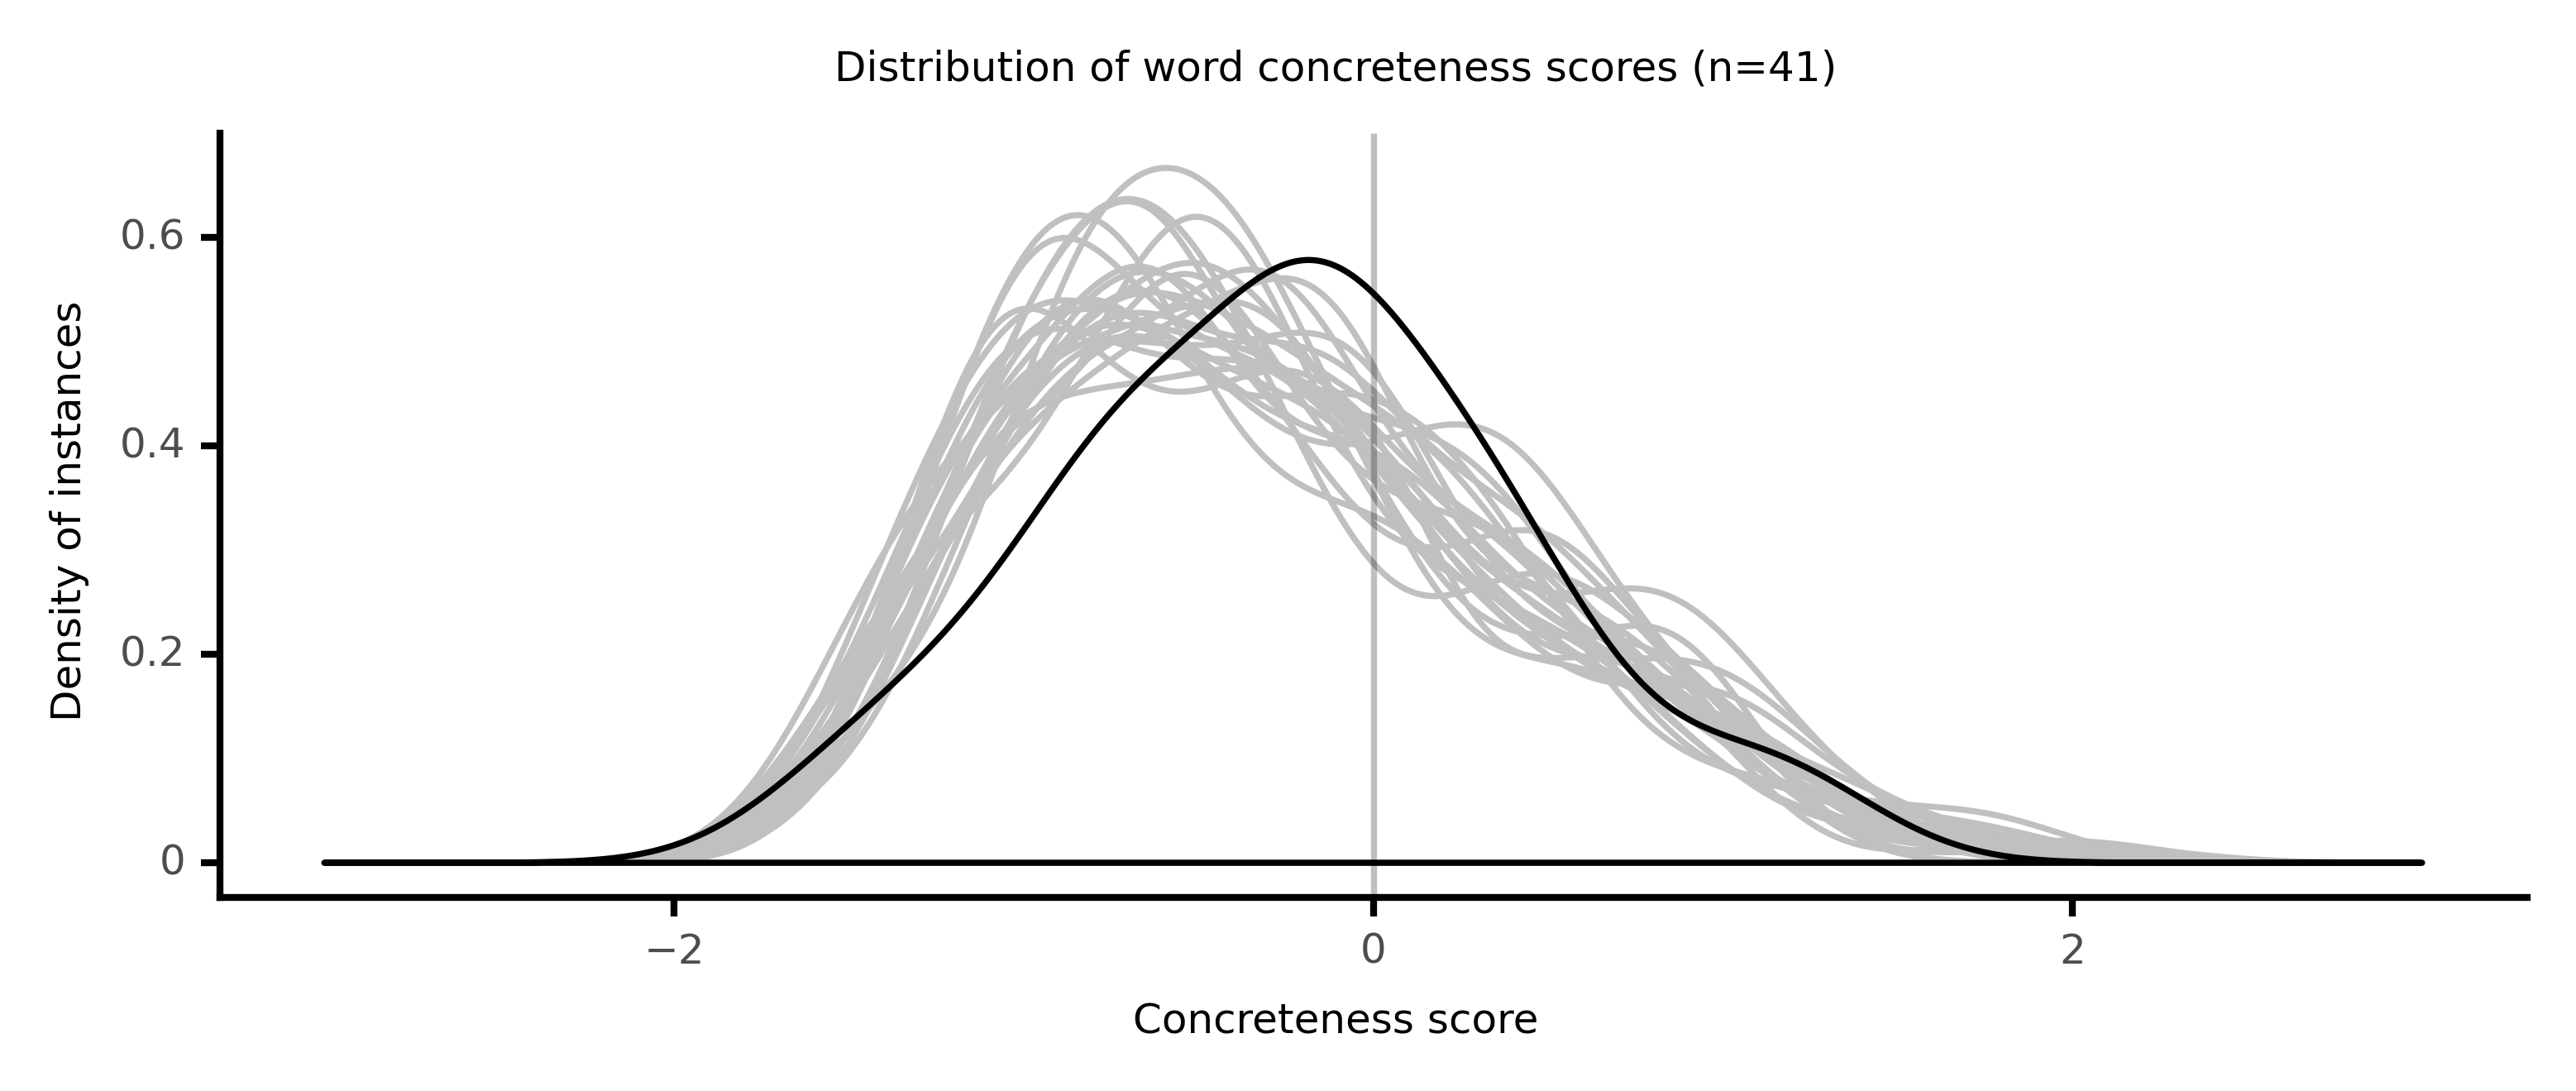

<ggplot: (8742832922417)>

In [12]:
txt='''
She opened the parlour door, and saw two gentlemen sitting with her father-- Mr. Weston and his son. They had been arrived only a few minutes, and Mr. Weston had scarcely finished his explanation of Frank's being a day before his time, and her father was yet in the midst of his very civil welcome and congratulations, when she appeared, to have her share of surprize, introduction, and pleasure.
The Frank Churchill so long talked of, so high in interest, was actually before her-- he was presented to her, and she did not think too much had been said in his praise; he was a very good looking young man; height, air, address, all were unexceptionable, and his countenance had a great deal of the spirit and liveliness of his father's; he looked quick and sensible. She felt immediately that she should like him; and there was a well-bred ease of manner, and a readiness to talk, which convinced her that he came intending to be acquainted with her, and that acquainted they soon must be.
'''
df=showpsg(txt,'Frank Churchill, from Jane Austen, _Emma_ (1815)',
          other_txt=C.au.Austen.EmmaANovelInThreeVolume.txt,
          periods={'C18','C19'})

#### Willoughby, from Austen, _Sense and Sensibility_ (1811)

<p>
 Elinor and her mother <conc><conc812>rose</conc812></conc> up in <neither><conc387>amazement</conc387></neither> at their <conc><conc787>entrance</conc787></conc>, and while the <neither><conc577>eyes</conc577></neither> of both were <neither><conc368>fixed</conc368></neither> on him with an <abs><conc062>evident</conc062></abs> wonder and a <abs><conc210>secret</conc210></abs> <abs><conc190>admiration</conc190></abs> which <abs><conc073>equally</conc073></abs> <neither><conc572>sprung</conc572></neither> from his <neither><conc450>appearance</conc450></neither>, he <neither><conc347>apologized</conc347></neither> for his <neither><conc245>intrusion</conc245></neither> by <abs><conc154>relating</conc154></abs> its cause, in a manner so frank and so <neither><conc698>graceful</conc698></neither> that his person, which was <neither><conc581>uncommonly</conc581></neither> <conc><conc859>handsome</conc859></conc>, <neither><conc222>received</conc222></neither> <neither><conc262>additional</conc262></neither> <neither><conc485>charms</conc485></neither> from his <neither><conc314>voice</conc314></neither> and <abs><conc159>expression</conc159></abs>. 
... 
 His <abs><conc220>manly</conc220></abs> <neither><conc459>beauty</conc459></neither> and more than <abs><conc217>common</conc217></abs> <neither><conc321>gracefulness</conc321></neither> were <neither><conc514>instantly</conc514></neither> the <neither><conc245>theme</conc245></neither> of <abs><conc093>general</conc093></abs> <abs><conc190>admiration</conc190></abs>, and the <neither><conc448>laugh</conc448></neither> which his <neither><conc264>gallantry</conc264></neither> <neither><conc382>raised</conc382></neither> against Marianne <neither><conc222>received</conc222></neither> particular <abs><conc014>spirit</conc014></abs> from his <neither><conc450>exterior</conc450></neither> <neither><conc297>attractions</conc297></neither>. 
</p>

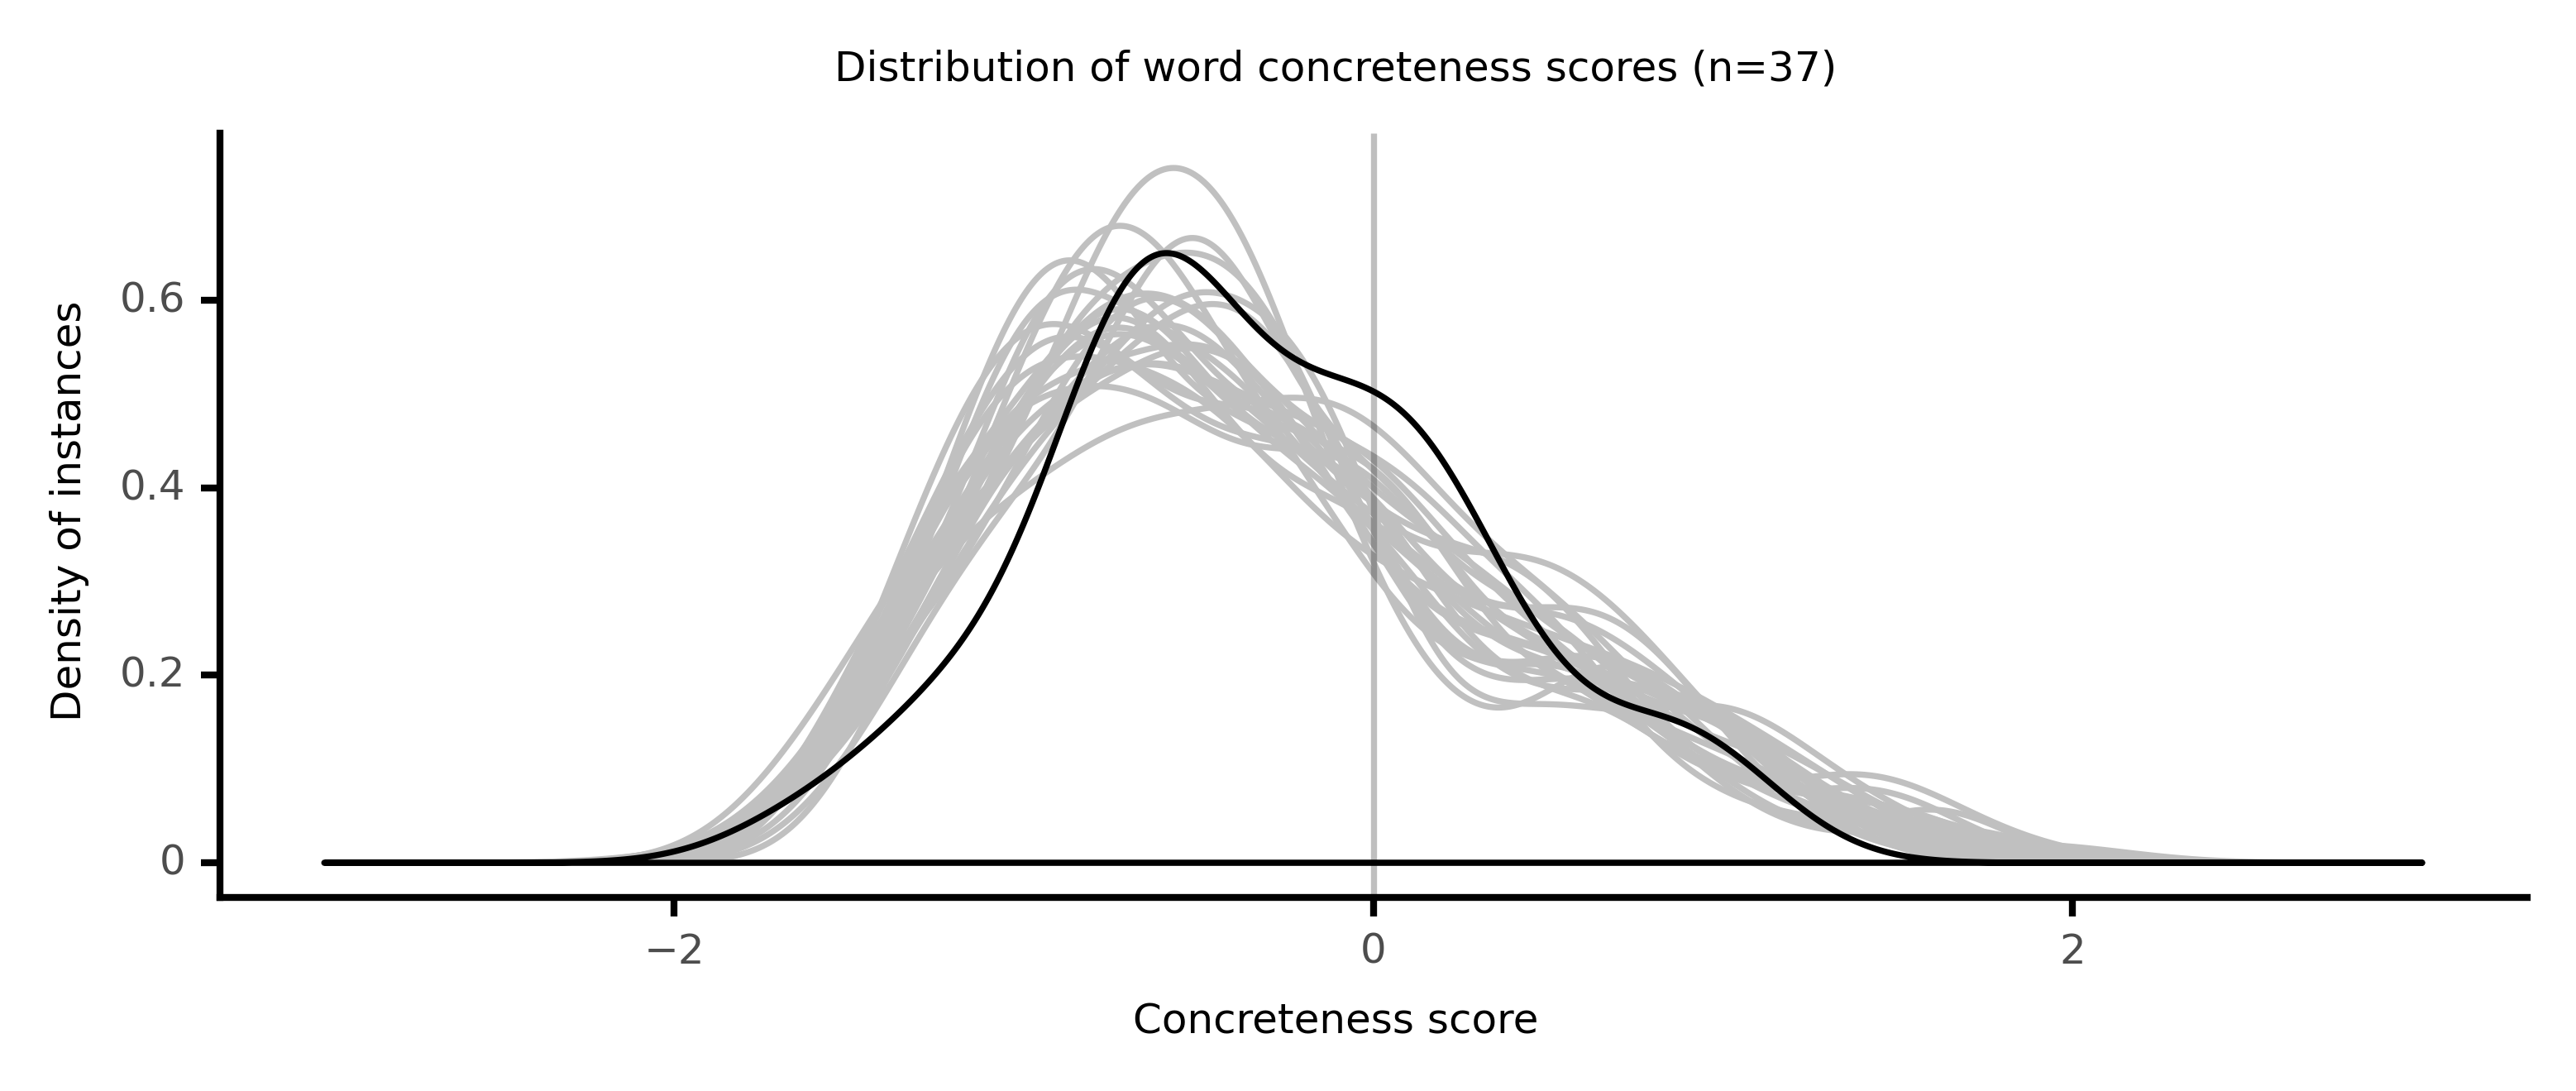

<ggplot: (8742810080377)>

In [13]:
txt="""
Elinor and her mother rose up in amazement at their entrance, and while the eyes of both were fixed on him with an evident wonder and a secret admiration which equally sprung from his appearance, he apologized for his intrusion by relating its cause, in a manner so frank and so graceful that his person, which was uncommonly handsome, received additional charms from his voice and expression. 
...
His manly beauty and more than common gracefulness were instantly the theme of general admiration, and the laugh which his gallantry raised against Marianne received particular spirit from his exterior attractions.
"""

df=showpsg(txt,
           title='Willoughby, from Austen, _Sense and Sensibility_ (1811)',
          other_txt=C.au.Austen.SenseAndSensibilityANovel.txt,
          periods={'C18','C19'})

#### ‘Ryan’, from Rachel Cusk, _Outline_ (2014)

<p>
 At the <conc><conc832>table</conc832></conc> he <conc><conc797>sat</conc797></conc>, like the other men, with his back to the <neither><conc723>wall</conc723></neither> so that his 
 <abs><conc079>view</conc079></abs> was of the café and the <conc><conc732>street</conc732></conc>. I <conc><conc797>sat</conc797></conc> <neither><conc622>opposite</conc622></neither> him, and because he was all 
 I could see I <neither><conc610>looked</conc610></neither> at him.... He had <neither><conc545>large</conc545></neither> <conc><conc732>white</conc732></conc> <conc><conc762>teeth</conc762></conc> which he kept always a 
 little <conc><conc747>bared</conc747></conc> and a <conc><conc746>loose</conc746></conc> body <neither><conc721>poised</conc721></neither> somewhere between <neither><conc528>muscle</conc528></neither> and <conc><conc790>fat</conc790></conc>, but his 
 <neither><conc651>head</conc651></neither> was <neither><conc649>small</conc649></neither> and <neither><conc611>narrow</conc611></neither>, with <conc><conc809>sparse</conc809></conc>, almost <neither><conc632>colourless</conc632></neither> <conc><conc899>hair</conc899></conc> that <neither><conc479>grew</conc479></neither> in 
 <conc><conc979>spikes</conc979></conc> back from his <conc><conc857>forehead</conc857></conc> and <neither><conc632>colourless</conc632></neither> <conc><conc902>eyelashes</conc902></conc> that were <neither><conc576>hidden</conc576></neither> for now 
 behind <conc><conc801>dark</conc801></conc> <conc><conc926>glasses</conc926></conc>. His <conc><conc746>eyebrows</conc746></conc>, however, were <neither><conc343>fierce</conc343></neither> and <neither><conc710>straight</conc710></neither> and <neither><conc692>black</conc692></neither>. 
 When the <conc><conc973>waitress</conc973></conc> came he took the <conc><conc926>glasses</conc926></conc> off and I saw his <neither><conc577>eyes</conc577></neither>, two <neither><conc649>small</conc649></neither> 
 <conc><conc763>bright</conc763></conc> <conc><conc922>blue</conc922></conc> <conc><conc891>chips</conc891></conc> in slightly <neither><conc717>reddened</conc717></neither> <neither><conc478>whites</conc478></neither>. 
</p>

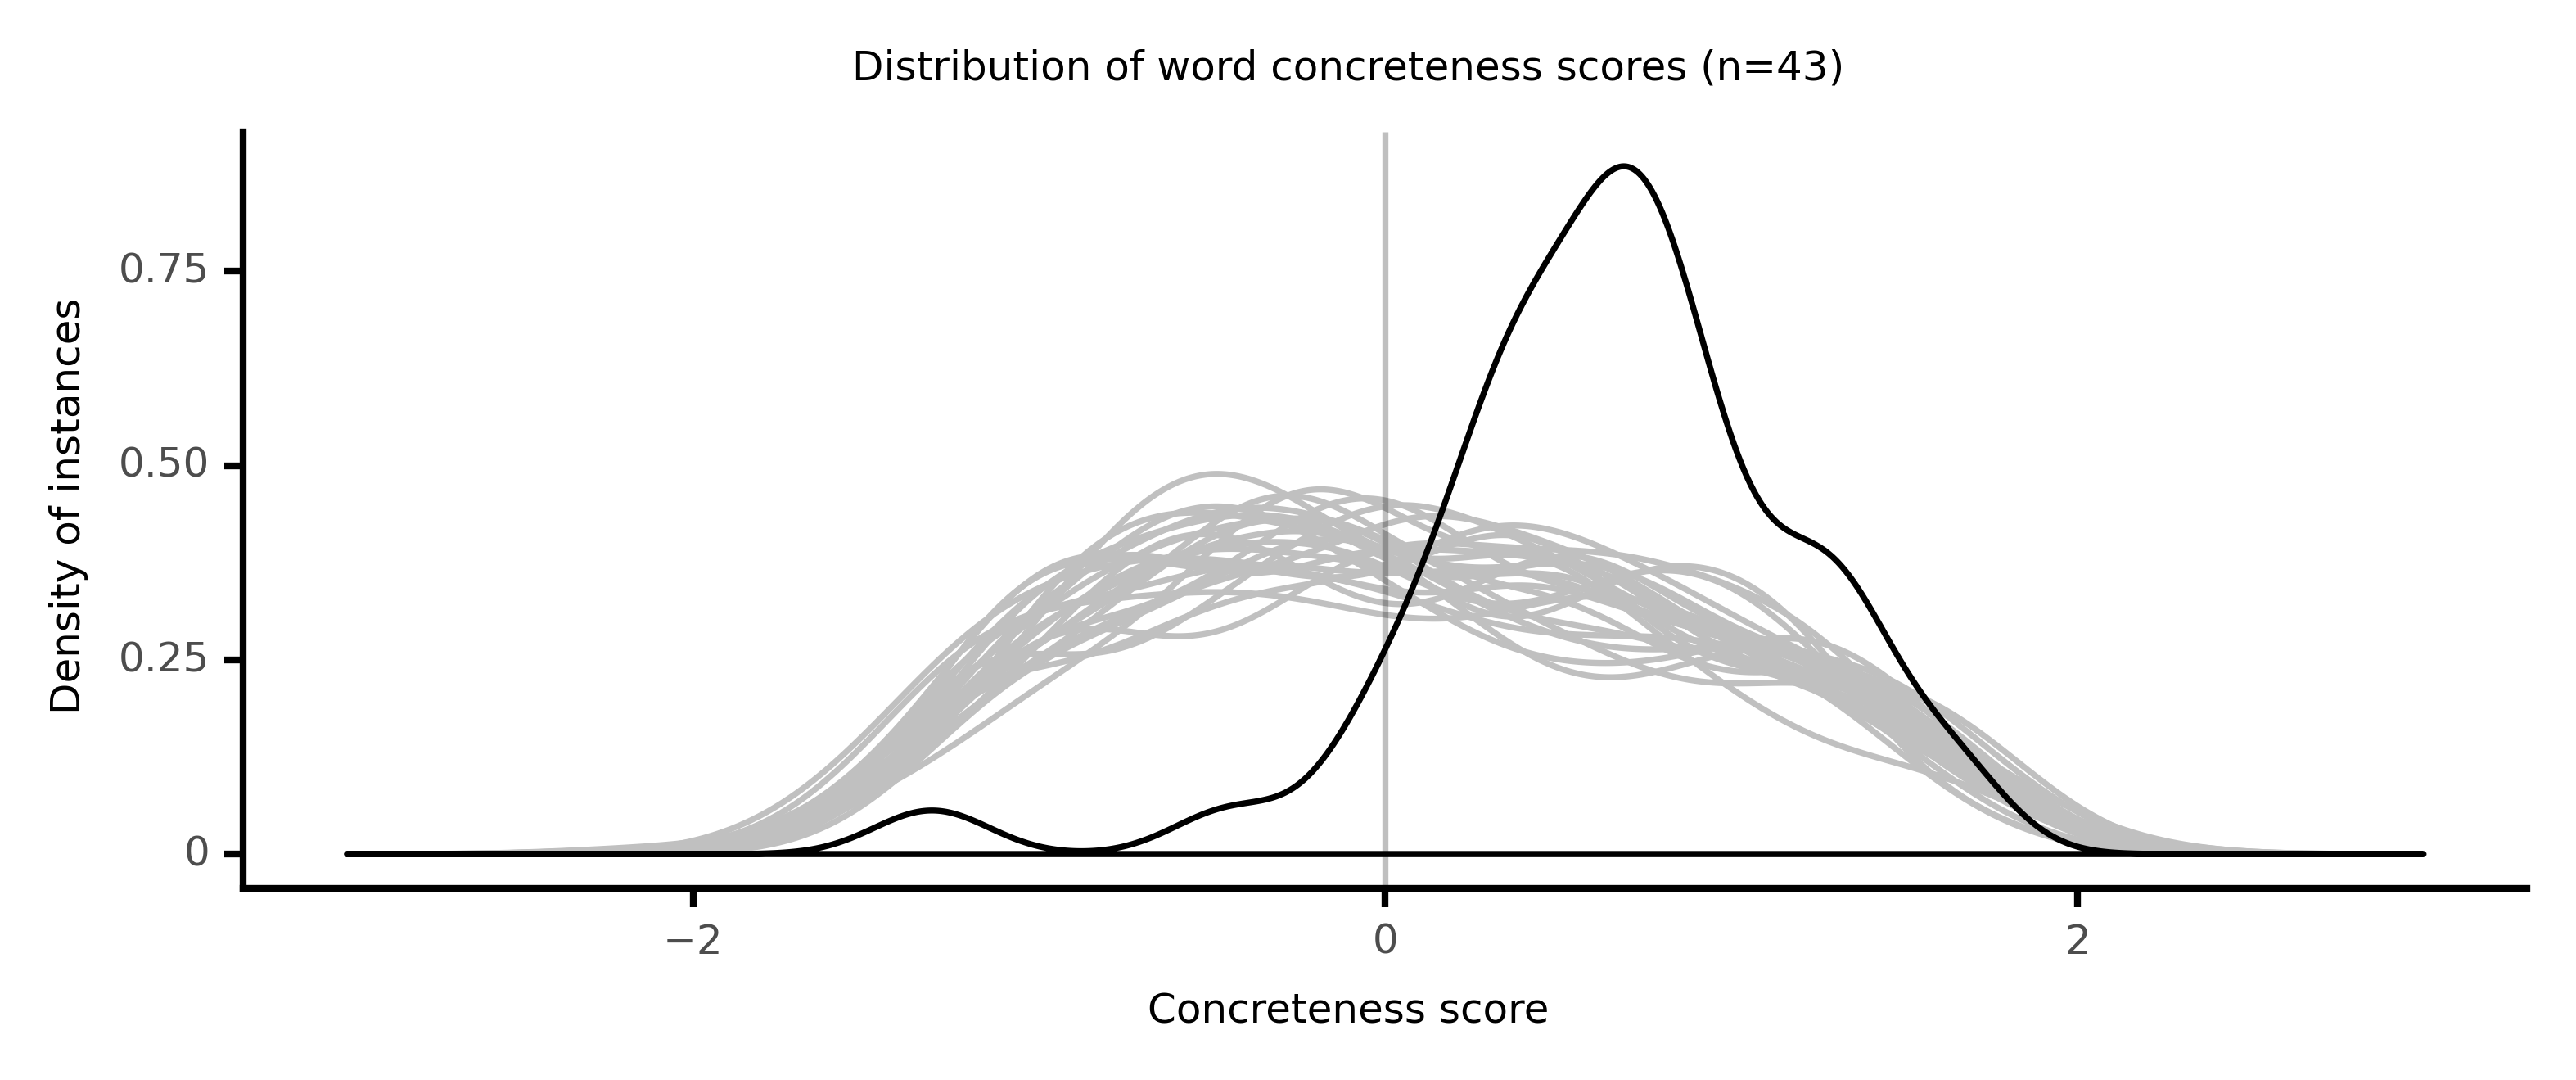

<ggplot: (8742829141873)>

In [14]:
txt="""
At the table he sat, like the other men, with his back to the wall so that his 
view was of the café and the street. I sat opposite him, and because he was all 
I could see I looked at him. ... He had large white teeth which he kept always a 
little bared and a loose body poised somewhere between muscle and fat, but his 
head was small and narrow, with sparse, almost colourless hair that grew in 
spikes back from his forehead and colourless eyelashes that were hidden for now 
behind dark glasses. His eyebrows, however, were fierce and straight and black. 
When the waitress came he took the glasses off and I saw his eyes, two small 
bright blue chips in slightly reddened whites.
"""
df=showpsg(
    txt,
    "‘Ryan’, from Rachel Cusk, _Outline_ (2014)",
    other_txt=C.au.Cusk.Outline.txt,
    periods={'C20'}
)

In [15]:
#### 

#### ‘Ryan’, from Rachel Cusk, _Outline_ (2014)

<p>
 At the <conc><conc832>table</conc832></conc> he <conc><conc797>sat</conc797></conc>, like the other men, with his back to the <neither><conc723>wall</conc723></neither> so that his 
 <abs><conc079>view</conc079></abs> was of the café and the <conc><conc732>street</conc732></conc>. I <conc><conc797>sat</conc797></conc> <neither><conc622>opposite</conc622></neither> him, and because he was all 
 I could see I <neither><conc610>looked</conc610></neither> at him. Ryan was <abs><conc190>teaching</conc190></abs> alongside me at the <neither><conc642>summer</conc642></neither> 
 <neither><conc398>school</conc398></neither>: from a <neither><conc583>distance</conc583></neither> he was a man of <abs><conc215>conventional</conc215></abs> sandy-coloured good 
 looks, but <neither><conc371>close</conc371></neither> up there was something <neither><conc281>uneasy</conc281></neither> in his <neither><conc339>appearance</conc339></neither>, as though he 
 had been put together out of <abs><conc152>unrelated</conc152></abs> <abs><conc139>elements</conc139></abs>, so that the different <neither><conc479>parts</conc479></neither> of 
 him did n't entirely go together. He had <neither><conc545>large</conc545></neither> <conc><conc732>white</conc732></conc> <conc><conc762>teeth</conc762></conc> which he kept always a 
 little <conc><conc747>bared</conc747></conc> and a <conc><conc746>loose</conc746></conc> body <neither><conc721>poised</conc721></neither> somewhere between <neither><conc528>muscle</conc528></neither> and <conc><conc790>fat</conc790></conc>, but his 
 <neither><conc651>head</conc651></neither> was <neither><conc649>small</conc649></neither> and <neither><conc611>narrow</conc611></neither>, with <conc><conc809>sparse</conc809></conc>, almost <neither><conc632>colourless</conc632></neither> <conc><conc899>hair</conc899></conc> that <neither><conc479>grew</conc479></neither> in 
 <conc><conc979>spikes</conc979></conc> back from his <conc><conc857>forehead</conc857></conc> and <neither><conc632>colourless</conc632></neither> <conc><conc902>eyelashes</conc902></conc> that were <neither><conc576>hidden</conc576></neither> for now 
 behind <conc><conc801>dark</conc801></conc> <conc><conc926>glasses</conc926></conc>. His <conc><conc746>eyebrows</conc746></conc>, however, were <neither><conc343>fierce</conc343></neither> and <neither><conc710>straight</conc710></neither> and <neither><conc692>black</conc692></neither>. 
 When the <conc><conc973>waitress</conc973></conc> came he took the <conc><conc926>glasses</conc926></conc> off and I saw his <neither><conc577>eyes</conc577></neither>, two <neither><conc649>small</conc649></neither> 
 <conc><conc763>bright</conc763></conc> <conc><conc922>blue</conc922></conc> <conc><conc891>chips</conc891></conc> in slightly <neither><conc717>reddened</conc717></neither> <neither><conc478>whites</conc478></neither>. 
</p>

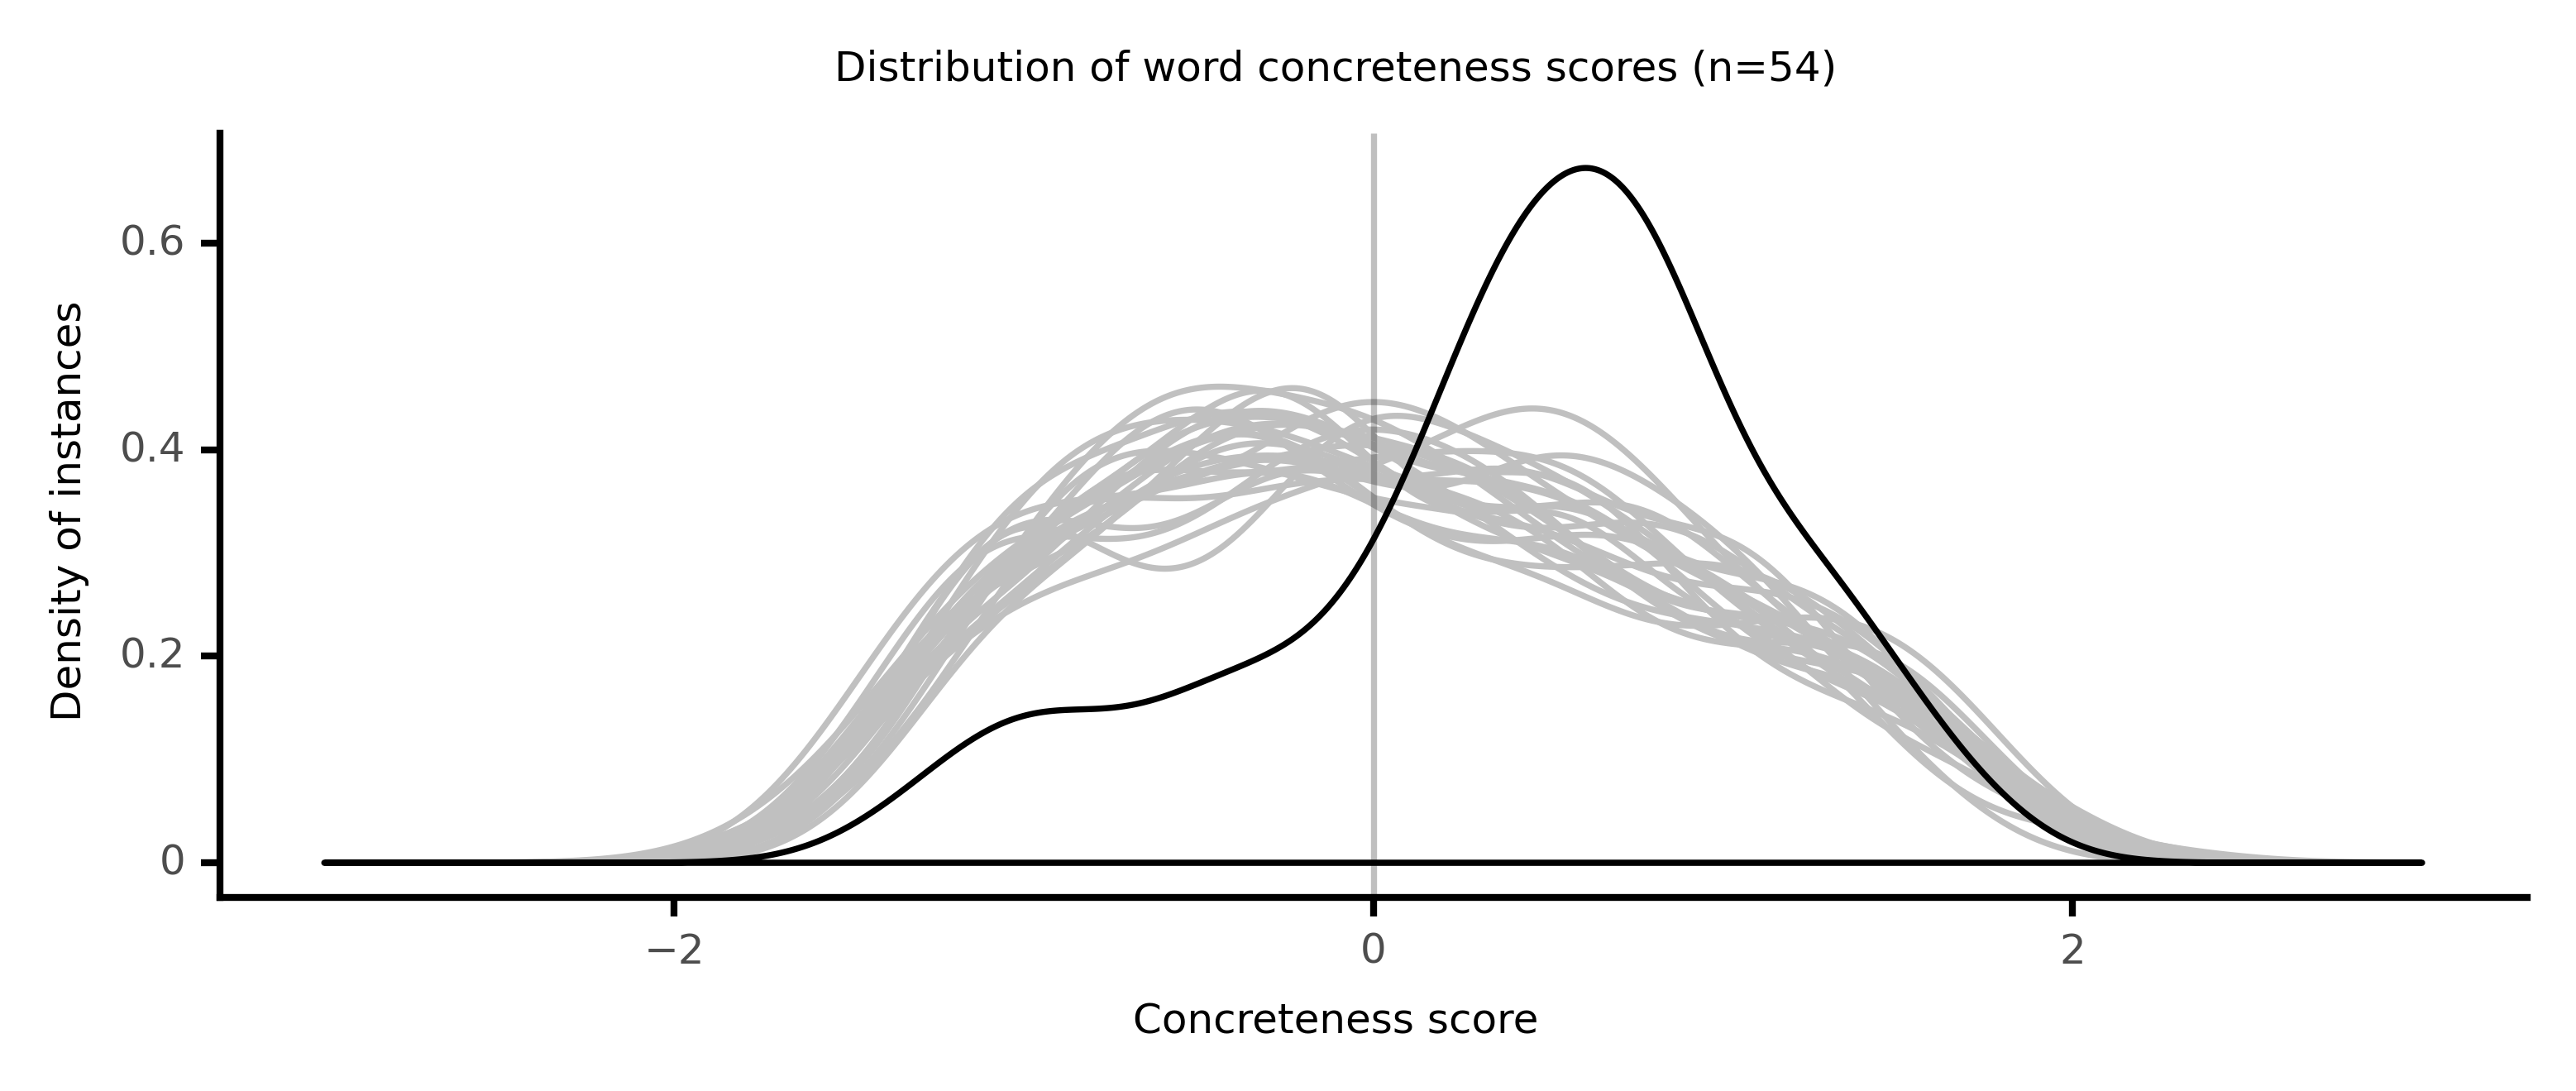

<ggplot: (8742810732409)>

In [16]:
txt="""
At the table he sat, like the other men, with his back to the wall so that his 
view was of the café and the street. I sat opposite him, and because he was all 
I could see I looked at him. Ryan was *teaching* alongside me at the summer 
school: from a distance he was a man of *conventional* sandy-coloured good 
looks, but close up there was something uneasy in his appearance, as though he 
had been put together out of unrelated elements, so that the different parts of 
him didn't entirely go together. He had large white teeth which he kept always a 
little bared and a loose body poised somewhere between muscle and fat, but his 
head was small and narrow, with sparse, almost colourless hair that grew in 
spikes back from his forehead and colourless eyelashes that were hidden for now 
behind dark glasses. His eyebrows, however, were fierce and straight and black. 
When the waitress came he took the glasses off and I saw his eyes, two small 
bright blue chips in slightly reddened whites.
"""
df=showpsg(
    txt,
    "‘Ryan’, from Rachel Cusk, _Outline_ (2014)",
    other_txt=C.au.Cusk.Outline.txt,
    periods={'C20'}
)

#### Dorothea, from George Eliot, _Middlemarch_ (1874)

<p>
 Miss Brooke had that <neither><conc265>kind</conc265></neither> of <neither><conc435>beauty</conc435></neither> which seems to be <neither><conc562>thrown</conc562></neither> into <neither><conc277>relief</conc277></neither> by <neither><conc439>poor</conc439></neither> 
 <conc><conc860>dress</conc860></conc>. Her <neither><conc486>hand</conc486></neither> and <conc><conc914>wrist</conc914></conc> were so <conc><conc782>finely</conc782></conc> <neither><conc509>formed</conc509></neither> that she could <neither><conc707>wear</conc707></neither> <conc><conc966>sleeves</conc966></conc> not 
 less <conc><conc737>bare</conc737></conc> of <neither><conc373>style</conc373></neither> than those in which the Blessed Virgin <neither><conc444>appeared</conc444></neither> to Italian 
 <neither><conc429>painters</conc429></neither>; and her <conc><conc767>profile</conc767></conc> as well as her <neither><conc483>stature</conc483></neither> and <neither><conc462>bearing</conc462></neither> seemed to <abs><conc100>gain</conc100></abs> the 
 more <abs><conc163>dignity</conc163></abs> from her <neither><conc494>plain</conc494></neither> <conc><conc864>garments</conc864></conc>,... She was usually spoken 
 of as being <neither><conc554>remarkably</conc554></neither> <neither><conc468>clever</conc468></neither>, but with the addition that her sister Celia had 
 more <abs><conc075>common-sense</conc075></abs>. Nevertheless, Celia <conc><conc781>wore</conc781></conc> <neither><conc372>scarcely</conc372></neither> more <conc><conc994>trimmings</conc994></conc>; and it was 
 only to <neither><conc531>close</conc531></neither> <abs><conc171>observers</conc171></abs> that her <conc><conc860>dress</conc860></conc> <abs><conc209>differed</conc209></abs> from her sister's, and had a 
 <neither><conc714>shade</conc714></neither> of <neither><conc472>coquetry</conc472></neither> in its <neither><conc383>arrangements</conc383></neither>; for Miss Brooke's <neither><conc494>plain</conc494></neither> <conc><conc963>dressing</conc963></conc> was due 
 to <neither><conc556>mixed</conc556></neither> <abs><conc111>conditions</conc111></abs>, in most of which her sister <abs><conc214>shared</conc214></abs>. 
</p>

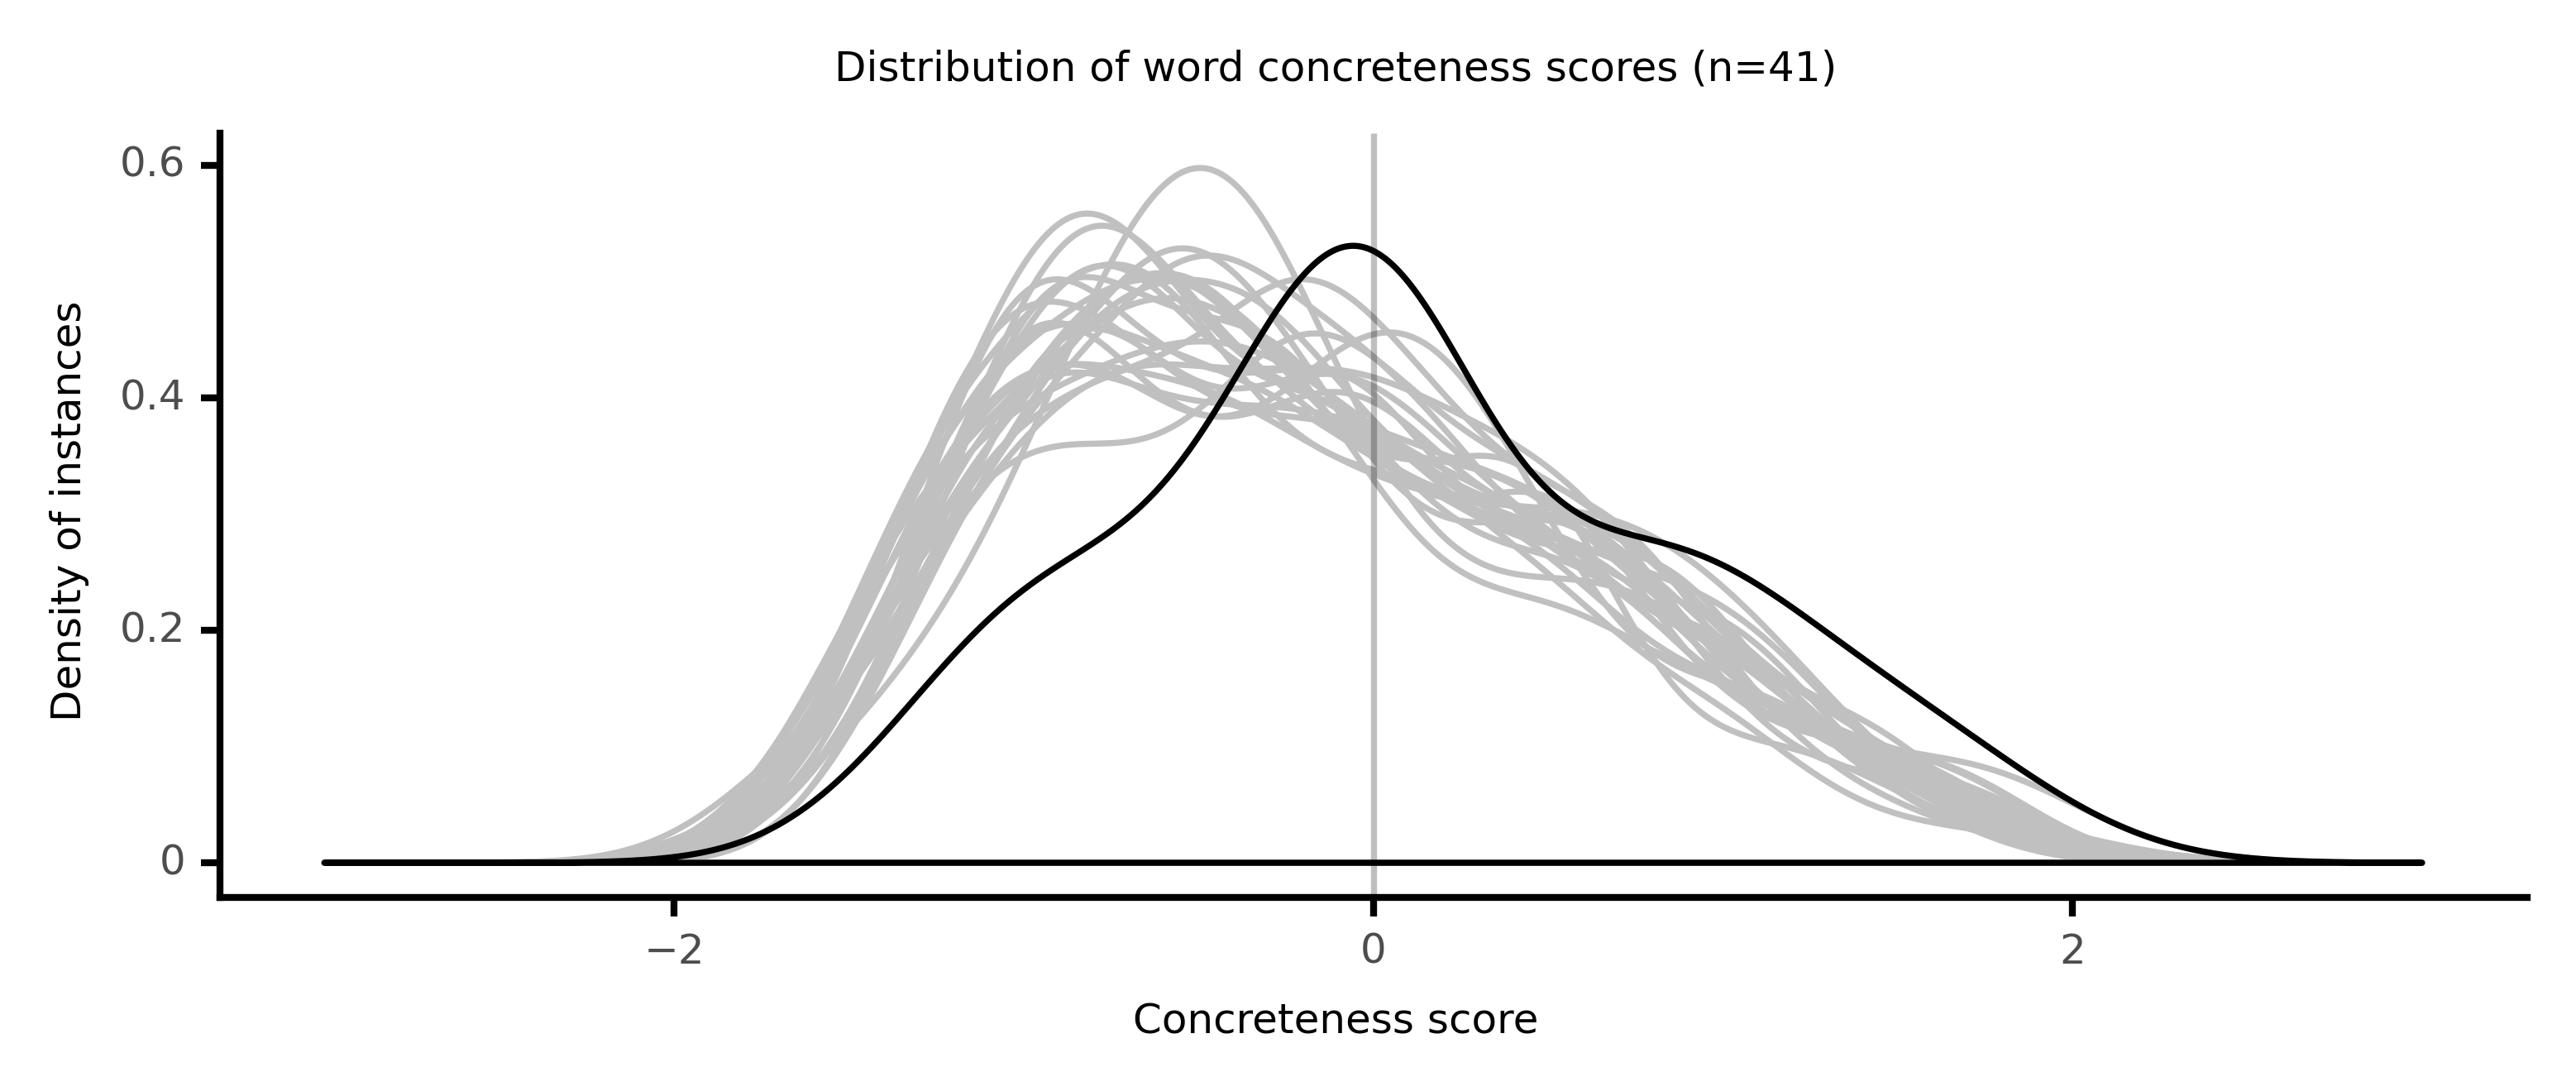

<ggplot: (8742811056449)>

In [17]:
txt="""
Miss Brooke had that kind of beauty which seems to be thrown into relief by poor 
dress. Her hand and wrist were so finely formed that she could wear sleeves not 
less bare of style than those in which the Blessed Virgin appeared to Italian 
painters; and her profile as well as her stature and bearing seemed to gain the 
more dignity from her plain garments, ... She was usually spoken 
of as being remarkably clever, but with the addition that her sister Celia had 
more common-sense. Nevertheless, Celia wore scarcely more trimmings; and it was 
only to close observers that her dress differed from her sister's, and had a 
shade of coquetry in its arrangements; for Miss Brooke's plain dressing was due 
to mixed conditions, in most of which her sister shared.
"""
showpsg(
    txt,
    'Dorothea, from George Eliot, _Middlemarch_ (1874)',
    C.au.Eliot.MiddlemarchAStudyOfProvin.txt,
    stopwords={'blessed','virgin','bible'},
    periods={'C19'}
)

#### Will Ladislaw, from George Eliot, _Middlemarch_ (1874)

<p>
 The cousin was so <neither><conc531>close</conc531></neither> now, that, when he <conc><conc778>lifted</conc778></conc> his <conc><conc904>hat</conc904></conc>, Dorothea could see a 
 <conc><conc932>pair</conc932></conc> of <conc><conc854>gray</conc854></conc> <neither><conc558>eyes</conc558></neither> rather near together, a <neither><conc700>delicate</conc700></neither> <neither><conc549>irregular</conc549></neither> <conc><conc887>nose</conc887></conc> with a little 
 <conc><conc832>ripple</conc832></conc> in it, and <conc><conc944>hair</conc944></conc> <neither><conc672>falling</conc672></neither> <neither><conc587>backward</conc587></neither>; but there was a <conc><conc804>mouth</conc804></conc> and <conc><conc891>chin</conc891></conc> of a 
 more <neither><conc330>prominent</conc330></neither>, <neither><conc324>threatening</conc324></neither> <neither><conc289>aspect</conc289></neither> than <neither><conc456>belonged</conc456></neither> to the <neither><conc388>type</conc388></neither> of the 
 grandmother's <conc><conc898>miniature</conc898></conc>. <neither><conc594>Young</conc594></neither> Ladislaw did not feel it necessary to <neither><conc529>smile</conc529></neither>, as 
 if he were <neither><conc488>charmed</conc488></neither> with this <neither><conc281>introduction</conc281></neither> to his <abs><conc066>future</conc066></abs> second cousin and her 
 <neither><conc466>relatives</conc466></neither>; but <conc><conc781>wore</conc781></conc> rather a <conc><conc900>pouting</conc900></conc> <neither><conc638>air</conc638></neither> of <abs><conc111>discontent</conc111></abs>. 
</p>

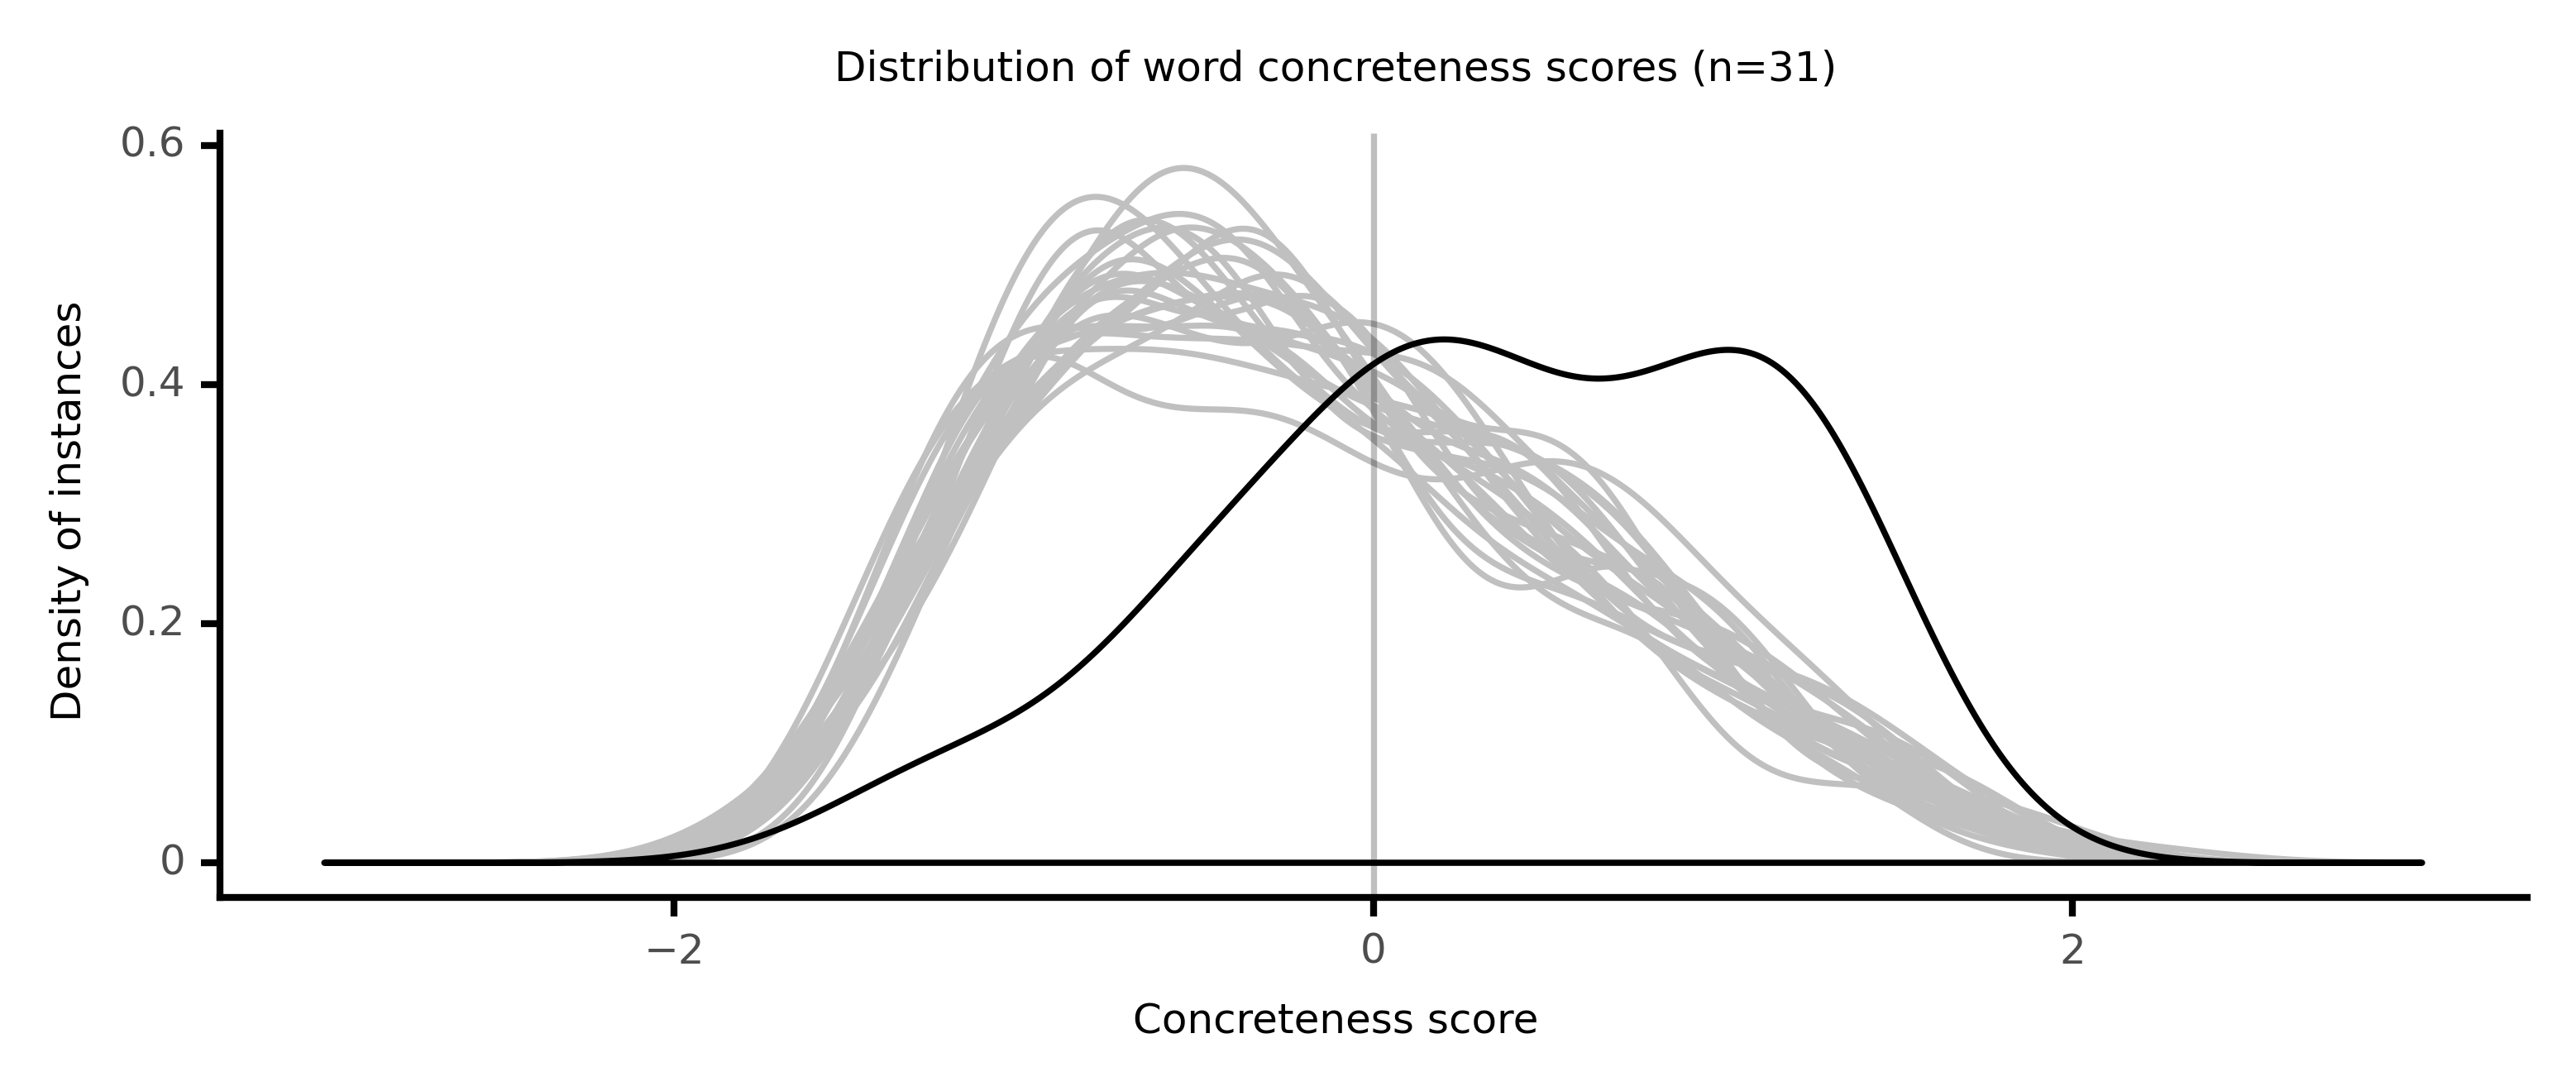

<ggplot: (8742809336593)>

In [18]:
txt="""
The cousin was so close now, that, when he lifted his hat, Dorothea could see a 
pair of gray eyes rather near together, a delicate irregular nose with a little 
ripple in it, and hair falling backward; but there was a mouth and chin of a 
more prominent, threatening aspect than belonged to the type of the 
grandmother’s miniature. Young Ladislaw did not feel it necessary to smile, as 
if he were charmed with this introduction to his future second cousin and her 
relatives; but wore rather a pouting air of discontent.
"""
showpsg(
    txt,
    'Will Ladislaw, from George Eliot, _Middlemarch_ (1874)',
    C.au.Eliot.MiddlemarchAStudyOfProvin.txt,
#     stopwords={'blessed','virgin','bible'},
    periods={'C19'}
)

#### Richard

<p>The <neither><conc594>young</conc594></neither> <neither><conc481>gentleman</conc481></neither> was her <neither><conc501>distant</conc501></neither> cousin, she told me, and his name Richard Carstone. He was a <conc><conc831>handsome</conc831></conc> <abs><conc237>youth</conc237></abs> with an <abs><conc222>ingenuous</conc222></abs> <neither><conc566>face</conc566></neither> and a most <abs><conc238>engaging</conc238></abs> <neither><conc565>laugh</conc565></neither>; and after she had <neither><conc463>called</conc463></neither> him up to where we <conc><conc813>sat</conc813></conc>, he <neither><conc669>stood</conc669></neither> by us, in the <neither><conc532>light</conc532></neither> of the fire, <neither><conc582>talking</conc582></neither> <conc><conc922>gaily</conc922></conc>, like a <neither><conc494>light-hearted</conc494></neither> boy. He was very <neither><conc594>young</conc594></neither>, not more than nineteen then, if quite so much, but nearly two years <neither><conc448>older</conc448></neither> than she was. They were both <neither><conc526>orphans</conc526></neither> and( what was very <neither><conc296>unexpected</conc296></neither> and <neither><conc432>curious</conc432></neither> to me) had never <neither><conc367>met</conc367></neither> before that day. Our all three <neither><conc426>coming</conc426></neither> together for the first time in such an <neither><conc335>unusual</conc335></neither> place was a thing to talk about, and we <neither><conc497>talked</conc497></neither> about it; and the fire, which had left off <conc><conc731>roaring</conc731></conc>, <neither><conc671>winked</conc671></neither> its <conc><conc954>red</conc954></conc> <neither><conc558>eyes</conc558></neither> at us-- as Richard said-- like a <neither><conc701>drowsy</conc701></neither> old <neither><conc292>Chancery</conc292></neither> <neither><conc660>lion</conc660></neither>.</p>

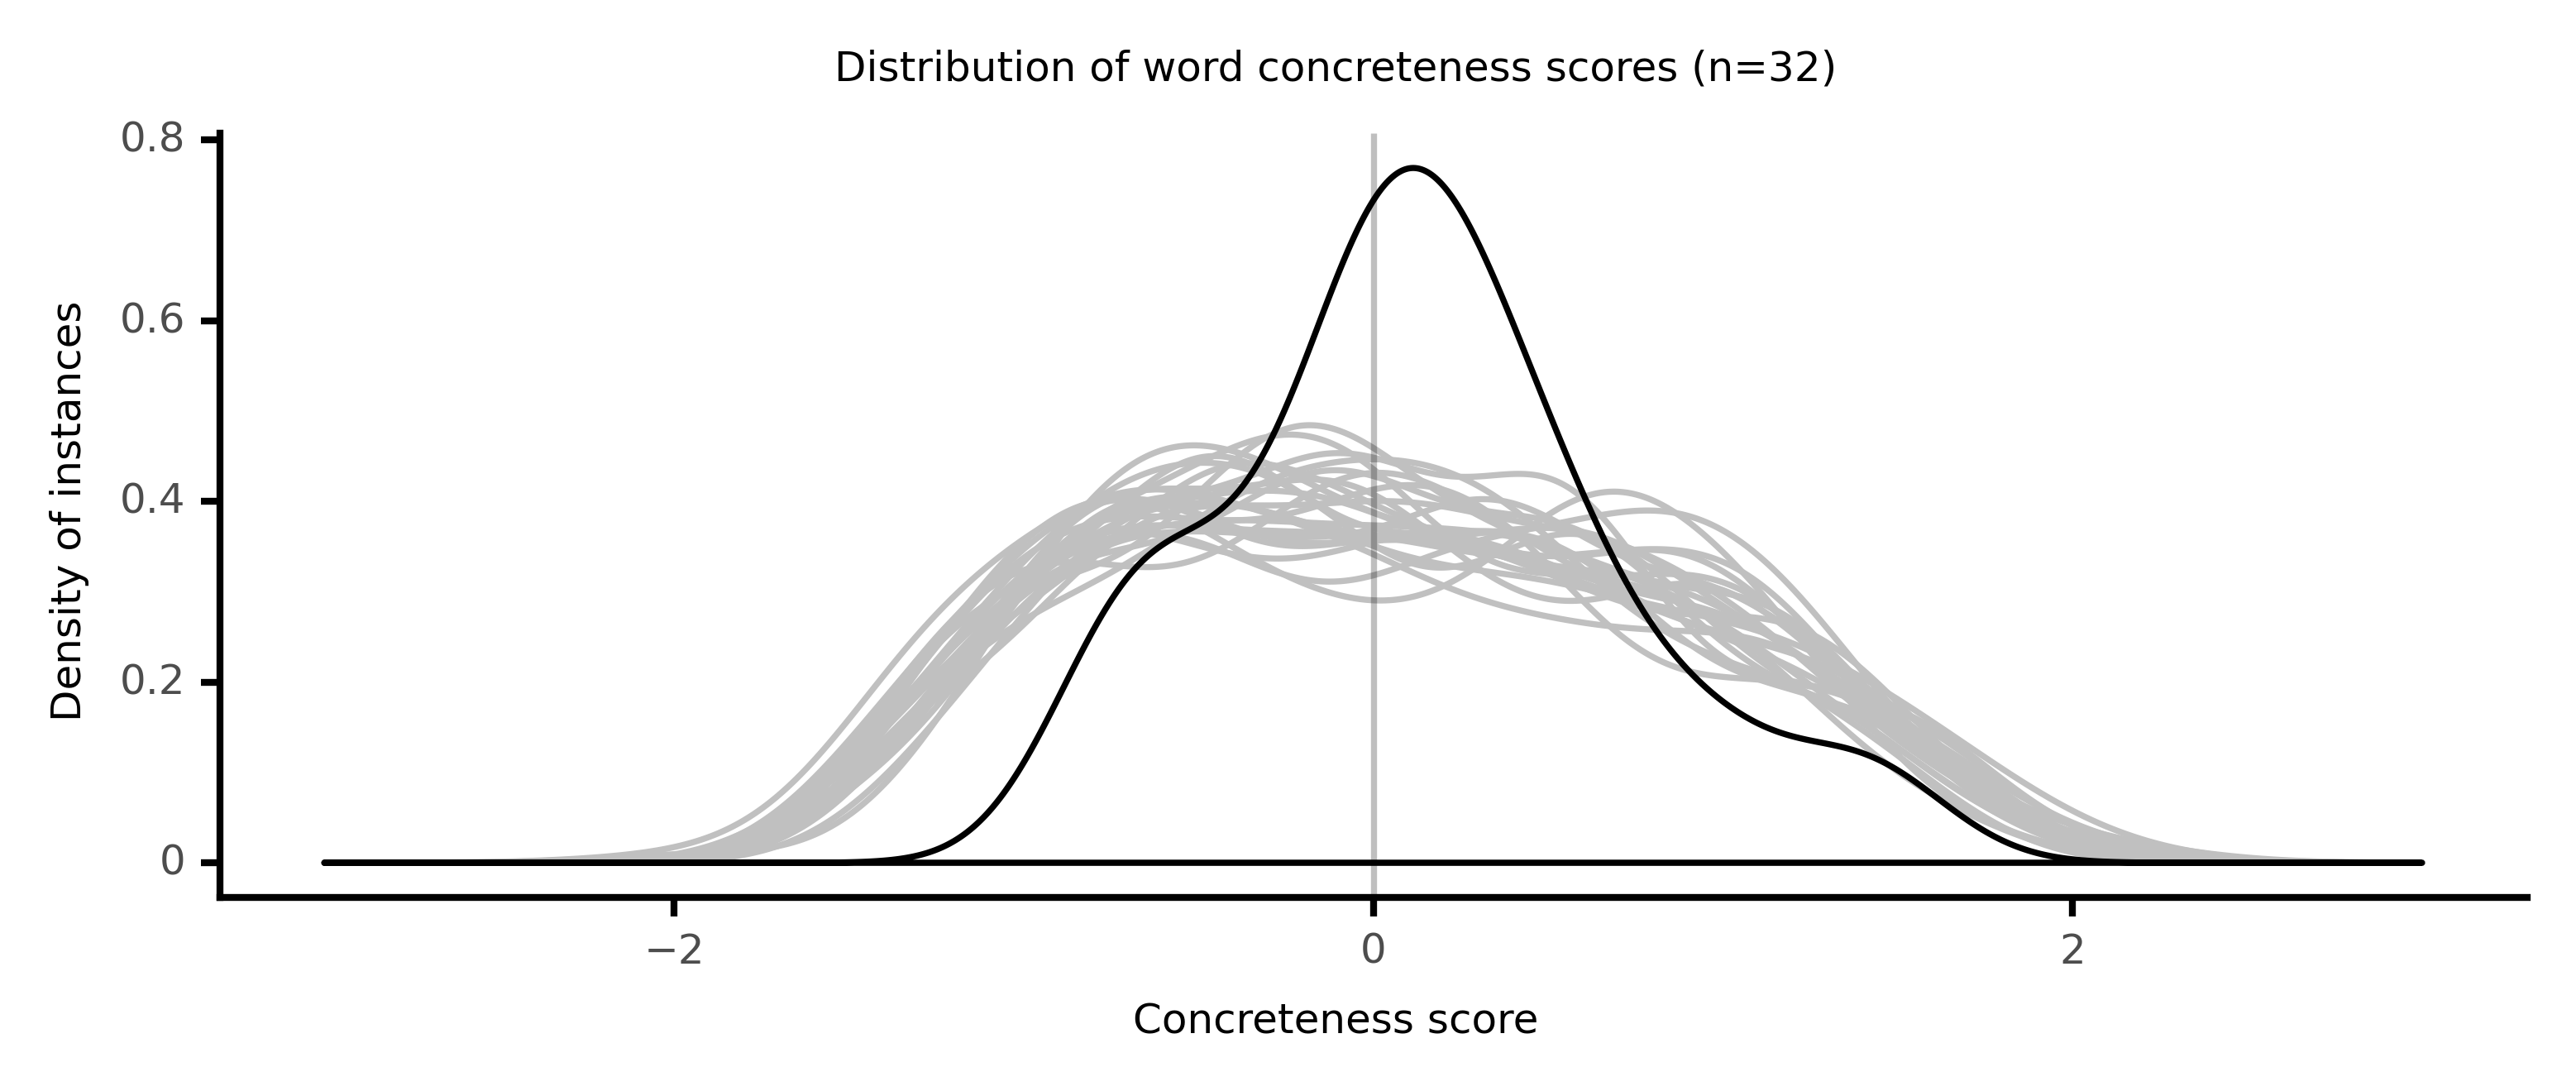

<ggplot: (8742798920953)>

In [19]:
showpsg(
"""The young gentleman was her distant cousin, she told me, and his name Richard Carstone. He was a handsome youth with an ingenuous face and a most engaging laugh; and after she had called him up to where we sat, he stood by us, in the light of the fire, talking gaily, like a light-hearted boy. He was very young, not more than nineteen then, if quite so much, but nearly two years older than she was. They were both orphans and (what was very unexpected and curious to me) had never met before that day. Our all three coming together for the first time in such an unusual place was a thing to talk about, and we talked about it; and the fire, which had left off roaring, winked its red eyes at us—as Richard said—like a drowsy old Chancery lion.""",
'Richard',
C.au.Dickens.BleakHouseByCharlesDicken.txt,
periods={'C19'}   
)

#### Tilney, from Austen, _Northanger Abbey_ (1817)

<p>They made their <neither><conc450>appearance</conc450></neither> in the <neither><conc680>Lower</conc680></neither> <conc><conc897>Rooms</conc897></conc>; and here <neither><conc283>fortune</conc283></neither> was more 
 <abs><conc132>favourable</conc132></abs> to our <neither><conc492>heroine</conc492></neither>. The master of the <neither><conc261>ceremonies</conc261></neither> <neither><conc317>introduced</conc317></neither> to her a very 
 <neither><conc238>gentlemanlike</conc238></neither> <neither><conc641>young</conc641></neither> man as a <neither><conc452>partner</conc452></neither>; his name was Tilney. He seemed to be about 
 four or five and twenty, was rather <conc><conc930>tall</conc930></conc>, had a <neither><conc314>pleasing</conc314></neither> <neither><conc344>countenance</conc344></neither>, a very 
 <abs><conc085>intelligent</conc085></abs> and <neither><conc425>lively</conc425></neither> <neither><conc523>eye</conc523></neither>, and, if not quite <conc><conc859>handsome</conc859></conc>, was very near it. His 
 <abs><conc186>address</conc186></abs> was good, and Catherine felt herself in <neither><conc447>high</conc447></neither> <neither><conc501>luck</conc501></neither>. There was little 
 <neither><conc235>leisure</conc235></neither> for speaking while they <conc><conc854>danced</conc854></conc>; but when they were <conc><conc840>seated</conc840></conc> at <conc><conc908>tea</conc908></conc>, she 
 found him as <neither><conc286>agreeable</conc286></neither> as she had already given him <abs><conc088>credit</conc088></abs> for being. He <neither><conc376>talked</conc376></neither> 
 with <abs><conc173>fluency</conc173></abs> and <abs><conc014>spirit</conc014></abs>-- and there was an <neither><conc449>archness</conc449></neither> and <neither><conc259>pleasantry</conc259></neither> in his manner 
 which <abs><conc115>interested</conc115></abs>, though it was hardly <abs><conc085>understood</conc085></abs> by her.</p>

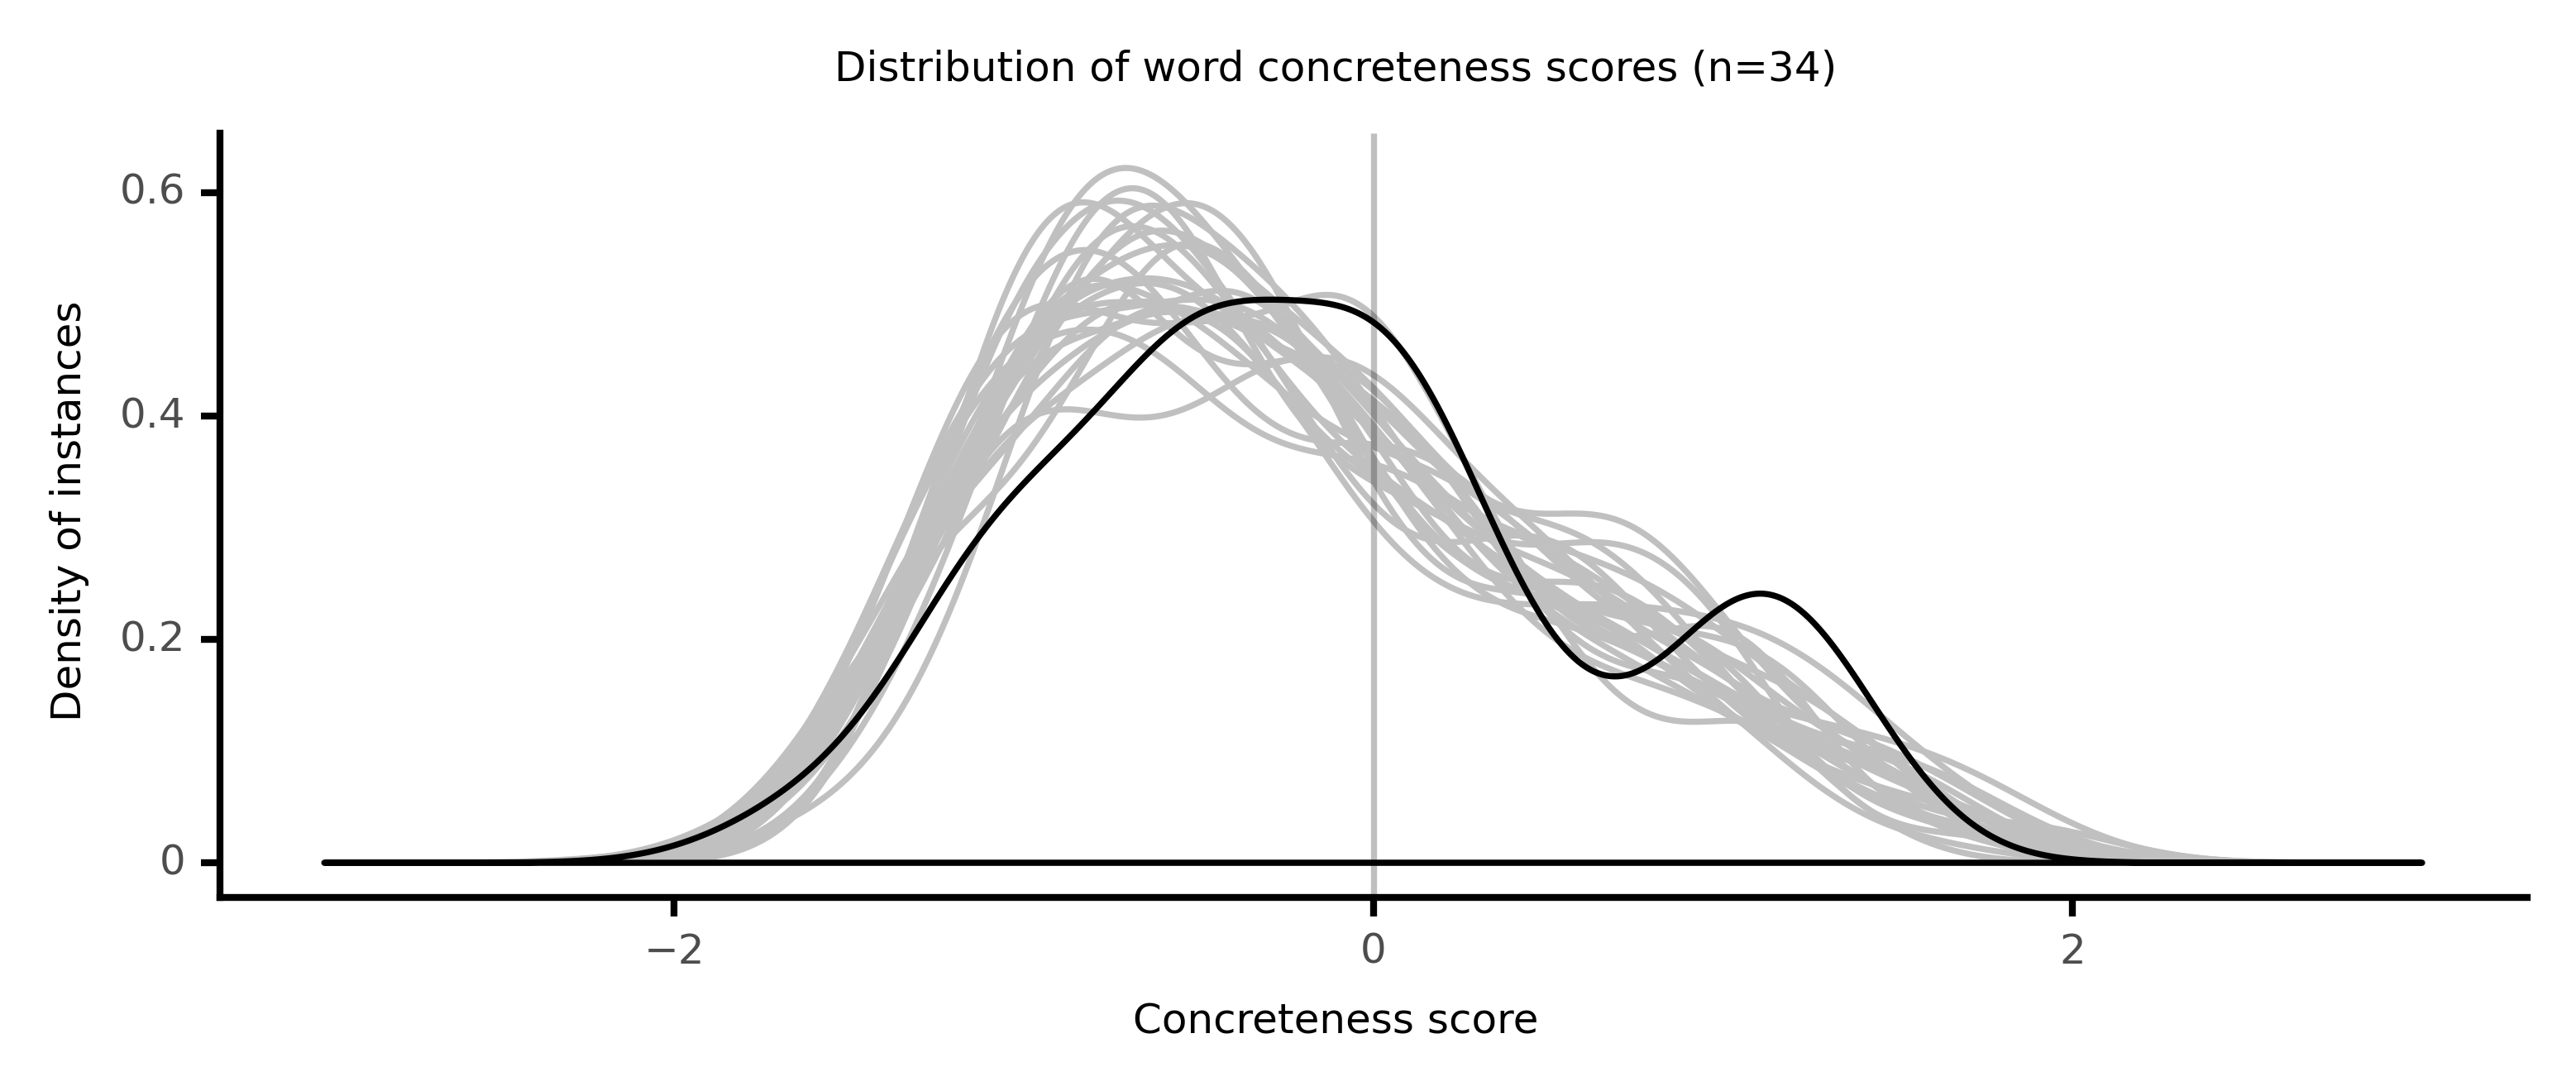

<ggplot: (8742798628725)>

In [20]:
showpsg(
    """They made their appearance in the Lower Rooms; and here fortune was more 
favourable to our heroine. The master of the ceremonies introduced to her a very 
gentlemanlike young man as a partner; his name was Tilney. He seemed to be about 
four or five and twenty, was rather tall, had a pleasing countenance, a very 
intelligent and lively eye, and, if not quite handsome, was very near it. His 
address was good, and Catherine felt herself in high luck. There was little 
leisure for speaking while they danced; but when they were seated at tea, she 
found him as agreeable as she had already given him credit for being. He talked 
with fluency and spirit—and there was an archness and pleasantry in his manner 
which interested, though it was hardly understood by her.""",
    'Tilney, from Austen, _Northanger Abbey_ (1817)',
    C.au.Austen.NorthangerAbbeyAndPersuas.txt,
    periods={'C18','C19'}
)

#### Edward Ferrars, from Austen, _Sense and Sensibility_ (1811)

<p>Edward Ferrars was not <neither><conc232>recommended</conc232></neither> to their good <abs><conc022>opinion</conc022></abs> by any <abs><conc171>peculiar</conc171></abs> <neither><conc414>graces</conc414></neither> 
 of person or <abs><conc186>address</conc186></abs>. He was not <conc><conc859>handsome</conc859></conc>, and his <abs><conc172>manners</conc172></abs> <abs><conc135>required</conc135></abs> <neither><conc234>intimacy</conc234></neither> to 
 make them <neither><conc314>pleasing</conc314></neither>. He was too <abs><conc089>diffident</conc089></abs> to do <abs><conc022>justice</conc022></abs> to himself; but when his 
 <abs><conc065>natural</conc065></abs> <neither><conc251>shyness</conc251></neither> was <abs><conc142>overcome</conc142></abs>, his <abs><conc112>behaviour</conc112></abs> gave every <abs><conc165>indication</conc165></abs> of an <neither><conc498>open</conc498></neither>, 
 <neither><conc311>affectionate</conc311></neither> <neither><conc273>heart</conc273></neither>. His <abs><conc034>understanding</conc034></abs> was good, and his <abs><conc143>education</conc143></abs> had given it 
 <neither><conc419>solid</conc419></neither> <abs><conc140>improvement</conc140></abs>. But he was neither <neither><conc481>fitted</conc481></neither> by <abs><conc021>abilities</conc021></abs> nor <abs><conc048>disposition</conc048></abs> to 
 <abs><conc155>answer</conc155></abs> the <abs><conc142>wishes</conc142></abs> of his mother and sister, who <neither><conc378>longed</conc378></neither> to see him 
 <abs><conc172>distinguished</conc172></abs>-- as-- they hardly knew what. They wanted him to make a <conc><conc909>fine</conc909></conc> 
 <neither><conc733>figure</conc733></neither> in the world in some manner or other. His mother <neither><conc238>wished</conc238></neither> to interest him 
 in <abs><conc004>political</conc004></abs> <abs><conc098>concerns</conc098></abs>, to get him into <abs><conc142>parliament</conc142></abs>, or to see him <abs><conc205>connected</conc205></abs> with 
 some of the great men of the day. Mrs. John Dashwood <neither><conc238>wished</conc238></neither> it <neither><conc351>likewise</conc351></neither>; but in 
 the mean while, till one of these <abs><conc134>superior</conc134></abs> <abs><conc192>blessings</conc192></abs> could be <abs><conc145>attained</conc145></abs>, it would 
 have <abs><conc218>quieted</conc218></abs> her <abs><conc075>ambition</conc075></abs> to see him <neither><conc726>driving</conc726></neither> a <conc><conc956>barouche</conc956></conc>. But Edward had no <neither><conc355>turn</conc355></neither> 
 for great men or <conc><conc924>barouches</conc924></conc>. All his <abs><conc142>wishes</conc142></abs> <abs><conc144>centered</conc144></abs> in <neither><conc293>domestic</conc293></neither> <neither><conc269>comfort</conc269></neither> and the 
 <neither><conc334>quiet</conc334></neither> of <abs><conc095>private</conc095></abs> life.</p>

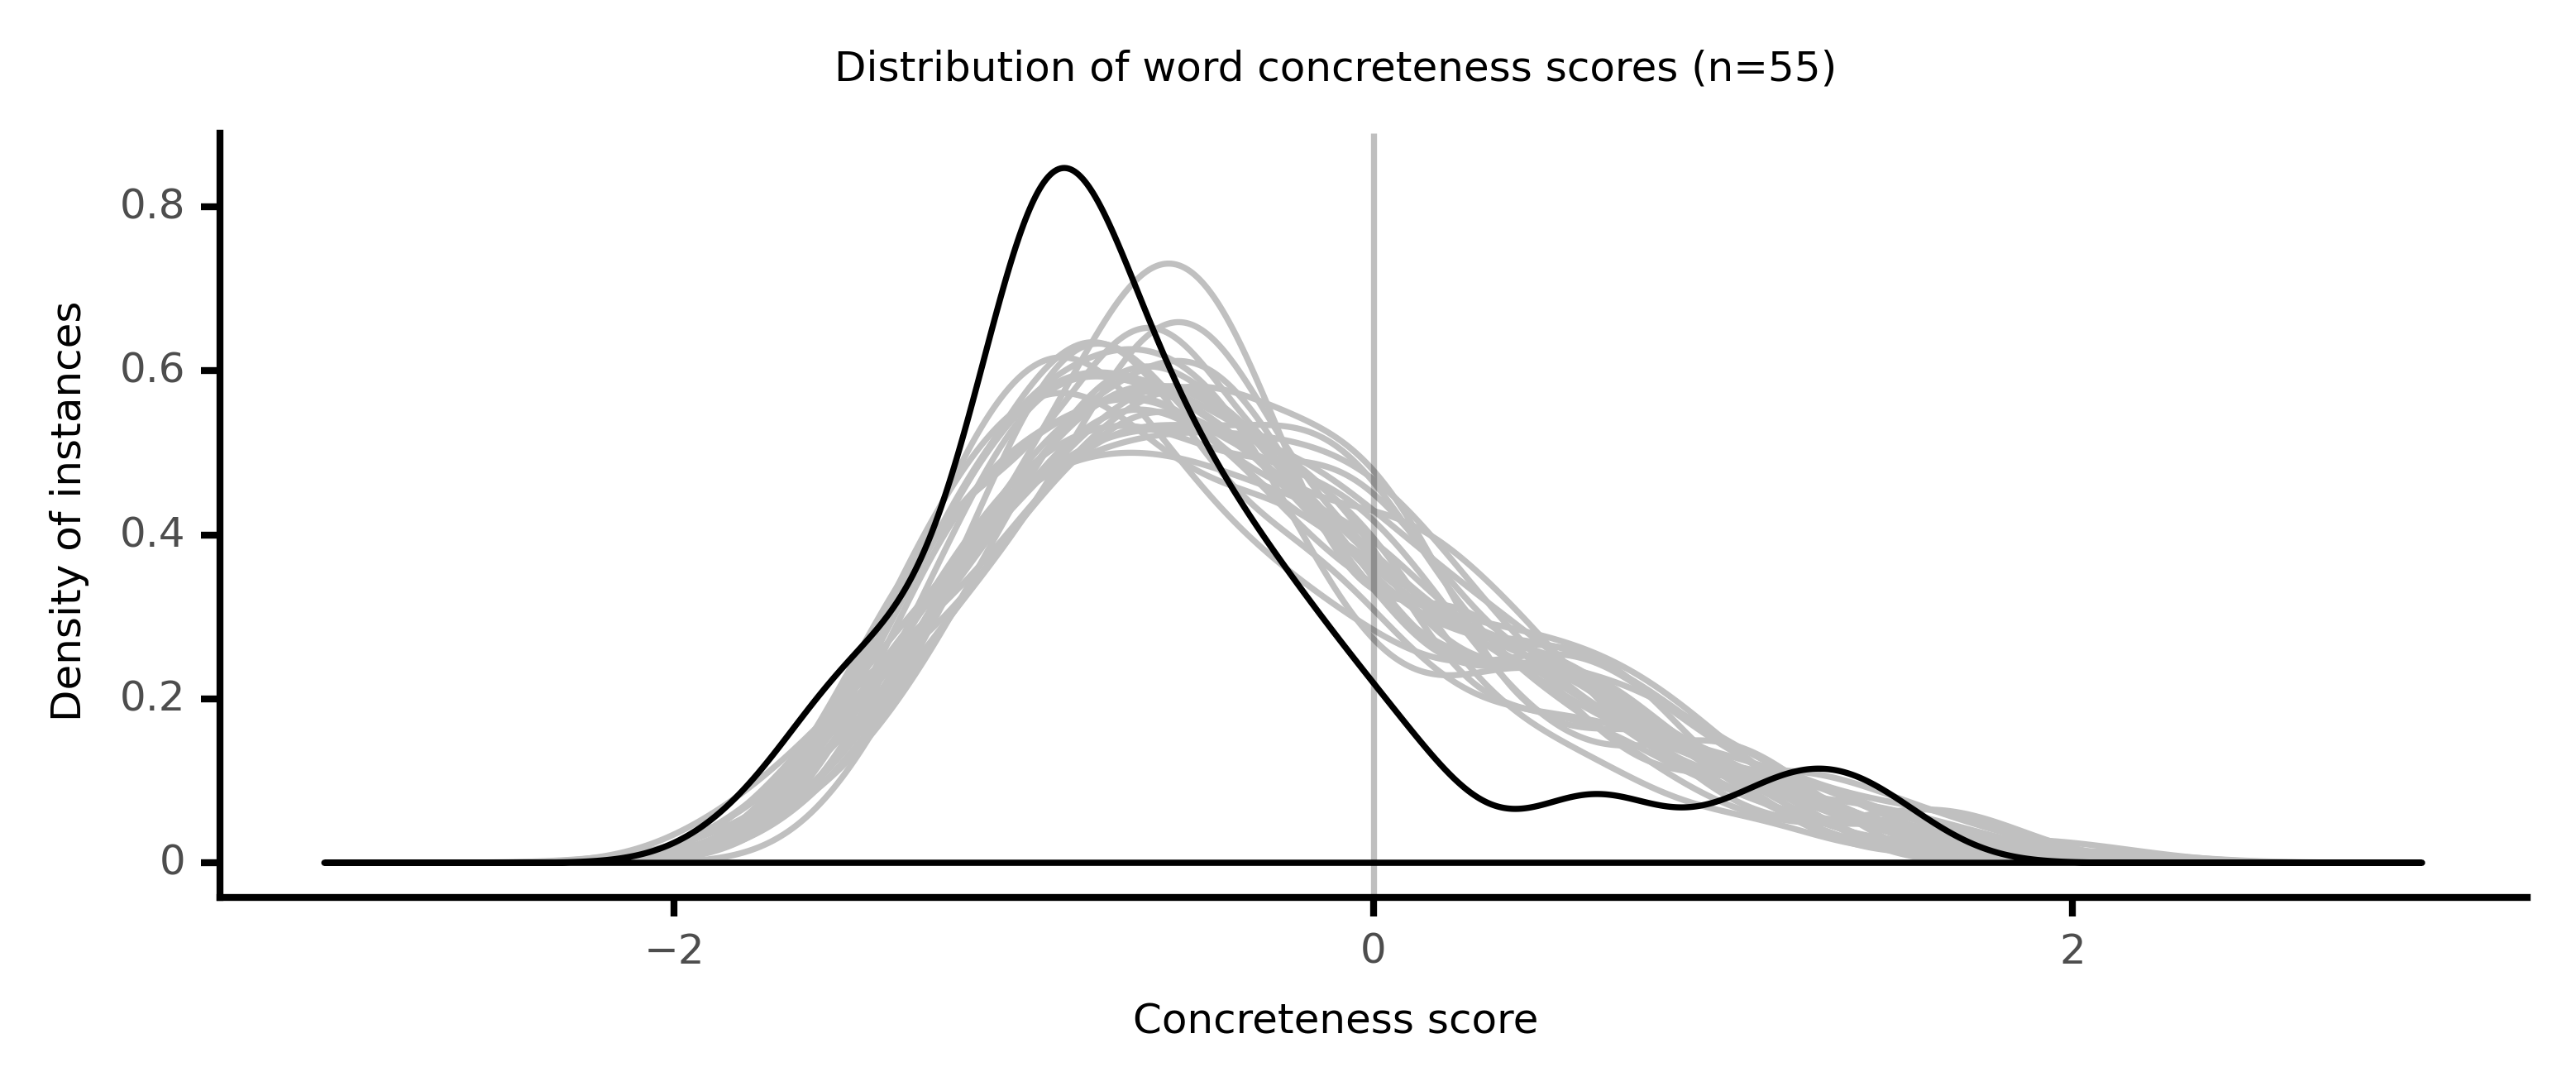

<ggplot: (8742809375277)>

In [21]:
showpsg(
    """Edward Ferrars was not recommended to their good opinion by any peculiar graces 
of person or address. He was not handsome, and his manners required intimacy to 
make them pleasing. He was too diffident to do justice to himself; but when his 
natural shyness was overcome, his behaviour gave every indication of an open, 
affectionate heart. His understanding was good, and his education had given it 
solid improvement. But he was neither fitted by abilities nor disposition to 
answer the wishes of his mother and sister, who longed to see him 
distinguished-- as-- they hardly knew what. They wanted him to make a fine 
figure in the world in some manner or other. His mother wished to interest him 
in political concerns, to get him into parliament, or to see him connected with 
some of the great men of the day. Mrs. John Dashwood wished it likewise; but in 
the mean while, till one of these superior blessings could be attained, it would 
have quieted her ambition to see him driving a barouche. But Edward had no turn 
for great men or barouches. All his wishes centered in domestic comfort and the 
quiet of private life.""",
    'Edward Ferrars, from Austen, _Sense and Sensibility_ (1811)',
    C.au.Austen.SenseAndSensibilityANovel.txt,
    periods={'C18','C19'}
)

In [22]:
# txt="""Miss Brooke had that kind of beauty which seems to be thrown into relief by poor dress. Her hand and wrist were so finely formed that she could wear sleeves not less bare of style than those in which the Blessed Virgin appeared to Italian painters; and her profile as well as her stature and bearing seemed to gain the more dignity from her plain garments, which by the side of provincial fashion gave her the impressiveness of a fine quotation from the Bible,-- or from one of our elder poets,-- in a paragraph of to-day's newspaper. She was usually spoken of as being remarkably clever, but with the addition that her sister Celia had more common-sense. Nevertheless, Celia wore scarcely more trimmings; and it was only to close observers that her dress differed from her sister's, and had a shade of coquetry in its arrangements; for Miss Brooke's plain dressing was due to mixed conditions, in most of which her sister shared. The pride of being ladies had something to do with it: the Brooke connections, though not exactly aristocratic, were unquestionably`` good:'' if you inquired backward for a generation or two, you would not find any yard-measuring or parcel-tying forefathers-- anything lower than an admiral or a clergyman; and there was even an ancestor discernible as a Puritan gentleman who served under Cromwell, but afterwards conformed, and managed to come out of all political troubles as the proprietor of a respectable family estate. Young women of such birth, living in a quiet country-house, and attending a village church hardly larger than a parlor, naturally regarded frippery as the ambition of a huckster's daughter. Then there was well-bred economy, which in those days made show in dress the first item to be deducted from, when any margin was required for expenses more distinctive of rank. Such reasons would have been enough to account for plain dress, quite apart from religious feeling; but in Miss Brooke's case, religion alone would have determined it; and Celia mildly acquiesced in all her sister's sentiments, only infusing them with that common-sense which is able to accept momentous doctrines without any eccentric agitation. Dorothea knew many passages of Pascal's Pensees and of Jeremy Taylor by heart; and to her the destinies of mankind, seen by the light of Christianity, made the solicitudes of feminine fashion appear an occupation for Bedlam. She could not reconcile the anxieties of a spiritual life involving eternal consequences, with a keen interest in gimp and artificial protrusions of drapery. Her mind was theoretic, and yearned by its nature after some lofty conception of the world which might frankly include the parish of Tipton and her own rule of conduct there; she was enamoured of intensity and greatness, and rash in embracing whatever seemed to her to have those aspects; likely to seek martyrdom, to make retractations, and then to incur martyrdom after all in a quarter where she had not sought it. Certainly such elements in the character of a marriageable girl tended to interfere with her lot, and hinder it from being decided according to custom, by good looks, vanity, and merely canine affection. With all this, she, the elder of the sisters, was not yet twenty, and they had both been educated, since they were about twelve years old and had lost their parents, on plans at once narrow and promiscuous, first in an English family and afterwards in a Swiss family at Lausanne, their bachelor uncle and guardian trying in this way to remedy the disadvantages of their orphaned condition."""
# df=showpsg(txt,'Dorothea')

In [23]:
# txt="""
# A gentleman carrying a gun, with two pointers playing round him, was passing up the hill and within a few yards of Marianne, when her accident happened. He put down his gun and ran to her assistance. She had raised herself from the ground, but her foot had been twisted in her fall, and she was scarcely able to stand. The gentleman offered his services; and perceiving that her modesty declined what her situation rendered necessary, took her up in his arms without farther delay, and carried her down the hill. Then passing through the garden, the gate of which had been left open by Margaret, he bore her directly into the house, whither Margaret was just arrived, and quitted not his hold till he had seated her in a chair in the parlour.

# Elinor and her mother rose up in amazement at their entrance, and while the eyes of both were fixed on him with an evident wonder and a secret admiration which equally sprung from his appearance, he apologized for his intrusion by relating its cause, in a manner so frank and so graceful that his person, which was uncommonly handsome, received additional charms from his voice and expression. Had he been even old, ugly, and vulgar, the gratitude and kindness of Mrs. Dashwood would have been secured by any act of attention to her child; but the influence of youth, beauty, and elegance, gave an interest to the action which came home to her feelings.

# She thanked him again and again; and, with a sweetness of address which always attended her, invited him to be seated. But this he declined, as he was dirty and wet. Mrs. Dashwood then begged to know to whom she was obliged. His name, he replied, was Willoughby, and his present home was at Allenham, from whence he hoped she would allow him the honour of calling tomorrow to enquire after Miss Dashwood. The honour was readily granted, and he then departed, to make himself still more interesting, in the midst of a heavy rain.

# His manly beauty and more than common gracefulness were instantly the theme of general admiration, and the laugh which his gallantry raised against Marianne received particular spirit from his exterior attractions. Marianne herself had seen less of his person than the rest, for the confusion which crimsoned over her face, on his lifting her up, had robbed her of the power of regarding him after their entering the house. But she had seen enough of him to join in all the admiration of the others, and with an energy which always adorned her praise. His person and air were equal to what her fancy had ever drawn for the hero of a favourite story; and in his carrying her into the house with so little previous formality, there was a rapidity of thought which particularly recommended the action to her. Every circumstance belonging to him was interesting. His name was good, his residence was in their favourite village, and she soon found out that of all manly dresses a shooting-jacket was the most becoming. Her imagination was busy, her reflections were pleasant, and the pain of a sprained ankle was disregarded.
# """

# df=showpsg(txt,title='Willoughby, from Austen, _Sense and Sensibility_ (1811)')

#### Marianne

<p>Marianne's <abs><conc021>abilities</conc021></abs> were, in many <abs><conc087>respects</conc087></abs>, quite <neither><conc246>equal</conc246></neither> to Elinor's. She was sensible and <neither><conc402>clever</conc402></neither>; but <neither><conc393>eager</conc393></neither> in everything: her <neither><conc327>sorrows</conc327></neither>, her <neither><conc307>joys</conc307></neither>, could have no <abs><conc018>moderation</conc018></abs>. She was <abs><conc152>generous</conc152></abs>, <neither><conc302>amiable</conc302></neither>, <abs><conc182>interesting</conc182></abs>: she was everything but <abs><conc102>prudent</conc102></abs>. The <neither><conc433>resemblance</conc433></neither> between her and her mother was <neither><conc313>strikingly</conc313></neither> great. 
 
 Elinor saw, with <abs><conc052>concern</conc052></abs>, the <neither><conc264>excess</conc264></neither> of her sister's <abs><conc113>sensibility</conc113></abs>; but by Mrs. Dashwood it was <neither><conc389>valued</conc389></neither> and <neither><conc236>cherished</conc236></neither>. They <abs><conc087>encouraged</conc087></abs> each other now in the <abs><conc180>violence</conc180></abs> of their <abs><conc211>affliction</conc211></abs>. The <neither><conc422>agony</conc422></neither> of <neither><conc347>grief</conc347></neither> which <neither><conc293>overpowered</conc293></neither> them at first, was <abs><conc083>voluntarily</conc083></abs> <abs><conc154>renewed</conc154></abs>, was <abs><conc223>sought</conc223></abs> for, was <abs><conc101>created</conc101></abs> again and again. They gave themselves up <abs><conc078>wholly</conc078></abs> to their <neither><conc289>sorrow</conc289></neither>, <abs><conc173>seeking</conc173></abs> <neither><conc227>increase</conc227></neither> of <abs><conc175>wretchedness</conc175></abs> in every <neither><conc262>reflection</conc262></neither> that could <neither><conc255>afford</conc255></neither> it, and <abs><conc165>resolved</conc165></abs> against ever <abs><conc061>admitting</conc061></abs> <abs><conc123>consolation</conc123></abs> in <abs><conc057>future</conc057></abs>. Elinor, too, was <abs><conc223>deeply</conc223></abs> <neither><conc259>afflicted</conc259></neither>; but still she could <neither><conc229>struggle</conc229></neither>, she could <abs><conc065>exert</conc065></abs> herself. She could <abs><conc185>consult</conc185></abs> with her brother, could <abs><conc216>receive</conc216></abs> her <neither><conc584>sister-in-law</conc584></neither> on her <neither><conc538>arrival</conc538></neither>, and <abs><conc221>treat</conc221></abs> her with <abs><conc183>proper</conc183></abs> <abs><conc172>attention</conc172></abs>; and could <abs><conc168>strive</conc168></abs> to <neither><conc366>rouse</conc366></neither> h 
</p>

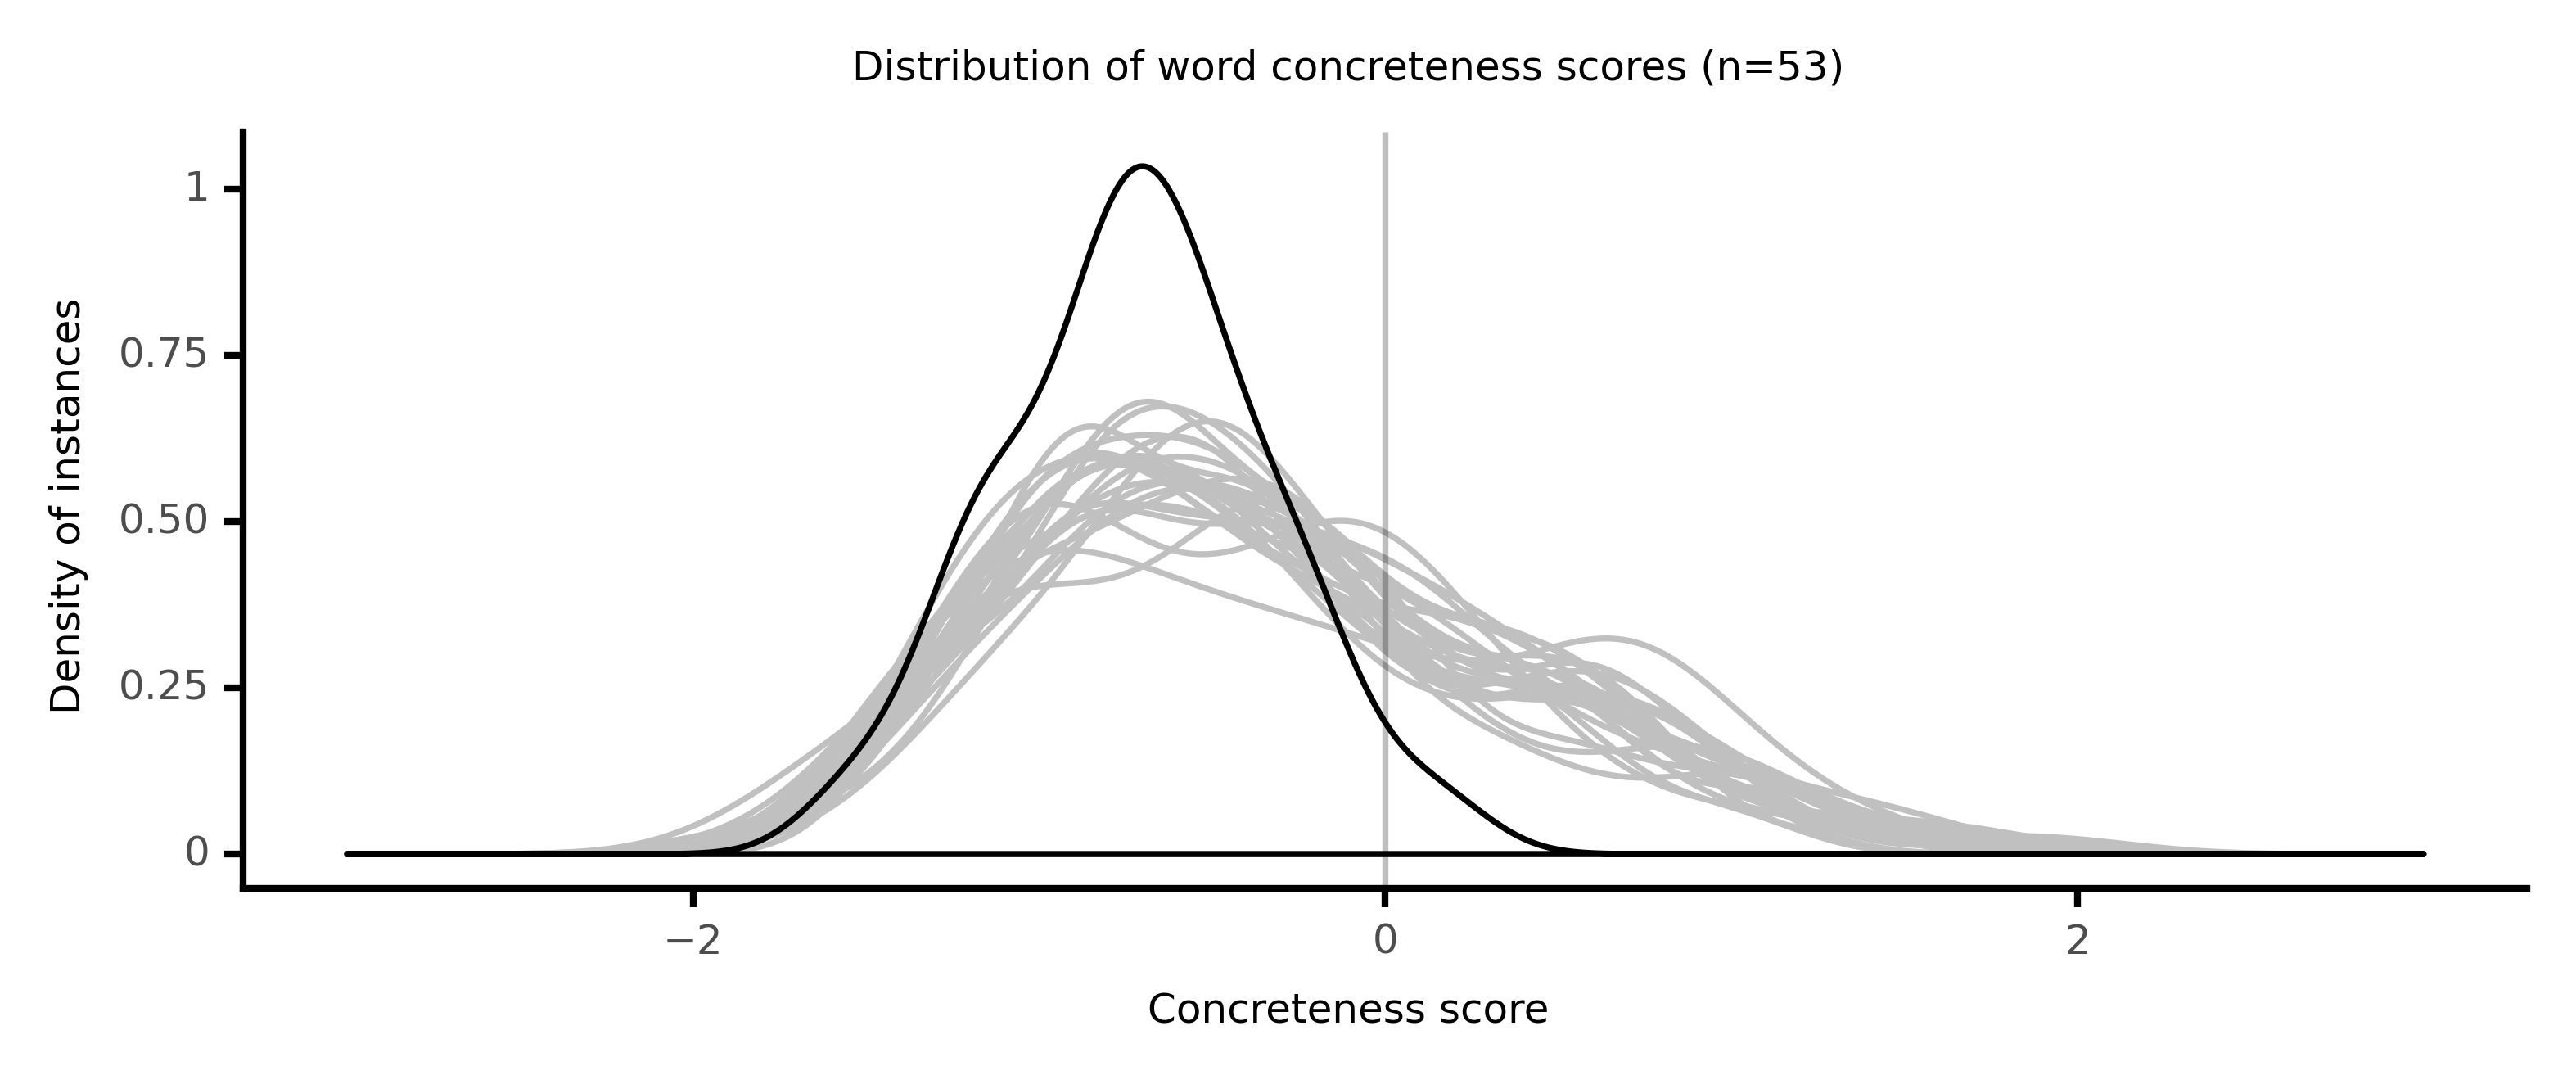

<ggplot: (8742799021601)>

In [24]:
txt="""Marianne's abilities were, in many respects, quite equal to Elinor's. She was sensible and clever; but eager in everything: her sorrows, her joys, could have no moderation. She was generous, amiable, interesting: she was everything but prudent. The resemblance between her and her mother was strikingly great.

Elinor saw, with concern, the excess of her sister's sensibility; but by Mrs. Dashwood it was valued and cherished. They encouraged each other now in the violence of their affliction. The agony of grief which overpowered them at first, was voluntarily renewed, was sought for, was created again and again. They gave themselves up wholly to their sorrow, seeking increase of wretchedness in every reflection that could afford it, and resolved against ever admitting consolation in future. Elinor, too, was deeply afflicted; but still she could struggle, she could exert herself. She could consult with her brother, could receive her sister-in-law on her arrival, and treat her with proper attention; and could strive to rouse h
"""
df=showpsg(txt,'Marianne',C.au.Austen.SenseAndSensibilityANovel.txt)

#### Mr Darcy

<p>
 His friend Mr. Darcy soon <neither><conc713>drew</conc713></neither> the <abs><conc172>attention</conc172></abs> of the room by his <conc><conc848>fine</conc848></conc>, <conc><conc908>tall</conc908></conc> person, <conc><conc845>handsome</conc845></conc> <neither><conc578>features</conc578></neither>, <neither><conc247>noble</conc247></neither> <neither><conc492>mien</conc492></neither>; and the <neither><conc267>report</conc267></neither> which was in <abs><conc072>general</conc072></abs> <neither><conc410>circulation</conc410></neither> within five <neither><conc702>minutes</conc702></neither> after his <neither><conc730>entrance</conc730></neither>, of his having ten thousand a year. The <neither><conc408>gentlemen</conc408></neither> <abs><conc195>pronounced</conc195></abs> him to be a <conc><conc848>fine</conc848></conc> <neither><conc681>figure</conc681></neither> of a man, the <conc><conc843>ladies</conc843></conc> <abs><conc070>declared</conc070></abs> he was much <neither><conc744>handsomer</conc744></neither> than Mr. Bingley, and he was <neither><conc586>looked</conc586></neither> at with great <abs><conc189>admiration</conc189></abs> for about half the evening, till his <abs><conc152>manners</conc152></abs> gave a <abs><conc216>disgust</conc216></abs> which <neither><conc614>turned</conc614></neither> the <neither><conc757>tide</conc757></neither> of his <abs><conc072>popularity</conc072></abs>; for he was <neither><conc483>discovered</conc483></neither> to be proud, to be above his <neither><conc533>company</conc533></neither>, and above being <neither><conc230>pleased</conc230></neither>; and not all his <neither><conc715>large</conc715></neither> <neither><conc318>estate</conc318></neither> in Derbyshire could then <neither><conc267>save</conc267></neither> him from having a most <neither><conc243>forbidding</conc243></neither>, <abs><conc163>disagreeable</conc163></abs> <neither><conc347>countenance</conc347></neither>, and being <abs><conc030>unworthy</conc030></abs> to be <neither><conc326>compared</conc326></neither> with his friend. 
</p>

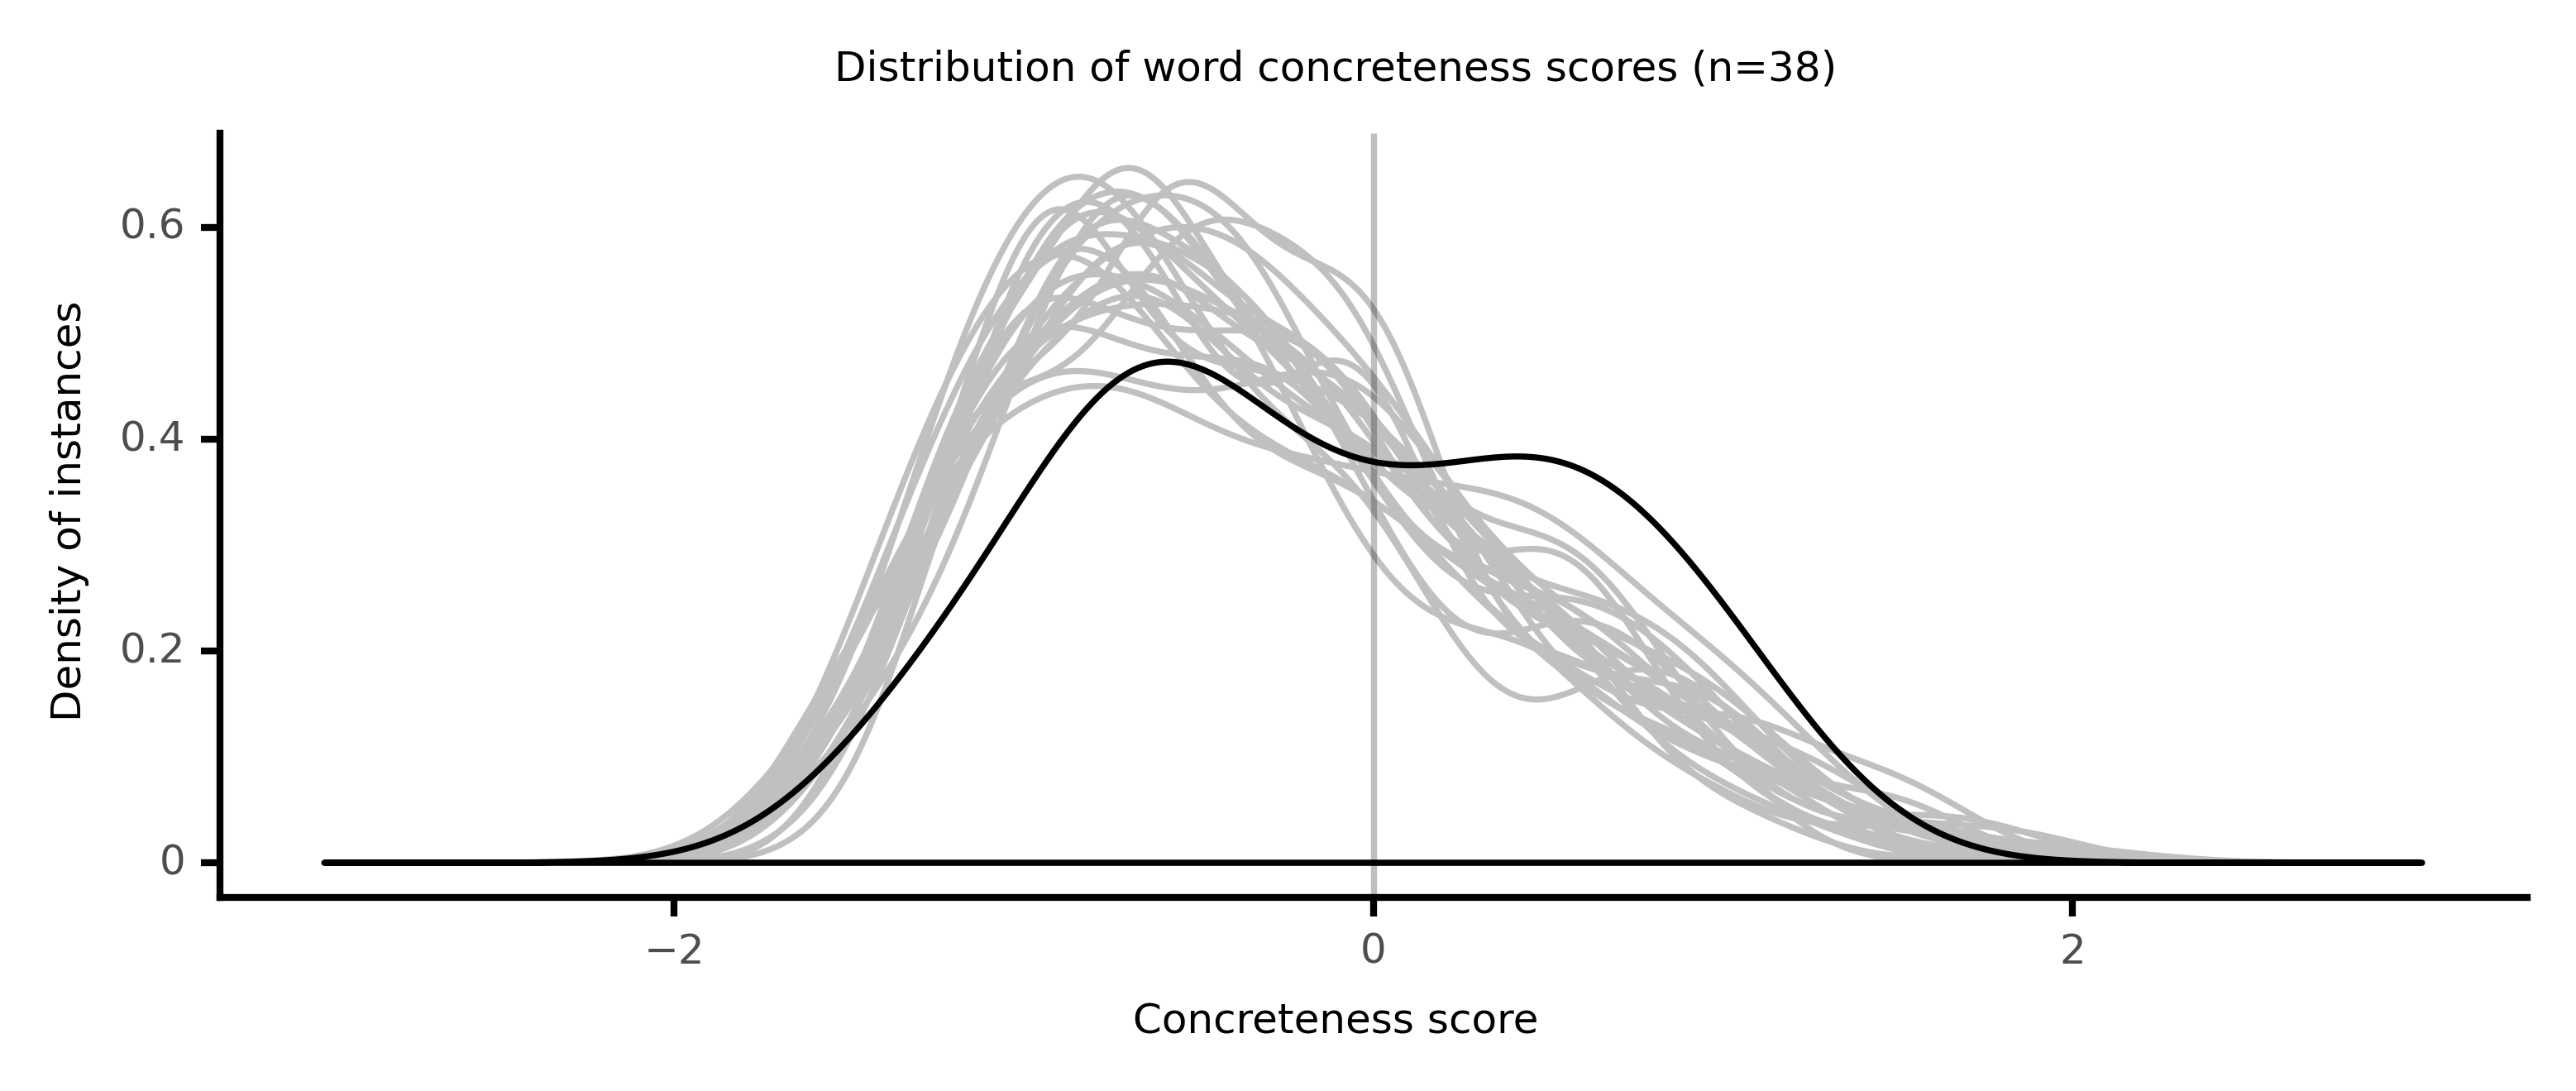

<ggplot: (8742798694485)>

In [25]:
df=showpsg("""
His friend Mr. Darcy soon drew the attention of the room by his fine, tall person, handsome features, noble mien; and the report which was in general circulation within five minutes after his entrance, of his having ten thousand a year. The gentlemen pronounced him to be a fine figure of a man, the ladies declared he was much handsomer than Mr. Bingley, and he was looked at with great admiration for about half the evening, till his manners gave a disgust which turned the tide of his popularity; for he was discovered to be proud, to be above his company, and above being pleased; and not all his large estate in Derbyshire could then save him from having a most forbidding, disagreeable countenance, and being unworthy to be compared with his friend.
""",
'Mr Darcy',C.au.Austen.PrideAndPrejudiceANovel.txt)

#### On Frank Churchill's getting a haircut

<p>Emma's very good <abs><conc021>opinion</conc021></abs> of Frank Churchill was a little <neither><conc507>shaken</conc507></neither> the following day, by <neither><conc265>hearing</conc265></neither> that he was gone off to London, merely to have his <conc><conc978>hair</conc978></conc> <conc><conc885>cut</conc885></conc>. A <neither><conc419>sudden</conc419></neither> <neither><conc712>freak</conc712></neither> seemed to have <neither><conc602>seized</conc602></neither> him at <conc><conc886>breakfast</conc886></conc>, and he had sent for a <conc><conc870>chaise</conc870></conc> and <neither><conc574>set</conc574></neither> off, <neither><conc384>intending</conc384></neither> to return to <conc><conc823>dinner</conc823></conc>, but with no more important <neither><conc292>view</conc292></neither> that <neither><conc444>appeared</conc444></neither> than having his <conc><conc978>hair</conc978></conc> <conc><conc885>cut</conc885></conc>. There was certainly no <neither><conc348>harm</conc348></neither> in his <neither><conc707>traveling</conc707></neither> sixteen <conc><conc782>miles</conc782></conc> twice over on such an <neither><conc545>errand</conc545></neither>; but there was an <neither><conc737>air</conc737></neither> of <neither><conc367>foppery</conc367></neither> and <neither><conc270>nonsense</conc270></neither> in it which she could not <abs><conc053>approve</conc053></abs>. It did not <abs><conc142>accord</conc142></abs> with the <abs><conc003>rationality</conc003></abs> of <neither><conc338>plan</conc338></neither>, the <abs><conc018>moderation</conc018></abs> in <neither><conc308>expense</conc308></neither>, or even the <abs><conc048>unselfish</conc048></abs> <neither><conc588>warmth</conc588></neither> of <neither><conc371>heart</conc371></neither> which she had <abs><conc100>believed</conc100></abs> herself to <abs><conc188>discern</conc188></abs> in him <neither><conc488>yesterday</conc488></neither>. <abs><conc164>Vanity</conc164></abs>, <abs><conc124>extravagance</conc124></abs>, love of <neither><conc233>change</conc233></neither>, <abs><conc213>restlessness</conc213></abs> of <neither><conc236>temper</conc236></neither>, which must be doing something, good or <neither><conc548>bade</conc548></neither>; <abs><conc046>heedlessness</conc046></abs> as to the <abs><conc219>pleasure</conc219></abs> of his father and Mrs. Weston, <abs><conc107>indifferent</conc107></abs> as to how his <abs><conc069>conduct</conc069></abs> might appear in <abs><conc072>general</conc072></abs>; he became <abs><conc074>liable</conc074></abs> to all these changes. His father only <neither><conc518>called</conc518></neither> him a <neither><conc700>coxcomb</conc700></neither>, and thought it a very good <neither><conc472>story</conc472></neither>; but that Mrs. Weston did not Like it, was <neither><conc322>clear</conc322></neither> enough, by her <neither><conc588>passing</conc588></neither> it over as quickly as possible, and making no other <abs><conc217>comment</conc217></abs> than that all <neither><conc724>young</conc724></neither> people would have their little <neither><conc284>whims</conc284></neither>.'' With the <abs><conc108>exception</conc108></abs> of this little <neither><conc377>blot</conc377></neither>, Emma found that his <neither><conc507>visit</conc507></neither> hitherto had given her friend only good <abs><conc118>ideas</conc118></abs> of him. Mrs. Weston was very <neither><conc400>ready</conc400></neither> to say how <neither><conc280>attentive</conc280></neither> and <neither><conc626>pleasant</conc626></neither> a <neither><conc547>companion</conc547></neither> he made himself-- how much she saw to Like in his <abs><conc048>disposition</conc048></abs> <abs><conc148>altogether</conc148></abs>. He <neither><conc444>appeared</conc444></neither> to have a very <neither><conc536>open</conc536></neither> <neither><conc236>temper</conc236></neither>-- certainly a very <neither><conc457>cheerful</conc457></neither> and <neither><conc454>lively</conc454></neither> one; she could <abs><conc190>observe</conc190></abs> nothing <abs><conc119>wrong</conc119></abs> in his <abs><conc051>notions</conc051></abs>, a great deal <abs><conc181>decidedly</conc181></abs> right; he spoke of his <neither><conc619>uncle</conc619></neither> with <conc><conc843>warm</conc843></conc> regard, was found of <neither><conc487>talking</conc487></neither> of him-- said he would be the best man in the world if he were left to himself; and though there was no being <neither><conc460>attached</conc460></neither> to the <conc><conc825>aunt</conc825></conc>, he <abs><conc028>acknowledged</conc028></abs> her <abs><conc193>kindness</conc193></abs> with <abs><conc097>gratitude</conc097></abs>, and seemed to mean always to speak of her with <abs><conc017>respect</conc017></abs>. This was all very <neither><conc239>promising</conc239></neither>; and, but for such an <neither><conc239>unfortunate</conc239></neither> <neither><conc446>fancy</conc446></neither> for having his <conc><conc978>hair</conc978></conc> <conc><conc885>cut</conc885></conc>, there was nothing to <neither><conc284>denote</conc284></neither> him <abs><conc030>unworthy</conc030></abs> of the <abs><conc168>distinguished</conc168></abs> honour which her <abs><conc141>imagination</conc141></abs> had given him; the honour, if not of being really in love with her, of being at least very near it, and <neither><conc244>saved</conc244></neither> only by her own <abs><conc049>indifference</conc049></abs>--( for still her <abs><conc111>resolution</conc111></abs> <neither><conc353>held</conc353></neither> of never <neither><conc449>marrying</conc449></neither>)-- the honour, in <neither><conc459>short</conc459></neither>, of being <neither><conc589>marked</conc589></neither> out for her by all their <neither><conc565>joint</conc565></neither> <neither><conc336>acquaintance</conc336></neither>.</p>

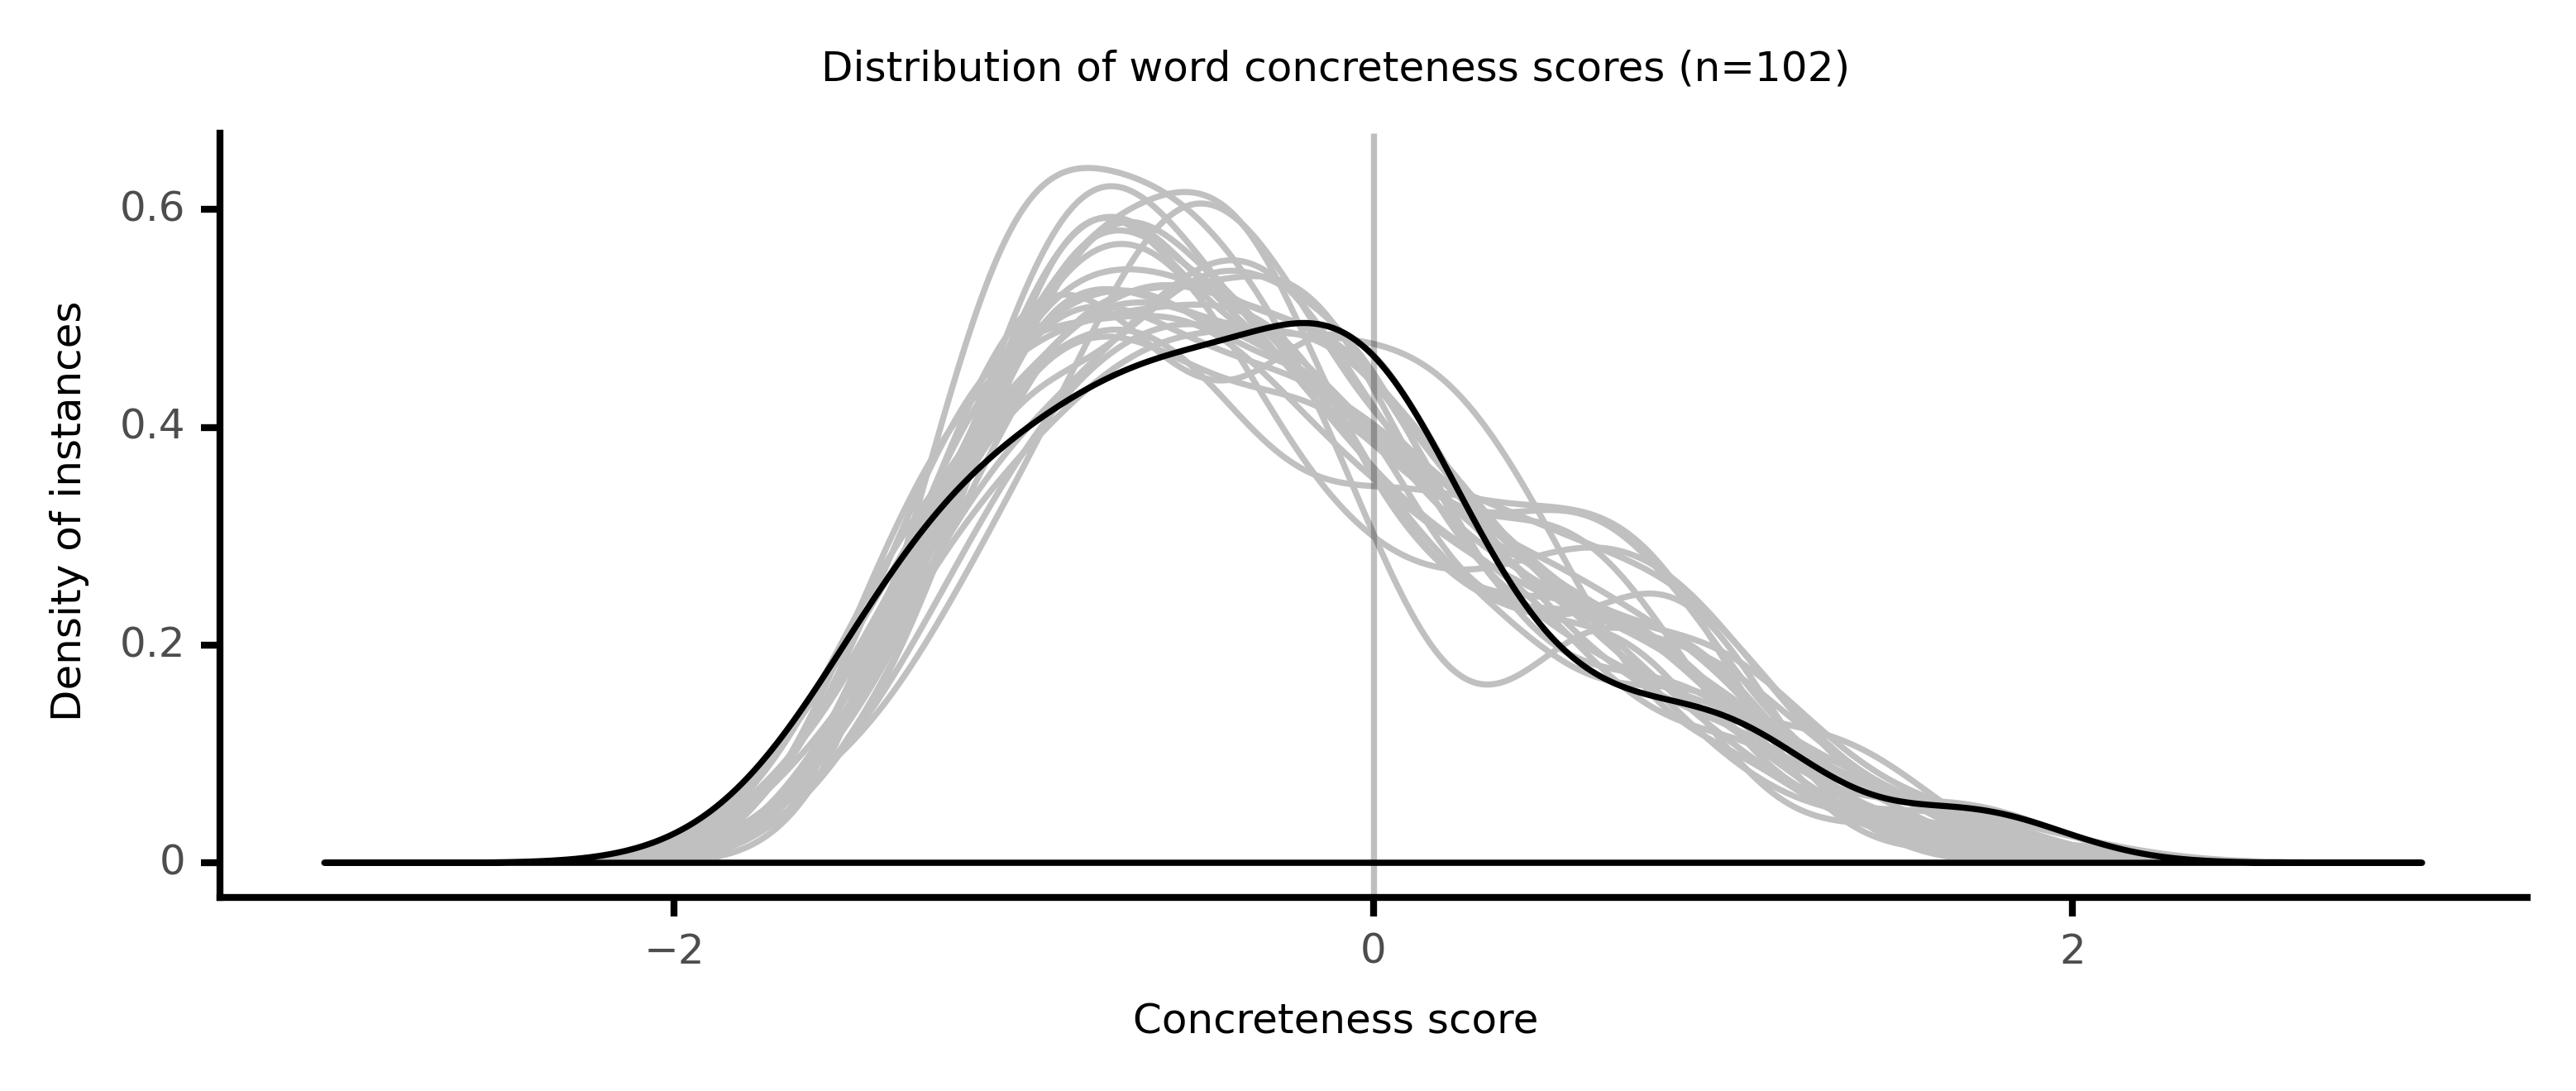

<ggplot: (8742829317081)>

In [26]:
showpsg(
    """Emma's very good opinion of Frank Churchill was a little shaken the following day, by hearing that he was gone off to London, merely to have his hair cut. A sudden freak seemed to have seized him at breakfast, and he had sent for a chaise and set off, intending to return to dinner, but with no more important view that appeared than having his hair cut. There was certainly no harm in his traveling sixteen miles twice over on such an errand; but there was an air of foppery and nonsense in it which she could not approve. It did not accord with the rationality of plan, the moderation in expense, or even the unselfish warmth of heart which she had believed herself to discern in him yesterday. Vanity, extravagance, love of change, restlessness of temper, which must be doing something, good or bade; heedlessness as to the pleasure of his father and Mrs. Weston, indifferent as to how his conduct might appear in general; he became liable to all these changes. His father only called him a coxcomb, and thought it a very good story; but that Mrs. Weston did not Like it, was clear enough, by her passing it over as quickly as possible, and making no other comment than that all young people would have their little whims.'' With the exception of this little blot, Emma found that his visit hitherto had given her friend only good ideas of him. Mrs. Weston was very ready to say how attentive and pleasant a companion he made himself-- how much she saw to Like in his disposition altogether. He appeared to have a very open temper-- certainly a very cheerful and lively one; she could observe nothing wrong in his notions, a great deal decidedly right; he spoke of his uncle with warm regard, was found of talking of him-- said he would be the best man in the world if he were left to himself; and though there was no being attached to the aunt, he acknowledged her kindness with gratitude, and seemed to mean always to speak of her with respect. This was all very promising; and, but for such an unfortunate fancy for having his hair cut, there was nothing to denote him unworthy of the distinguished honour which her imagination had given him; the honour, if not of being really in love with her, of being at least very near it, and saved only by her own indifference-- (for still her resolution held of never marrying)-- the honour, in short, of being marked out for her by all their joint acquaintance.""",
    'On Frank Churchill\'s getting a haircut',
    C.au.Austen.EmmaANovelInThreeVolume.txt
)

#### Wickham

<p>But the <abs><conc188>attention</conc188></abs> of every lady was soon <conc><conc843>caught</conc843></conc> by a <neither><conc641>young</conc641></neither> man, whom they 
 had never seen before, of most <abs><conc212>gentleman-like</conc212></abs> <neither><conc450>appearance</conc450></neither>, <conc><conc793>walking</conc793></conc> with an 
 <neither><conc318>officer</conc318></neither> on the other side of the way.... 
 All were <neither><conc588>struck</conc588></neither> with the <neither><conc399>stranger</conc399></neither>'s <neither><conc700>air</conc700></neither>, all <neither><conc336>wondered</conc336></neither> who he could be, 
 and Kitty and Lydia, <abs><conc102>determined</conc102></abs> if possible to find out, <neither><conc233>led</conc233></neither> the way across the 
 <conc><conc862>street</conc862></conc>, under <abs><conc216>pretence</conc216></abs> of <abs><conc216>wanting</conc216></abs> something in an <neither><conc468>opposite</conc468></neither> <conc><conc889>shop</conc889></conc>, and <neither><conc374>fortunately</conc374></neither> 
 had just <abs><conc160>gained</conc160></abs> the <conc><conc933>pavement</conc933></conc> when the two <neither><conc356>gentlemen</conc356></neither> <neither><conc653>turning</conc653></neither> back had <neither><conc541>reached</conc541></neither> the 
 same <conc><conc795>spot</conc795></conc>. Mr. Denny <abs><conc217>addressed</conc217></abs> them <neither><conc296>directly</conc296></neither>, and <neither><conc314>entreated</conc314></neither> <neither><conc313>permission</conc313></neither> to 
 <neither><conc237>introduce</conc237></neither> his friend, Mr. Wickham, who had returned with him the day before from 
 <neither><conc707>town</conc707></neither>, and he was <neither><conc235>happy</conc235></neither> to say had <abs><conc137>accepted</conc137></abs> a <abs><conc096>commission</conc096></abs> in their <neither><conc436>corps</conc436></neither>. This was 
 exactly as it should be; for the <neither><conc641>young</conc641></neither> man wanted only <conc><conc854>regimentals</conc854></conc> to make him 
 <neither><conc314>completely</conc314></neither> <neither><conc708>charming</conc708></neither>. His <neither><conc450>appearance</conc450></neither> was <neither><conc234>greatly</conc234></neither> in his <abs><conc086>favour</conc086></abs>; he had all the 
 best part of <neither><conc459>beauty</conc459></neither>, a <conc><conc909>fine</conc909></conc> <neither><conc344>countenance</conc344></neither>, a good <neither><conc733>figure</conc733></neither>, and very <neither><conc314>pleasing</conc314></neither> 
 <abs><conc186>address</conc186></abs>. The <abs><conc212>introduction</conc212></abs> was followed up on his side by a <neither><conc235>happy</conc235></neither> <abs><conc221>readiness</conc221></abs> of 
 <neither><conc256>conversation</conc256></neither>-- a <abs><conc221>readiness</conc221></abs> at the same time <neither><conc317>perfectly</conc317></neither> <abs><conc076>correct</conc076></abs> and 
 <abs><conc140>unassuming</conc140></abs>.</p>

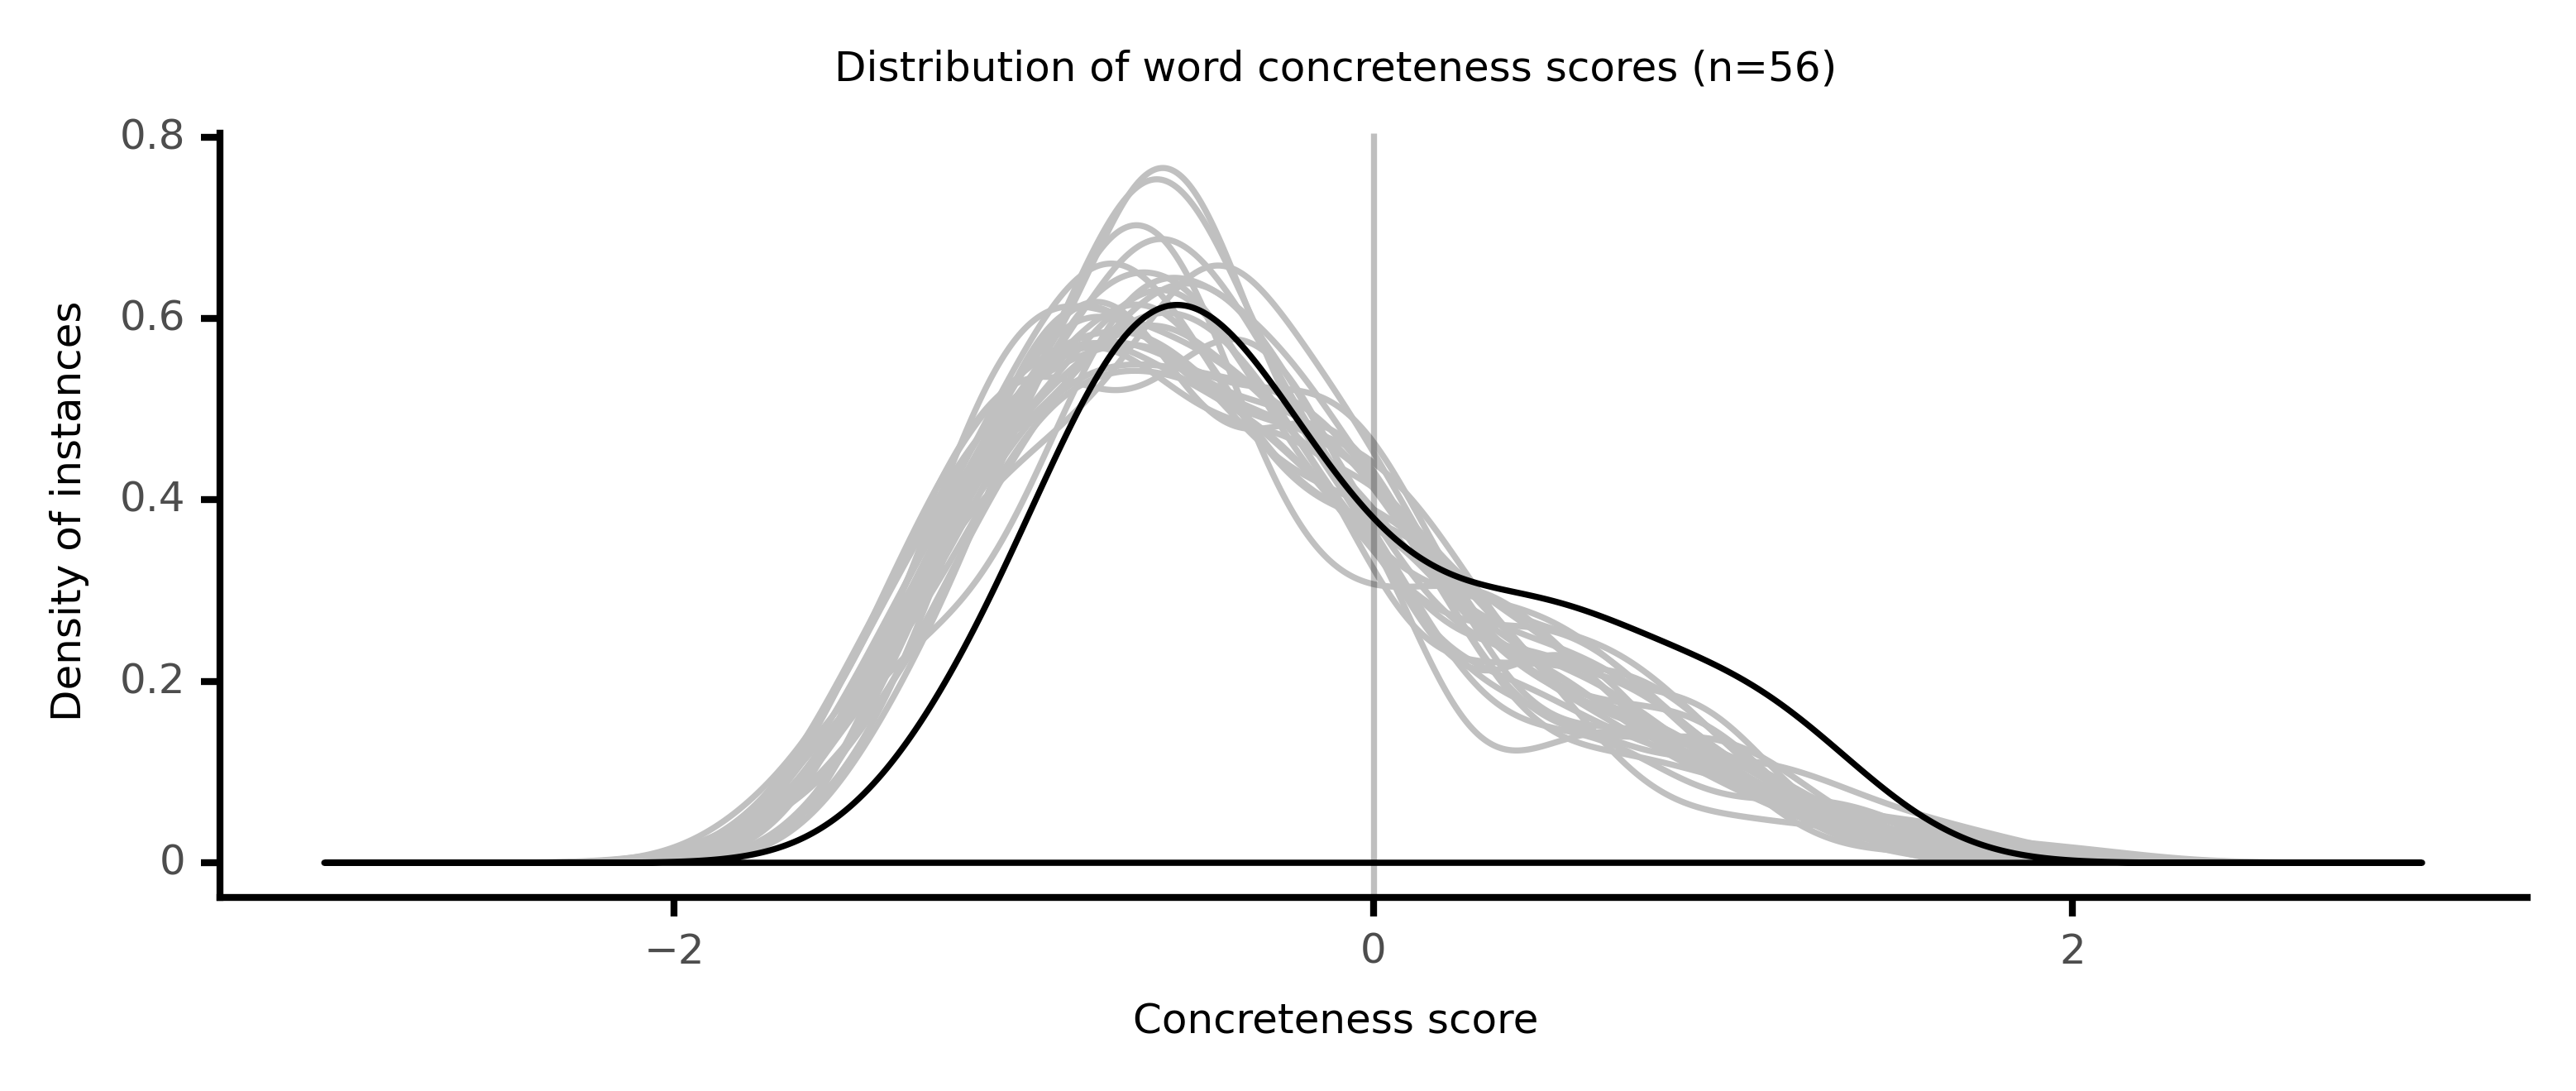

<ggplot: (8742799478601)>

In [27]:
showpsg(
    """But the attention of every lady was soon caught by a young man, whom they 
had never seen before, of most gentleman-like appearance, walking with an 
officer on the other side of the way. ... 
All were struck with the stranger's air, all wondered who he could be, 
and Kitty and Lydia, determined if possible to find out, led the way across the 
street, under pretence of wanting something in an opposite shop, and fortunately 
had just gained the pavement when the two gentlemen turning back had reached the 
same spot. Mr. Denny addressed them directly, and entreated permission to 
introduce his friend, Mr. Wickham, who had returned with him the day before from 
town, and he was happy to say had accepted a commission in their corps. This was 
exactly as it should be; for the young man wanted only regimentals to make him 
completely charming. His appearance was greatly in his favour; he had all the 
best part of beauty, a fine countenance, a good figure, and very pleasing 
address. The introduction was followed up on his side by a happy readiness of 
conversation-- a readiness at the same time perfectly correct and 
unassuming.""",
    
    'Wickham',
    C.au.Austen.PrideAndPrejudiceANovel.txt,
    stopwords={'kitty'},
    periods={'C18','C19'}
)

In [1]:
idjaneeyre=C.meta[C.meta.title.str.contains('Eyre')].index[0]
showpsg(
    """
    Two wax candles stood lighted on the table, and two on the mantelpiece; basking in the light and heat of a superb fire, lay Pilot—Adèle knelt near him. Half reclined on a couch appeared Mr. Rochester, his foot supported by the cushion; he was looking at Adèle and the dog: the fire shone full on his face. I knew my traveller with his broad and jetty eyebrows; his square forehead, made squarer by the horizontal sweep of his black hair. I recognised his decisive nose, more remarkable for character than beauty; his full nostrils, denoting, I thought, choler; his grim mouth, chin, and jaw—yes, all three were very grim, and no mistake. His shape, now divested of cloak, I perceived harmonised in squareness with his physiognomy: I suppose it was a good figure in the athletic sense of the term—broad chested and thin flanked, though neither tall nor graceful.
    """,
    'Mr Rochester',
    C.textd[idjaneeyre].txt
)

NameError: name 'C' is not defined

#### Fanny Price

<p>
 Fanny Price was at this time just ten years old, and though there might not be much in her first <neither><conc313>appearance</conc313></neither> to <neither><conc229>captivate</conc229></neither>, there was, at least, nothing to <abs><conc216>disgust</conc216></abs> her <abs><conc111>relations</conc111></abs>. She was <conc><conc779>small</conc779></conc> of her <neither><conc314>age</conc314></neither>, with no <neither><conc733>glow</conc733></neither> of <neither><conc676>complexion</conc676></neither>, nor any other <neither><conc522>striking</conc522></neither> <neither><conc579>beauty</conc579></neither>; <neither><conc307>exceedingly</conc307></neither> <neither><conc303>timid</conc303></neither> and <neither><conc598>shy</conc598></neither>, and <neither><conc622>shrinking</conc622></neither> from <neither><conc310>notice</conc310></neither>; but her <neither><conc737>air</conc737></neither>, though <neither><conc495>awkward</conc495></neither>, was not <abs><conc204>vulgar</conc204></abs>, her <neither><conc398>voice</conc398></neither> was <conc><conc788>sweet</conc788></conc>, and when she spoke her <neither><conc347>countenance</conc347></neither> was <conc><conc873>pretty</conc873></conc>. Sir Thomas and Lady Bertram <neither><conc230>received</conc230></neither> her very <neither><conc472>kindly</conc472></neither>; and Sir Thomas, seeing how much she <abs><conc216>needed</conc216></abs> <abs><conc081>encouragement</conc081></abs>, tried to be all that was <abs><conc017>conciliating</conc017></abs>: but he had to work against a most <abs><conc124>untoward</conc124></abs> <neither><conc264>gravity</conc264></neither> of <abs><conc163>deportment</conc163></abs>; and Lady Bertram, without taking half so much <abs><conc210>trouble</conc210></abs>, or speaking one word where he spoke ten, by the <abs><conc042>mere</conc042></abs> <abs><conc193>aid</conc193></abs> of a <neither><conc497>good-humoured</conc497></neither> <neither><conc660>smile</conc660></neither>, became immediately the less <neither><conc376>awful</conc376></neither> <abs><conc130>character</conc130></abs> of the two. 
</p>

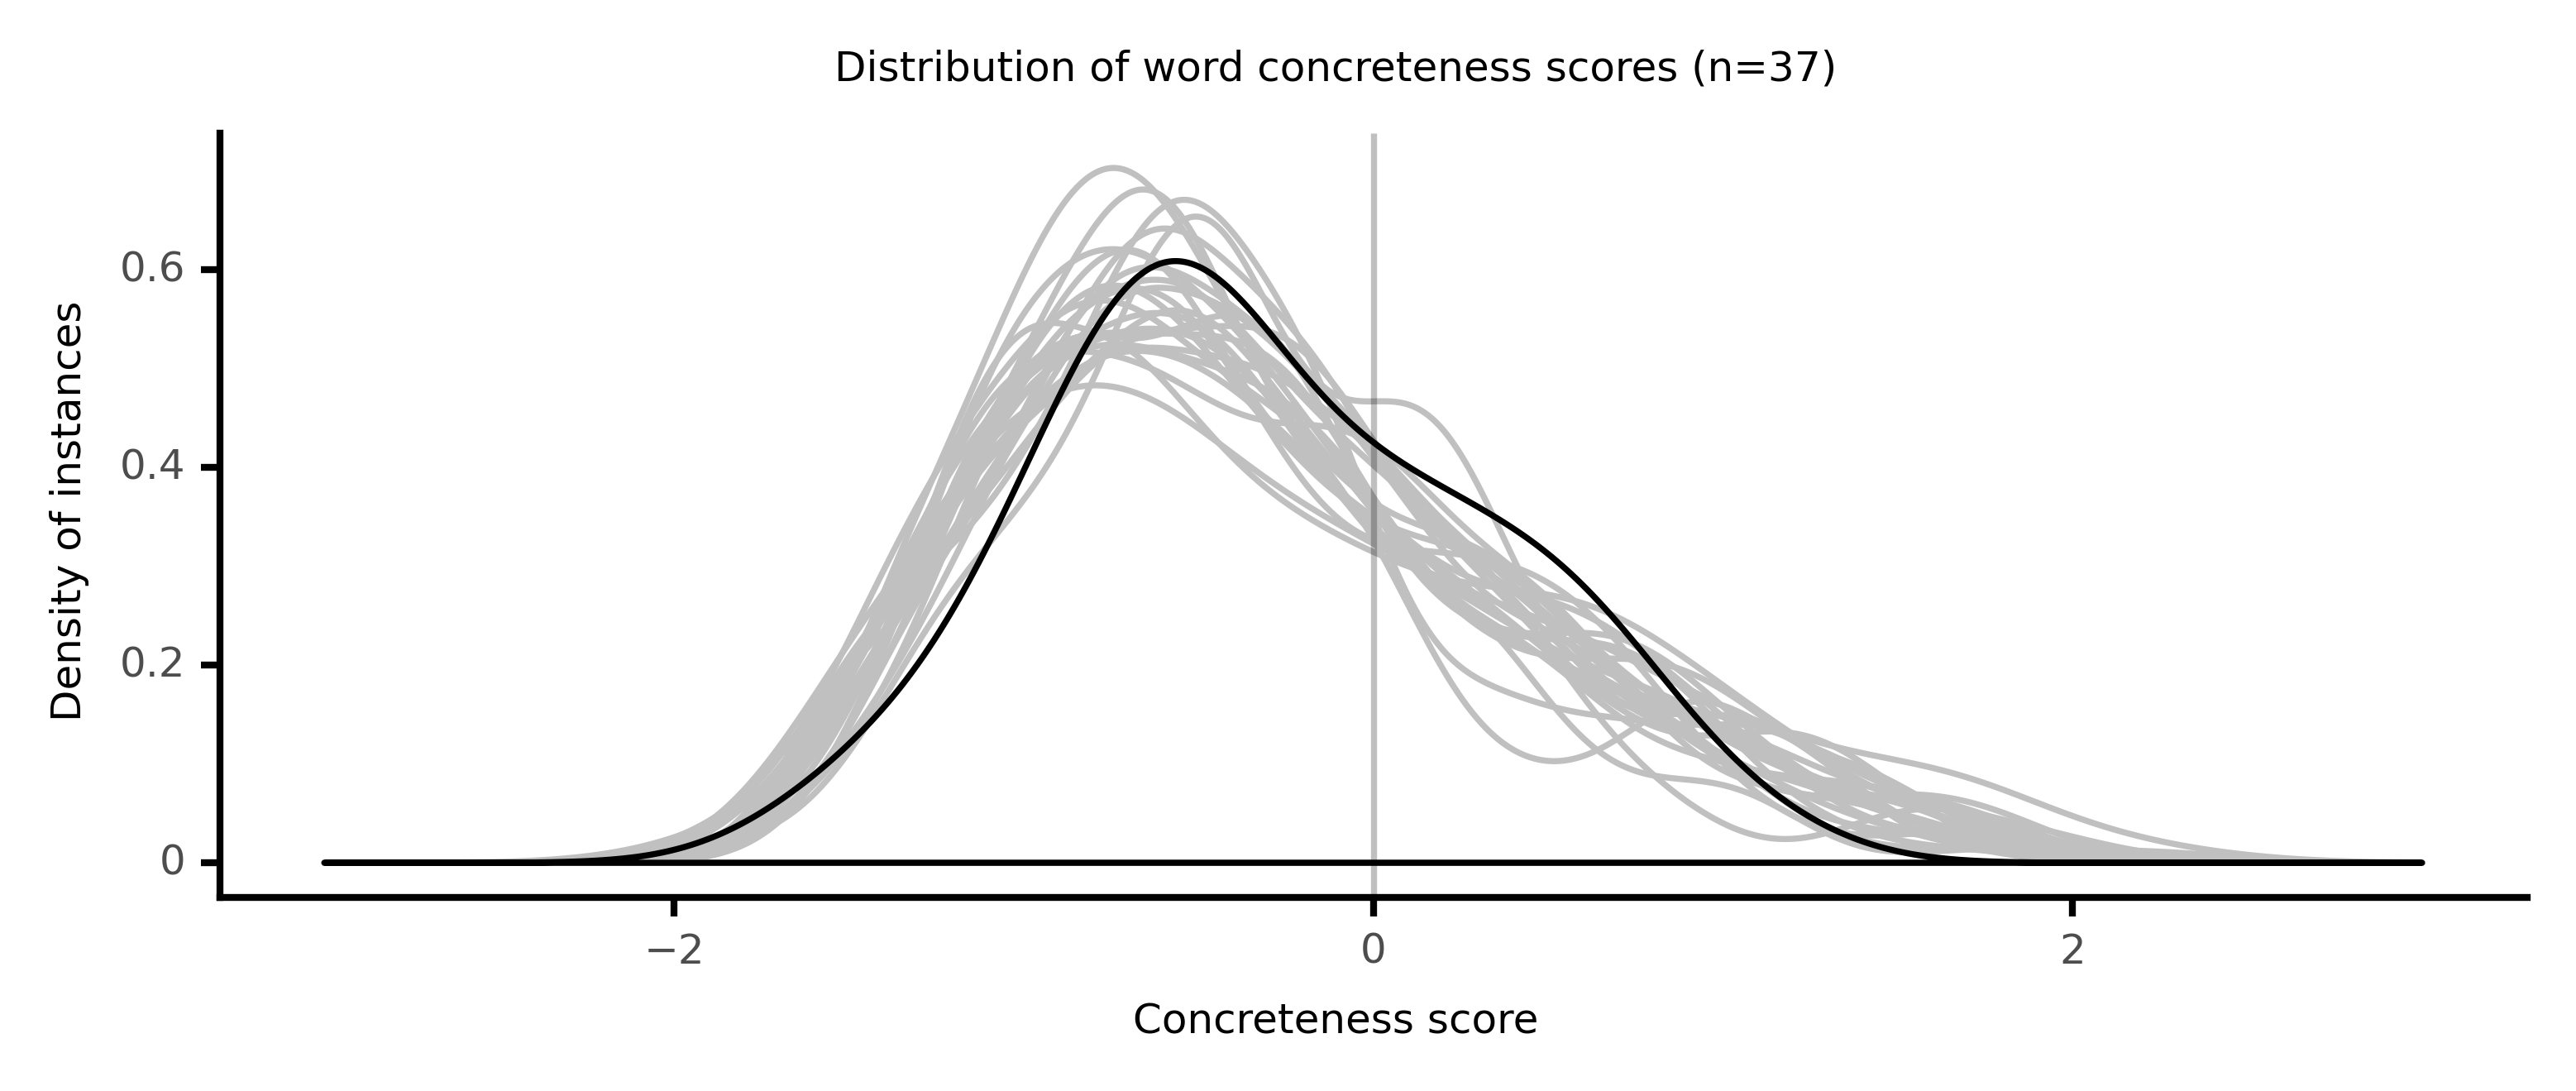

<ggplot: (8742808720689)>

In [29]:
showpsg(
"""
Fanny Price was at this time just ten years old, and though there might not be much in her first appearance to captivate, there was, at least, nothing to disgust her relations. She was small of her age, with no glow of complexion, nor any other striking beauty; exceedingly timid and shy, and shrinking from notice; but her air, though awkward, was not vulgar, her voice was sweet, and when she spoke her countenance was pretty. Sir Thomas and Lady Bertram received her very kindly; and Sir Thomas, seeing how much she needed encouragement, tried to be all that was conciliating: but he had to work against a most untoward gravity of deportment; and Lady Bertram, without taking half so much trouble, or speaking one word where he spoke ten, by the mere aid of a good-humoured smile, became immediately the less awful character of the two.
""",
    'Fanny Price',
    C.au.Austen.MansfieldParkANovelInTh.txt,
    stopwords={'fanny','price'},
    
)

#### Suttree

<p><neither><conc423>darkness</conc423></neither>, <conc><conc886>curved</conc886></conc> like cockheels in the <neither><conc750>pinchbeck</conc750></neither> <conc><conc921>dusk</conc921></conc>. The <conc><conc850>steel</conc850></conc> <conc><conc847>leaks</conc847></conc> back the day's <neither><conc611>heat</conc611></neither>, you can feel it through the <conc><conc977>floors</conc977></conc> of your <conc><conc950>shoes</conc950></conc>. Past these <conc><conc929>corrugated</conc929></conc> <conc><conc874>warehouse</conc874></conc> <conc><conc858>walls</conc858></conc> down little <conc><conc893>sandy</conc893></conc> <conc><conc836>streets</conc836></conc> where blownout <conc><conc784>autos</conc784></conc> <neither><conc544>sulk</conc544></neither> on <conc><conc914>pedestals</conc914></conc> of cinderblock. Through <conc><conc839>warrens</conc839></conc> of <conc><conc978>sumac</conc978></conc> and pokeweed and <conc><conc860>withered</conc860></conc> <conc><conc982>honeysuckle</conc982></conc> giving onto the <neither><conc672>scored</conc672></neither> <conc><conc839>clay</conc839></conc> <conc><conc794>banks</conc794></conc> of the <neither><conc570>railway</conc570></neither>. <conc><conc889>Gray</conc889></conc> <conc><conc927>vines</conc927></conc> <conc><conc944>coiled</conc944></conc> <neither><conc565>leftward</conc565></neither> in this <neither><conc620>northern</conc620></neither> <neither><conc583>hemisphere</conc583></neither>, what <neither><conc719>winds</conc719></neither> them <neither><conc662>shapes</conc662></neither> the dogwhelk's <conc><conc975>shell</conc975></conc>. <conc><conc895>Weeds</conc895></conc> <conc><conc958>sprouted</conc958></conc> from <conc><conc960>cinder</conc960></conc> and <conc><conc941>brick</conc941></conc>. A steamshovel <neither><conc736>reared</conc736></neither> in <neither><conc543>solitary</conc543></neither> <abs><conc093>abandonment</conc093></abs> against the <conc><conc789>night</conc789></conc> <conc><conc837>sky</conc837></conc>. <neither><conc724>Cross</conc724></neither> here. By frograils and fishplates where <neither><conc627>engines</conc627></neither> <conc><conc806>cough</conc806></conc> like <conc><conc818>lions</conc818></conc> in the <neither><conc740>dark</conc740></neither> of the <conc><conc980>yard</conc980></conc>. To a <neither><conc708>darker</conc708></neither> <neither><conc766>town</conc766></neither>, past <conc><conc884>lamps</conc884></conc> <conc><conc783>stoned</conc783></conc> <neither><conc286>blind</conc286></neither>, past <conc><conc884>smoking</conc884></conc> <neither><conc536>oblique</conc536></neither> <conc><conc922>shacks</conc922></conc> and <neither><conc738>china</conc738></neither> <conc><conc858>dogs</conc858></conc> and <conc><conc905>painted</conc905></conc> <conc><conc862>tires</conc862></conc> where <conc><conc898>dirty</conc898></conc> <conc><conc966>flowers</conc966></conc> <neither><conc557>grow</conc557></neither>. Down pavings <neither><conc589>rent</conc589></neither> with <neither><conc278>ruin</conc278></neither>, the <neither><conc410>slow</conc410></neither> <neither><conc228>cataclysm</conc228></neither> of <abs><conc053>neglect</conc053></abs>, the <conc><conc904>wires</conc904></conc> that <conc><conc930>belly</conc930></conc> <conc><conc832>pole</conc832></conc> to <conc><conc832>pole</conc832></conc> across the <neither><conc589>constellations</conc589></neither> <conc><conc952>hung</conc952></conc> with kitestring, with bolos <neither><conc451>composed</conc451></neither> of <conc><conc937>hobbled</conc937></conc> <conc><conc968>bottles</conc968></conc> or the <neither><conc750>toys</conc750></neither></p>

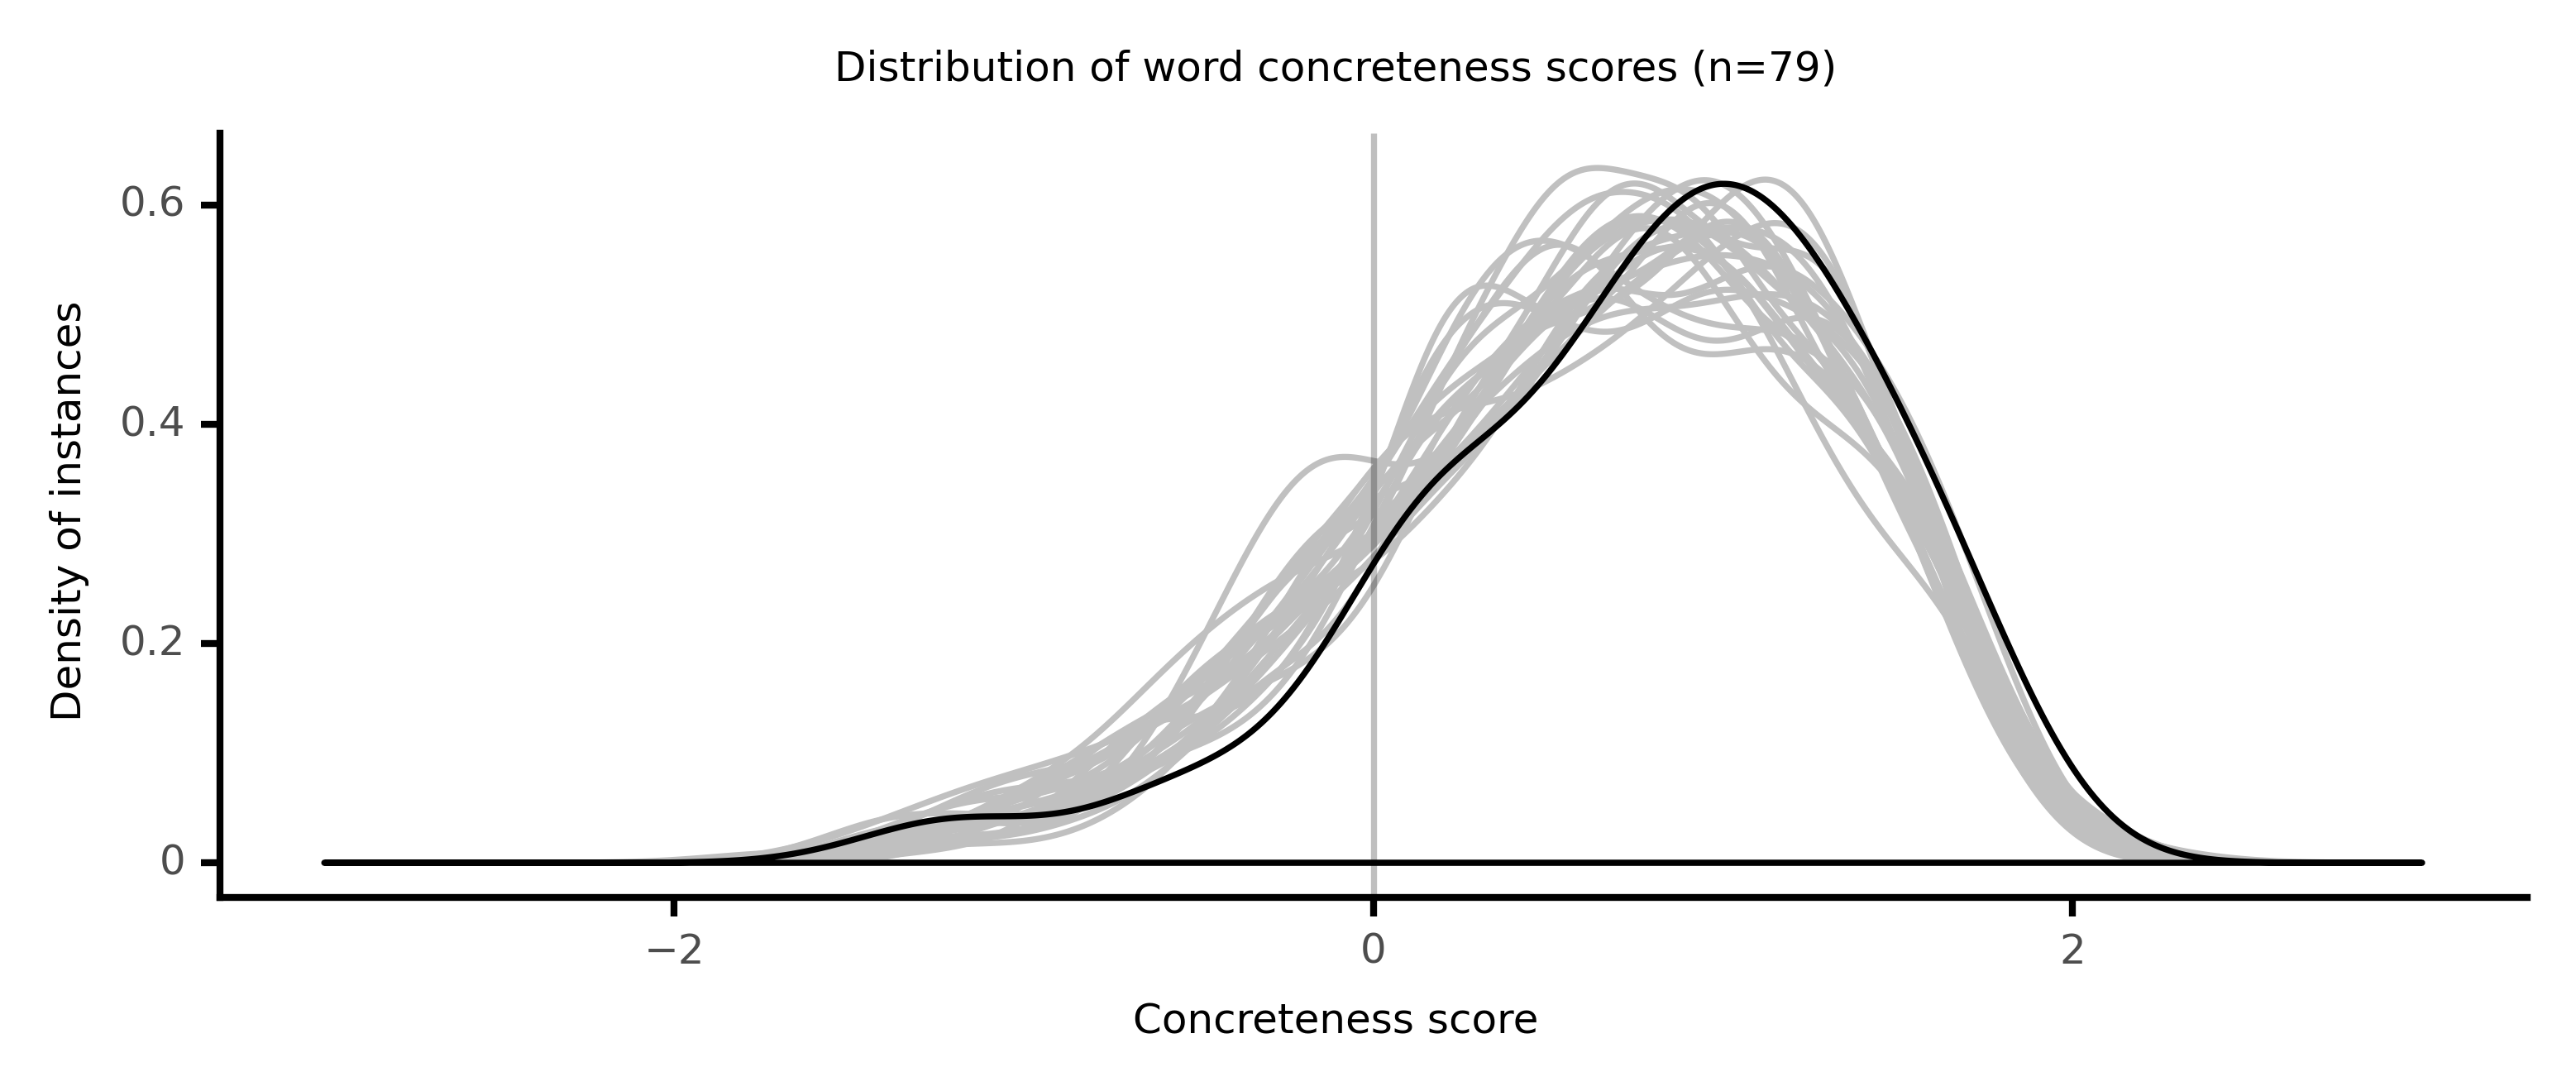

<ggplot: (8742798921945)>

In [30]:
showpsg(
    C.au.McCarthy.Suttree.txt[1000:2000],
    'Suttree',
    C.au.McCarthy.Suttree.txt
)

In [31]:
# showpsg(
#     """
#     “Is Mr. Rochester an exacting, fastidious sort of man?”

# “Not particularly so; but he has a gentleman’s tastes and habits, and he expects to have things managed in conformity to them.”

# “Do you like him? Is he generally liked?”

# “Oh, yes; the family have always been respected here. Almost all the land in this neighbourhood, as far as you can see, has belonged to the Rochesters time out of mind.”

# “Well, but, leaving his land out of the question, do you like him? Is he liked for himself?”

# “I have no cause to do otherwise than like him; and I believe he is considered a just and liberal landlord by his tenants: but he has never lived much amongst them.”

# “But has he no peculiarities? What, in short, is his character?”

# “Oh! his character is unimpeachable, I suppose. He is rather peculiar, perhaps: he has travelled a great deal, and seen a great deal of the world, I should think. I dare say he is clever, but I never had much conversation with him.”

# “In what way is he peculiar?”

# “I don’t know—it is not easy to describe—nothing striking, but you feel it when he speaks to you; you cannot be always sure whether he is in jest or earnest, whether he is pleased or the contrary; you don’t thoroughly understand him, in short—at least, I don’t: but it is of no consequence, he is a very good master.”

# This was all the account I got from Mrs. Fairfax of her employer and mine. There are people who seem to have no notion of sketching a character, or observing and describing salient points, either in persons or things: the good lady evidently belonged to this class; my queries puzzled, but did not draw her out. Mr. Rochester was Mr. Rochester in her eyes; a gentleman, a landed proprietor—nothing more: she inquired and searched no further, and evidently wondered at my wish to gain a more definite notion of his identity.
#     """,
#     'Mr. Rochester, from Mrs. Fairfax\'s point of view'

# )

## Extremes

In [ ]:
cdf=pd.DataFrame(readgen_jsonl('../../data/counts/data.absconc.CanonFiction.psgs.v9-zcut05.jsonl'))
cdf=cdf[cdf.num_total == cdf.num_total.max()]
cdf['abs-conc']=cdf['num_abs']-cdf['num_conc']
cdf['abs/conc']=cdf['num_abs']/cdf['num_conc']

import lltk
C=lltk.load('CanonFiction')
cdf['abs/conc']=cdf['num_abs']/cdf['num_conc']
cdf['abs-conc']=cdf['num_abs']-cdf['num_conc']
cdf['abs-conc_z']=zscore(cdf['abs-conc'])
dfall=cdf.merge(C.metadata,on='id').sort_values('abs-conc')
dfall=dfall[
    ['id','year','title','author','passage','abs-conc','abs-conc_z',
     'num_abs','num_conc','num_neither','num_types','num_total','num_tokens']
]
dfall

Reading data.absconc.CanonFiction.psgs.v9-zcut05.jsonl:  31%|███       | 169993/548268 [00:07<00:16, 23428.38it/s]

In [ ]:
topn=25
most_conc = dfall.head(topn)
most_abs = dfall[dfall.title!='The Making of Americans'].sort_values('abs-conc',ascending=False).head(topn)

In [ ]:
def year2period(y):
    if y<1600: return 'C16'
    if y>1900: return 'C20'
    return f'C{(y//100)+1}'

In [ ]:
def saveextremes(most, name='concrete'):
    for i,(index,row) in enumerate(tqdm(list(most.iterrows()))):
        idx=row.id
        t=C.textd[idx]
        title=f'''#{i+1} most {name} passage: {row.author.split(',')[0]}, _{row.title[:50]}_ ({row.year})'''
        showpsg(
            row.passage,
            title,
            t.txt,
            periods={year2period(t.year)}
        )
    #     break

In [ ]:
saveextremes(most_abs,'abstract')

In [ ]:
saveextremes(most_conc,'concrete')